# Estimation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#pip install sodapy

In [3]:
#pip install census

In [4]:
#pip install aequitas

In [5]:
import download
import mlpipeline
import helper

# Distribution
## Change Dict
- TOTAL = ['LR', 'RF', 'DT', 'GB', 'B']

- CHI: ['RF']

- AV: ['GB']

- CA: ['LR', 'DT', 'B']


## Change to_csv

In [6]:
params = {
    'to_exclude': ['year', 'label'],
    'grid_size': 'small',
    'top_x_percent': 0.1,
    'date_col': 'filing_year',
    'prediction_window': 12,
    'start_time': '2010-01-01',
    'end_time': '2016-01-01',
    'len_train': 36,
    'discrete_bins': 3,
    'cats': ['low', 'medium', 'high'],
    'models_to_run': ['RF'],
    'outcome': 'label',
    'thresholds': [1, 2, 5, 10, 20, 30, 50], 
    'bias_list': ['race', 'poor']}

In [7]:
eviction = download.load_evict('../inputs/eviction_data_tract.csv')
crime = download.load_crime('../inputs/crime_by_tract.csv')
buildings = download.load_building('../inputs/building_violation_by_tract.csv')
acs = download.load_acs('../inputs/acs_year_tract.csv')
education = download.load_education('../inputs/educ_year_tract.csv')
tracts = download.load_tract('../inputs/ch_opdat/tracts.csv')

In [8]:
eviction_df = download.join_bases(eviction, acs, education, crime, buildings, tracts)

In [9]:
#helper.explore_data(eviction_df)

In [10]:
eviction_df = mlpipeline.create_label(eviction_df, 'year', 'eviction_filings_rate', 1 - params['top_x_percent'],
                                      params['prediction_window'])
eviction_df = eviction_df.drop(['eviction_filings_rate_next_year', 'next_year'], axis = 1)

In [11]:
eviction_df.filing_year.describe()

count                    6375
unique                      8
top       2017-01-01 00:00:00
freq                      799
first     2010-01-01 00:00:00
last      2017-01-01 00:00:00
Name: filing_year, dtype: object

In [12]:
rv = mlpipeline.temporal_validation(eviction_df, params['date_col'], params['prediction_window'],
                                    params['start_time'], params['end_time'], params['len_train'],
                                    params['bias_list'])

In [13]:
cols_to_discretize = mlpipeline.get_continuous_variables(eviction_df)
list(cols_to_discretize)
cols_to_binary = []
for col in cols_to_discretize:
     cols_to_binary.append(col + "_group")
processed_rv = mlpipeline.process_train_data(rv, cols_to_discretize, params['discrete_bins'],
                                              params['cats'], cols_to_binary)

perc_increase_total_crime_class_Violent Crime                             797
perc_increase_total_crime_class_Less serious offences_mean_by_commarea    796
perc_increase_bv_mean_by_commarea                                         796
perc_increase_bv                                                          796
perc_increase_total_crime_class_Property Crime                            796
perc_increase_total_crime_class_Less serious offences                     796
perc_increase_total_crime                                                 796
perc_increase_total_crime_class_Violent Crime_mean_by_commarea            796
perc_increase_total_crime_class_Property Crime_mean_by_commarea           796
perc_increase_total_crime_mean_by_commarea                                796
population_race_asian                                                      10
population_race_latinx                                                     10
population_race_other                                           

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Can't fill missing values for non-numeric column race
population_race_other                                             3
population_poverty_below                                          3
population_race_asian                                             3
population_race_latinx                                            3
population_race_black                                             3
population_race_white                                             3
population_poverty_above                                          3
housing_units_rental                                              3
housing_units_other                                               3
race                                                              3
label_prev_year                                                   0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION                     

Can't fill missing values for non-numeric column race
population_race_other                                             3
population_poverty_below                                          3
population_race_asian                                             3
population_race_latinx                                            3
population_race_black                                             3
population_race_white                                             3
population_poverty_above                                          3
housing_units_rental                                              3
housing_units_other                                               3
race                                                              3
label_prev_year                                                   0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION                     

Can't fill missing values for non-numeric column race
race                                                              3
population_poverty_below                                          3
population_race_asian                                             3
population_race_latinx                                            3
population_race_black                                             3
population_race_white                                             3
population_poverty_above                                          3
population_race_other                                             3
housing_units_other                                               3
housing_units_rental                                              3
perc_increase_total_crime_class_Property Crime                    1
perc_increase_total_crime_class_Violent Crime                     1
total_primary_type_PROSTITUTION                                   0
total_primary_type_THEFT                                      

Can't fill missing values for non-numeric column race
race                                                              2
housing_units_other                                               2
population_race_asian                                             2
population_race_latinx                                            2
population_race_black                                             2
population_race_white                                             2
population_poverty_above                                          2
population_poverty_below                                          2
population_race_other                                             2
housing_units_rental                                              2
perc_increase_total_crime_class_Violent Crime                     1
total_primary_type_WEAPONS VIOLATION                              0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                           

In [14]:
key1 = list(processed_rv.keys())[0]
train = processed_rv[key1][0]
selected_features = list(train.loc[:,train.apply(lambda x: x.isin([0, 1]).all())].columns)
selected_features.remove('label')

In [15]:
import warnings
warnings.simplefilter(action='ignore')

RF


<Figure size 432x288 with 0 Axes>

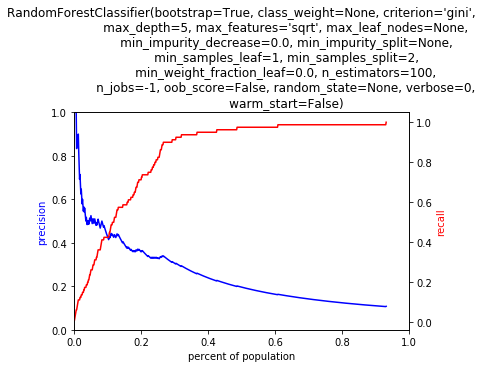

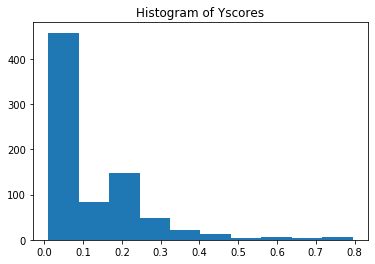

FEATURE IMPORTANCES

1. Feature label_prev_year (0.092702)
2. Feature eviction_filings_rate_group_low (0.031856)
3. Feature population_race_black_group_high (0.024457)
4. Feature eviction_filings_rate_group_medium (0.023369)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.021406)
6. Feature population_race_black_mean_by_commarea_group_low (0.021149)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.020806)
8. Feature population_race_black_group_low (0.018717)
9. Feature total_domestic_1_mean_by_commarea_group_low (0.017667)
10. Feature total_arrest_0_mean_by_commarea_group_low (0.016673)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

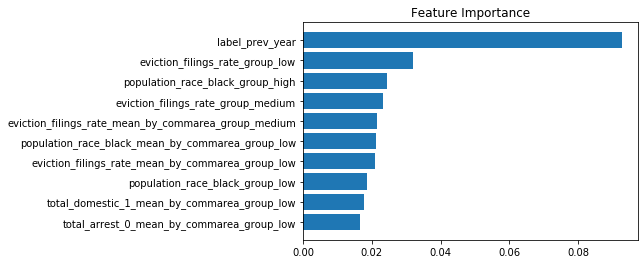

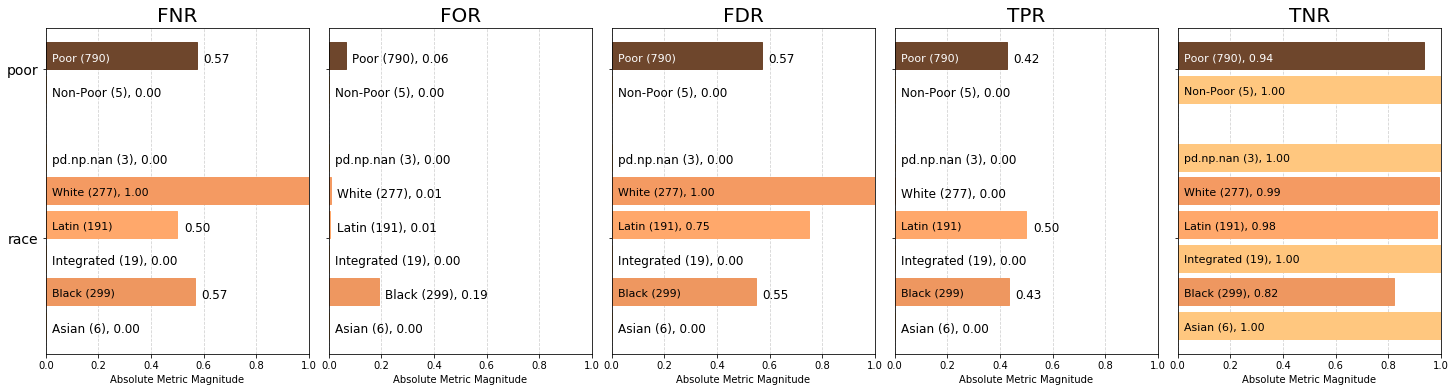

<Figure size 432x288 with 0 Axes>

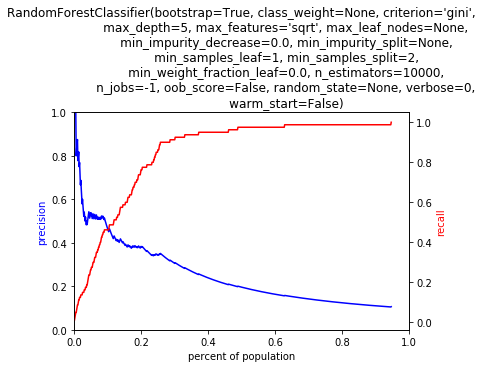

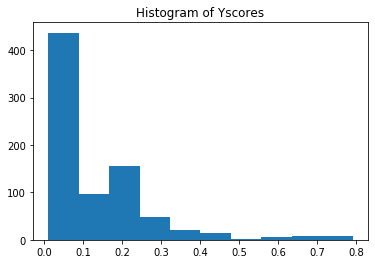

FEATURE IMPORTANCES

1. Feature label_prev_year (0.077534)
2. Feature eviction_filings_rate_group_low (0.033323)
3. Feature eviction_filings_rate_group_medium (0.025848)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.021370)
5. Feature population_race_black_group_high (0.020348)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.019440)
7. Feature population_race_black_mean_by_commarea_group_low (0.018611)
8. Feature population_race_black_group_low (0.018029)
9. Feature population_race_black_mean_by_commarea_group_high (0.017858)
10. Feature eviction_order_yes_group_low (0.012678)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

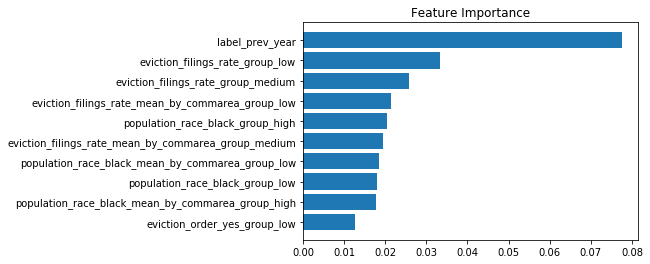

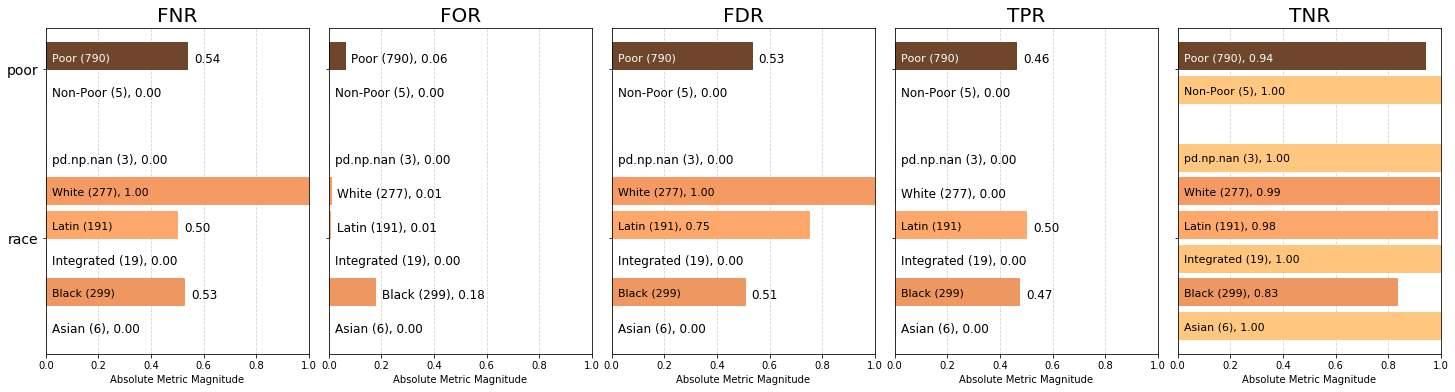

<Figure size 432x288 with 0 Axes>

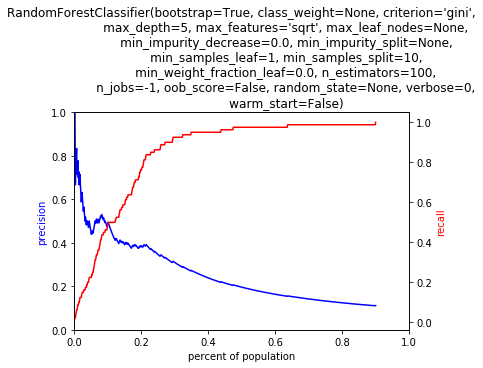

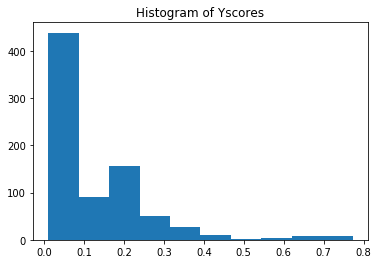

FEATURE IMPORTANCES

1. Feature label_prev_year (0.081292)
2. Feature eviction_filings_rate_group_medium (0.040288)
3. Feature population_race_black_group_low (0.029844)
4. Feature default_eviction_order_no_group_low (0.024295)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.023754)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.018335)
7. Feature population_race_black_mean_by_commarea_group_low (0.017158)
8. Feature population_race_black_mean_by_commarea_group_high (0.016591)
9. Feature population_race_black_group_high (0.016005)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.014867)
            score  label_value
race                          
Asian           0          0.0
Black          75         76.0
Integrated      0          0.0
Latin           2          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

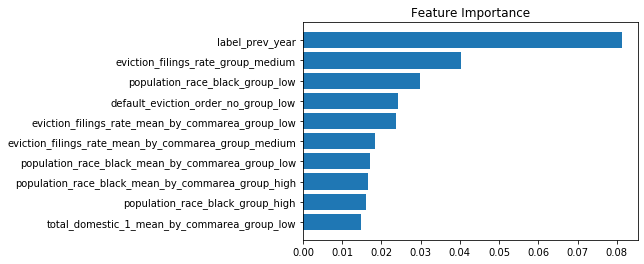

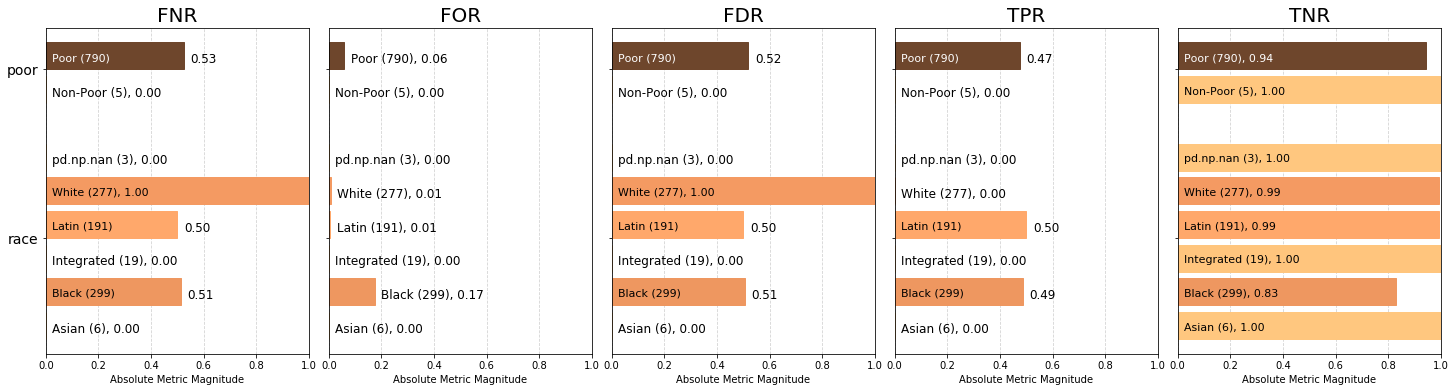

<Figure size 432x288 with 0 Axes>

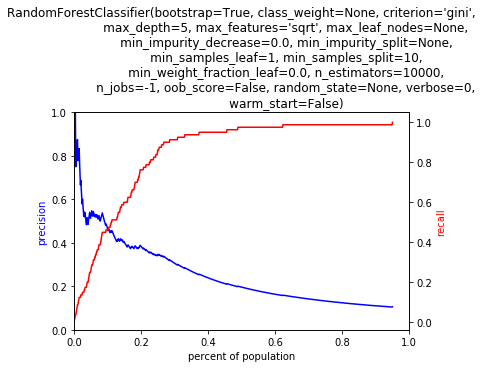

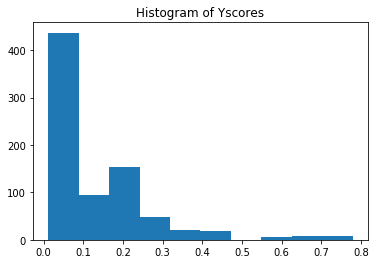

FEATURE IMPORTANCES

1. Feature label_prev_year (0.082717)
2. Feature eviction_filings_rate_group_low (0.033595)
3. Feature eviction_filings_rate_group_medium (0.026920)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.023008)
5. Feature population_race_black_group_high (0.021782)
6. Feature population_race_black_group_low (0.020947)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.020435)
8. Feature population_race_black_mean_by_commarea_group_low (0.019578)
9. Feature population_race_black_mean_by_commarea_group_high (0.019280)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.012970)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

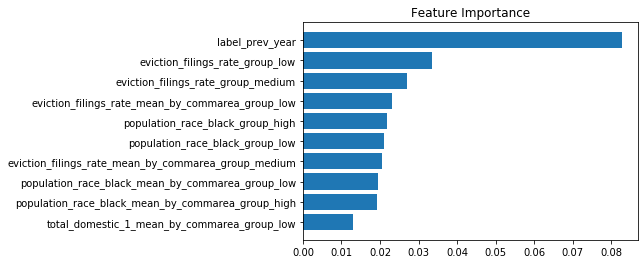

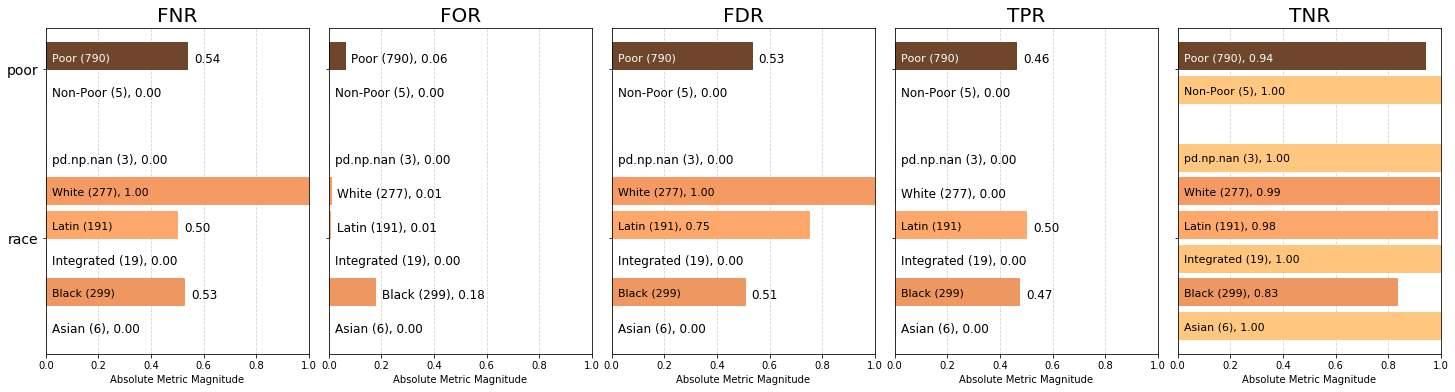

<Figure size 432x288 with 0 Axes>

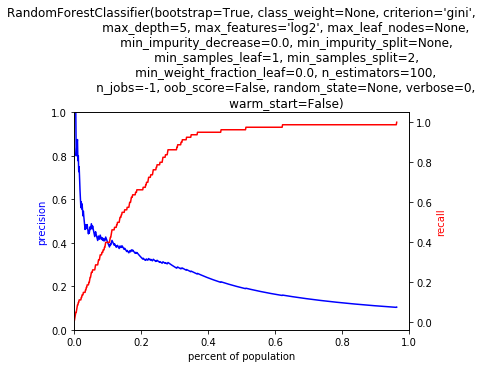

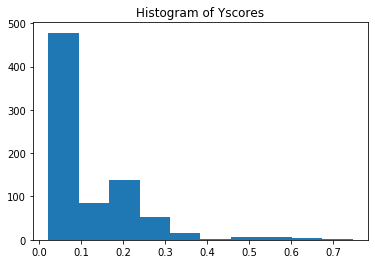

FEATURE IMPORTANCES

1. Feature label_prev_year (0.035637)
2. Feature perc_total_crime_class_Property Crime_mean_by_commarea_group_low (0.017337)
3. Feature population_race_black_mean_by_commarea_group_low (0.016932)
4. Feature eviction_filings_rate_group_medium (0.015545)
5. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.015422)
6. Feature population_race_black_group_high (0.014416)
7. Feature population_race_black_group_low (0.014365)
8. Feature total_arrest_0_mean_by_commarea_group_medium (0.014322)
9. Feature total_primary_type_ROBBERY_mean_by_commarea_group_low (0.010216)
10. Feature eviction_filings_completed_group_medium (0.010069)
            score  label_value
race                          
Asian           0          0.0
Black          77         76.0
Integrated      0          0.0
Latin           0          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

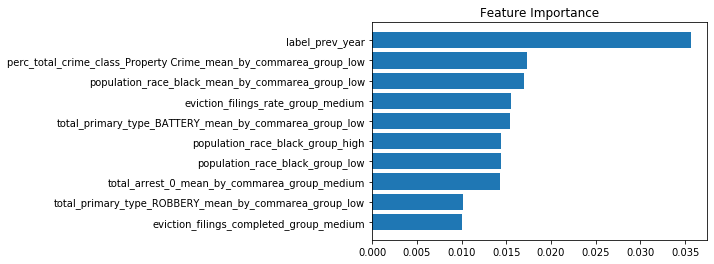

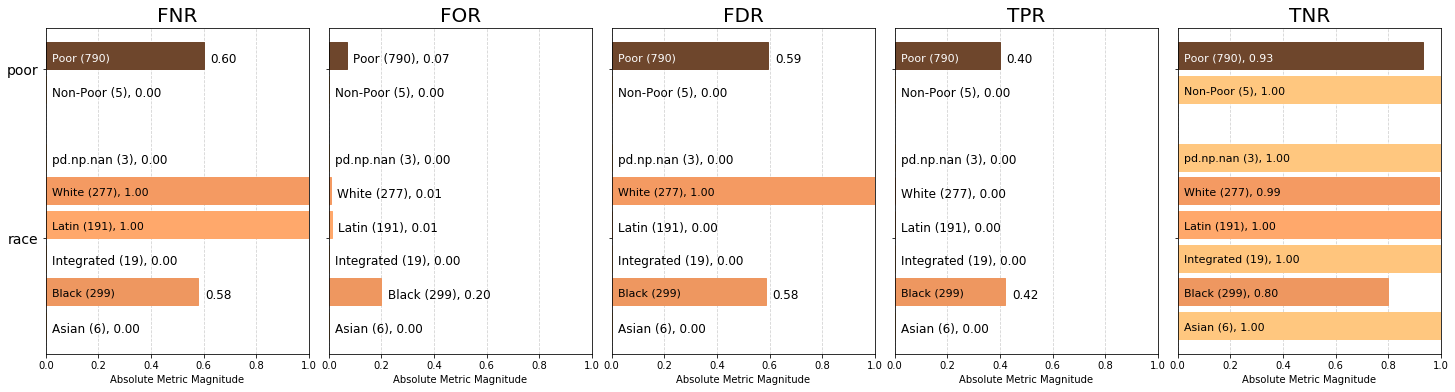

<Figure size 432x288 with 0 Axes>

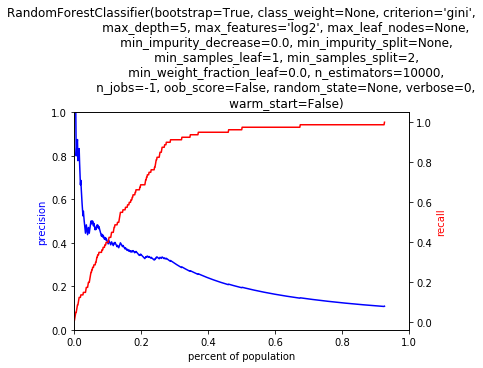

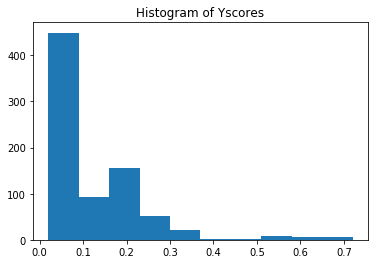

FEATURE IMPORTANCES

1. Feature label_prev_year (0.033420)
2. Feature eviction_filings_rate_group_low (0.015494)
3. Feature eviction_filings_rate_group_medium (0.014137)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.013807)
5. Feature population_race_black_group_high (0.012212)
6. Feature population_race_black_group_low (0.012202)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.011960)
8. Feature population_race_black_mean_by_commarea_group_high (0.011325)
9. Feature population_race_black_mean_by_commarea_group_low (0.011062)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.009353)
            score  label_value
race                          
Asian           0          0.0
Black          76         76.0
Integrated      0          0.0
Latin           1          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

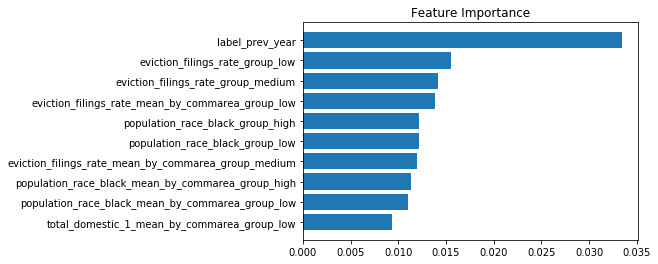

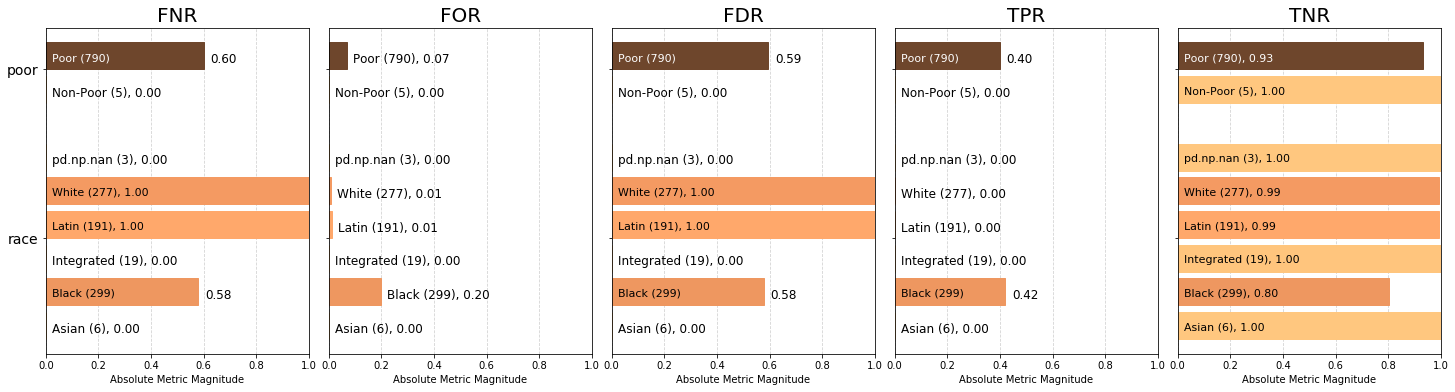

<Figure size 432x288 with 0 Axes>

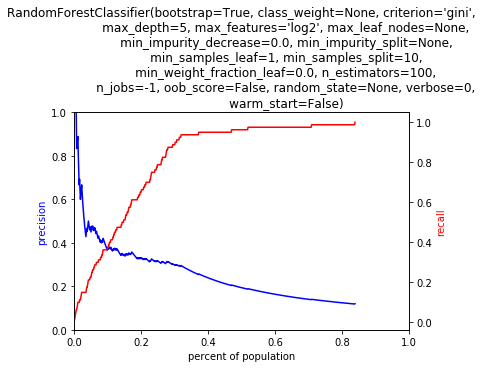

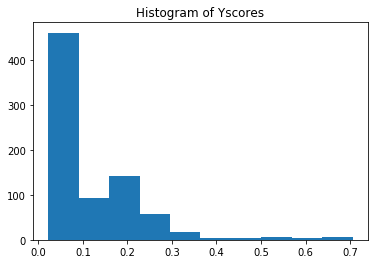

FEATURE IMPORTANCES

1. Feature label_prev_year (0.027031)
2. Feature eviction_filings_rate_group_low (0.021834)
3. Feature total_domestic_1_mean_by_commarea_group_low (0.021694)
4. Feature total_arrest_1_mean_by_commarea_group_low (0.018120)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.017927)
6. Feature ftu_eviction_order_tenant_prose_group_low (0.016754)
7. Feature population_race_black_mean_by_commarea_group_low (0.015394)
8. Feature default_eviction_order_no_group_low (0.014581)
9. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.014443)
10. Feature eviction_filings_total_group_medium (0.013169)
            score  label_value
race                          
Asian           0          0.0
Black          76         76.0
Integrated      0          0.0
Latin           1          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

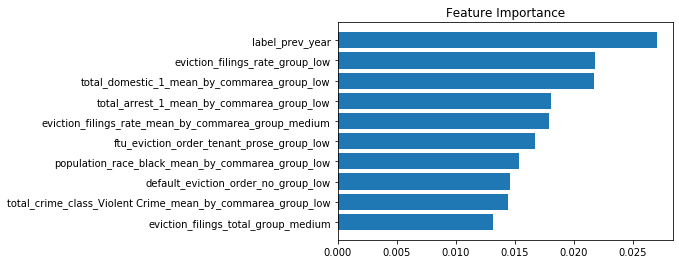

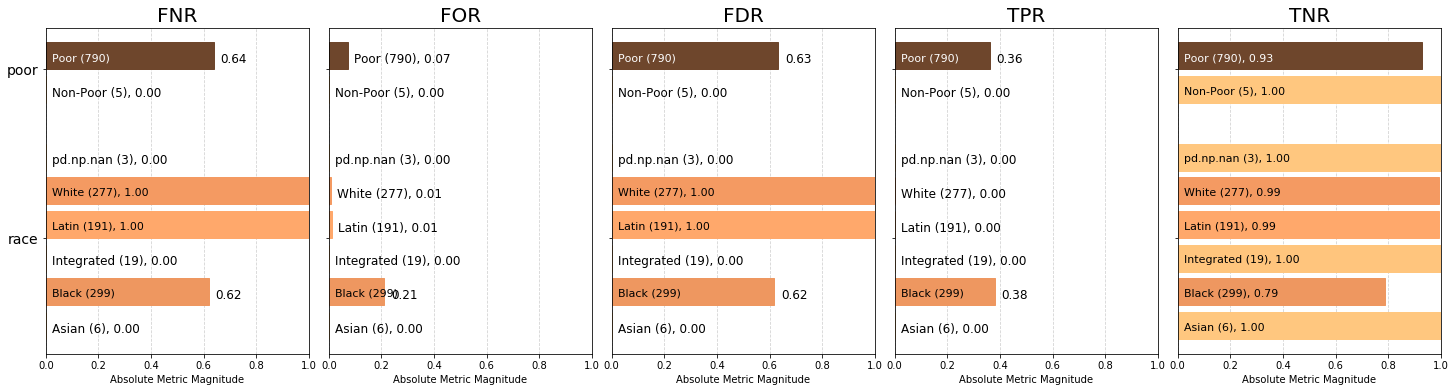

<Figure size 432x288 with 0 Axes>

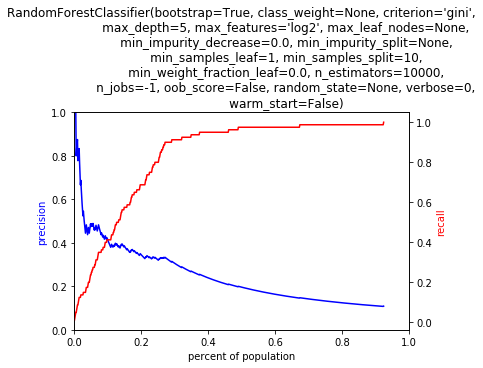

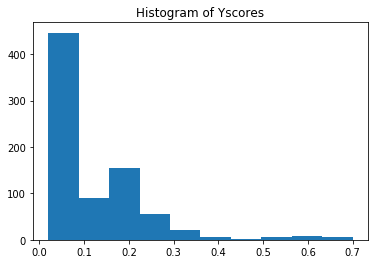

FEATURE IMPORTANCES

1. Feature label_prev_year (0.033932)
2. Feature eviction_filings_rate_group_low (0.016751)
3. Feature eviction_filings_rate_group_medium (0.014319)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.013874)
5. Feature population_race_black_mean_by_commarea_group_high (0.012795)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.012647)
7. Feature population_race_black_group_high (0.012598)
8. Feature population_race_black_mean_by_commarea_group_low (0.012032)
9. Feature population_race_black_group_low (0.011756)
10. Feature eviction_filings_total_group_low (0.009744)
            score  label_value
race                          
Asian           0          0.0
Black          76         76.0
Integrated      0          0.0
Latin           1          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

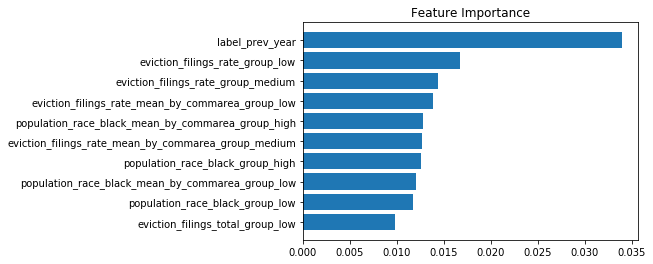

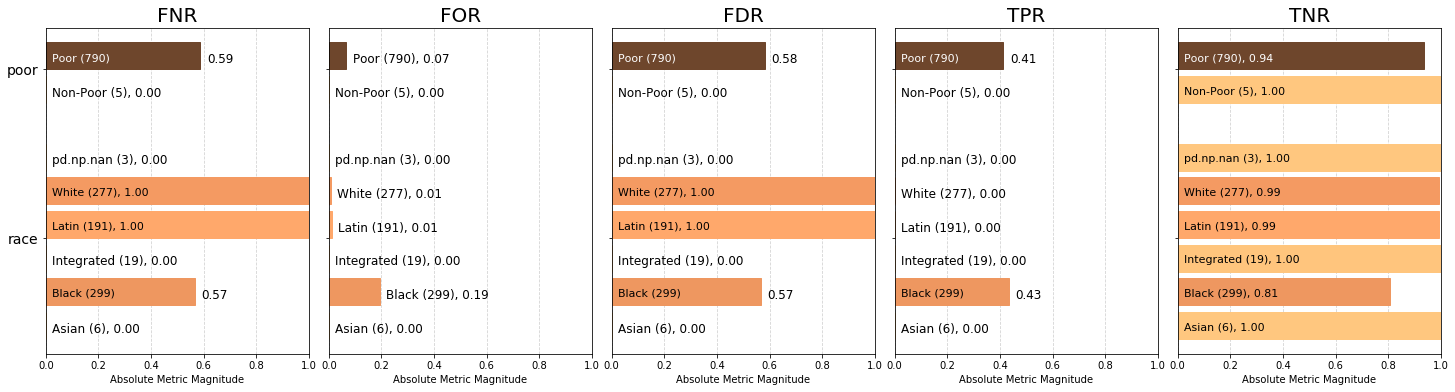

<Figure size 432x288 with 0 Axes>

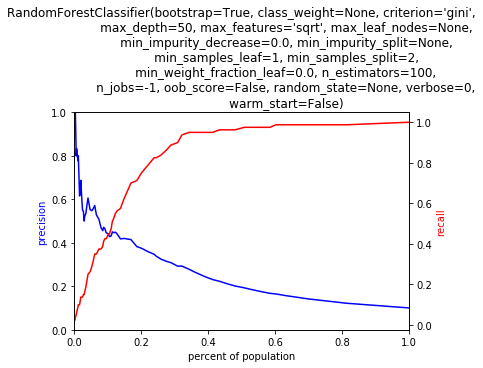

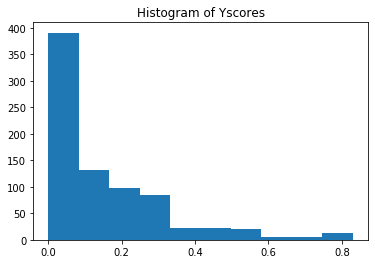

FEATURE IMPORTANCES

1. Feature label_prev_year (0.056550)
2. Feature eviction_filings_rate_group_low (0.016466)
3. Feature eviction_filings_rate_group_medium (0.013448)
4. Feature population_race_black_group_low (0.010652)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008682)
6. Feature some_college_group_medium (0.008655)
7. Feature high_school_grad_group_medium (0.007452)
8. Feature population_race_black_mean_by_commarea_group_high (0.007426)
9. Feature population_poverty_below_group_low (0.007405)
10. Feature population_race_black_group_high (0.007300)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

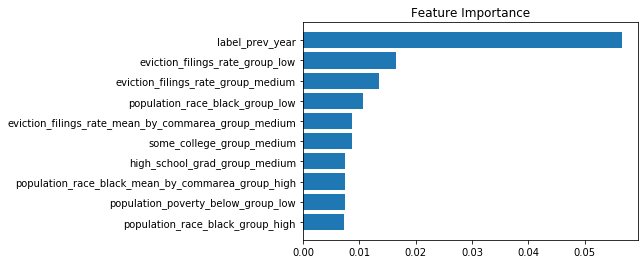

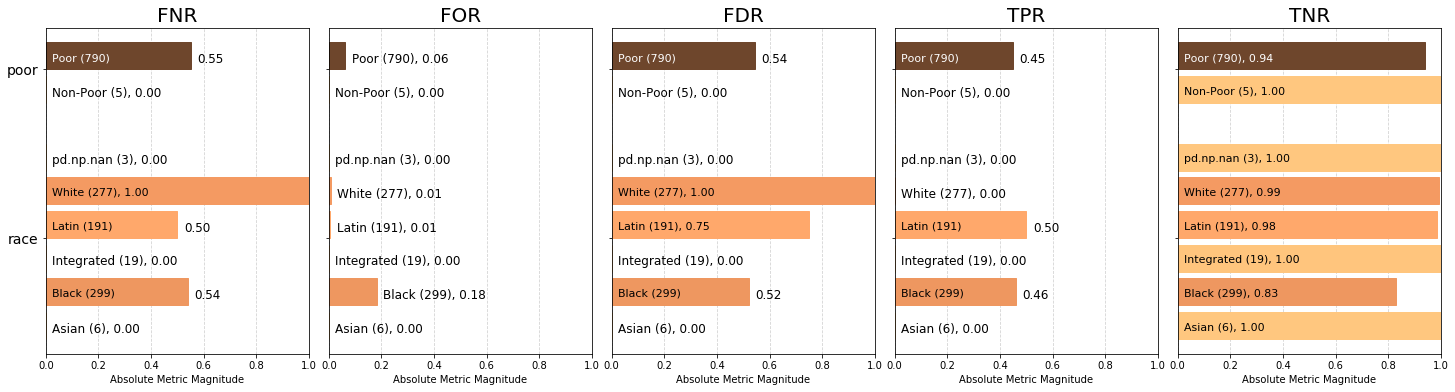

<Figure size 432x288 with 0 Axes>

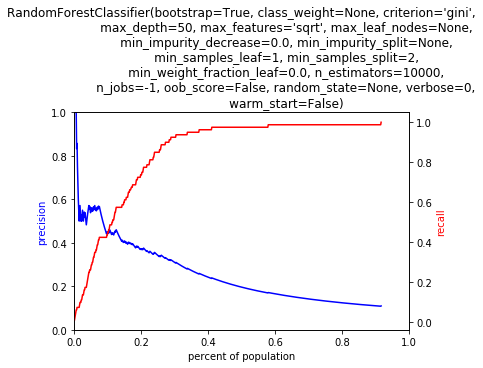

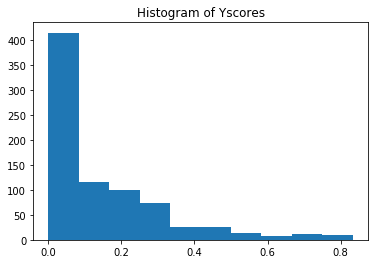

FEATURE IMPORTANCES

1. Feature label_prev_year (0.049001)
2. Feature eviction_filings_rate_group_low (0.017780)
3. Feature eviction_filings_rate_group_medium (0.013658)
4. Feature population_race_black_group_high (0.009465)
5. Feature some_college_group_medium (0.009076)
6. Feature population_race_black_group_low (0.007426)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.007412)
8. Feature total_violation_status_OPEN_perc_group_medium (0.007201)
9. Feature total_violation_status_COMPLIED_perc_group_medium (0.007085)
10. Feature high_school_grad_group_medium (0.007032)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

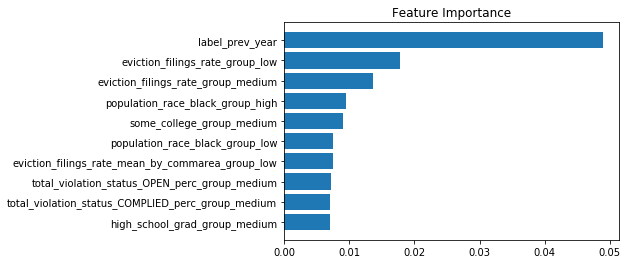

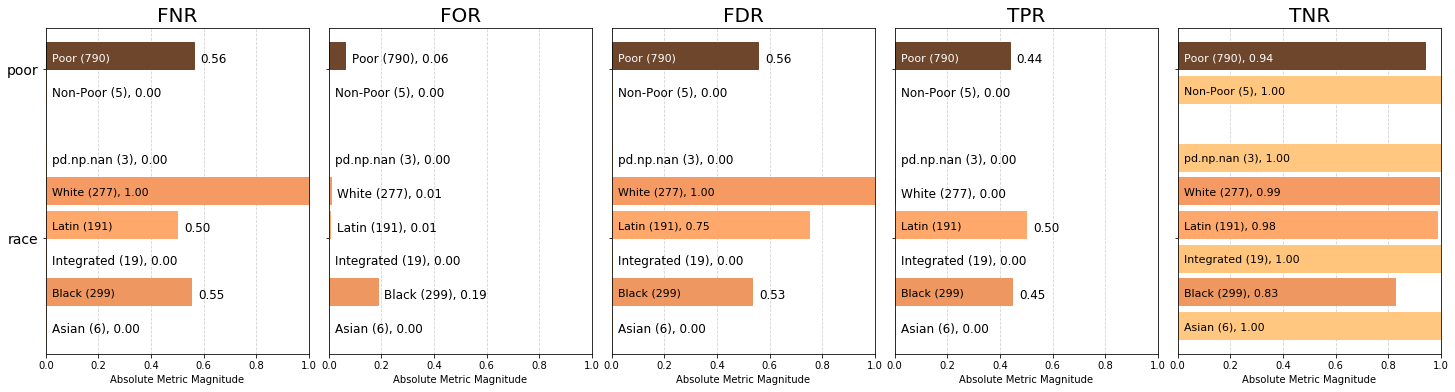

<Figure size 432x288 with 0 Axes>

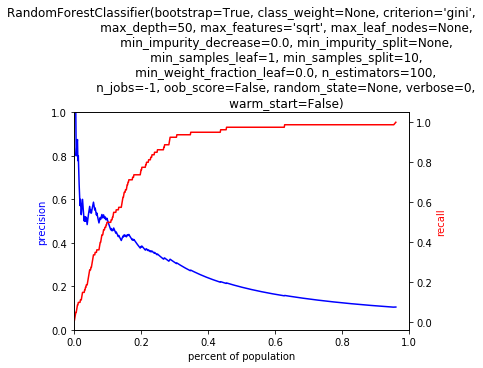

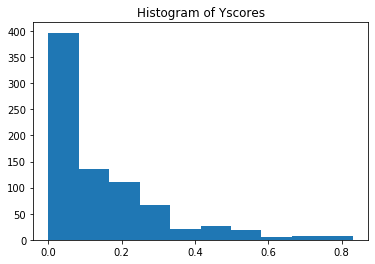

FEATURE IMPORTANCES

1. Feature label_prev_year (0.070733)
2. Feature eviction_filings_rate_group_low (0.025663)
3. Feature eviction_filings_rate_group_medium (0.019486)
4. Feature eviction_order_yes_tenant_prose_group_low (0.014617)
5. Feature population_race_black_mean_by_commarea_group_high (0.012955)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.010256)
7. Feature total_primary_type_ROBBERY_mean_by_commarea_group_medium (0.010131)
8. Feature eviction_filings_rate_mean_by_commarea_group_low (0.010078)
9. Feature population_race_black_mean_by_commarea_group_low (0.009604)
10. Feature eviction_order_yes_group_medium (0.008169)
            score  label_value
race                          
Asian           0          0.0
Black          75         76.0
Integrated      0          0.0
Latin           3          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

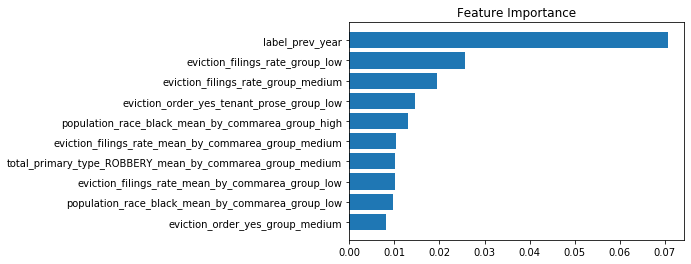

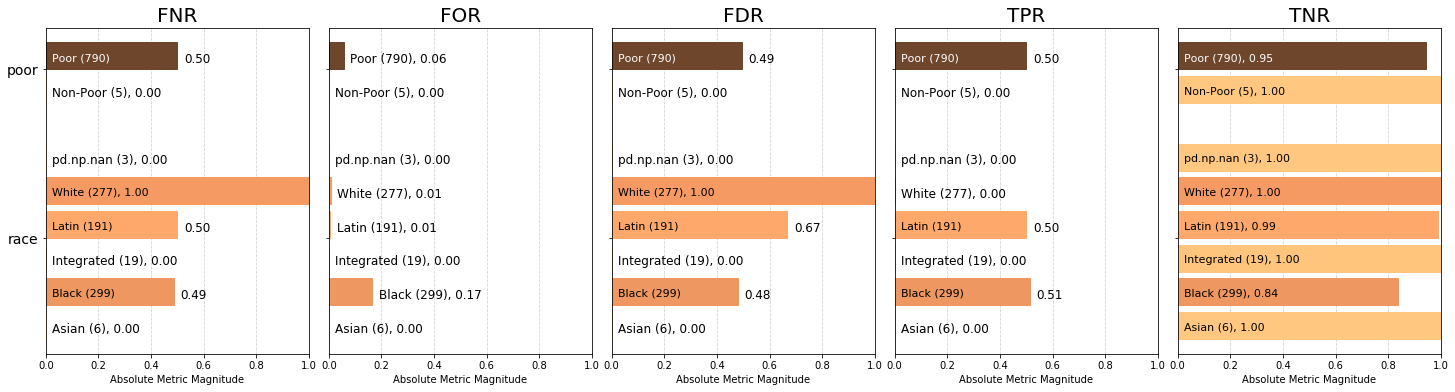

<Figure size 432x288 with 0 Axes>

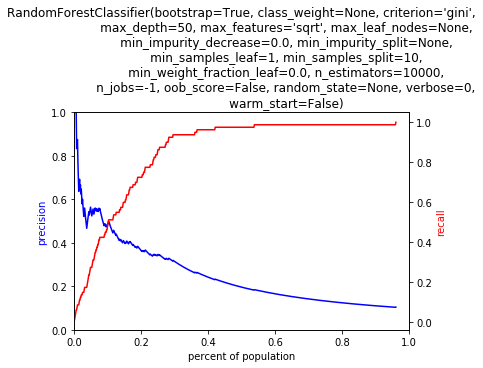

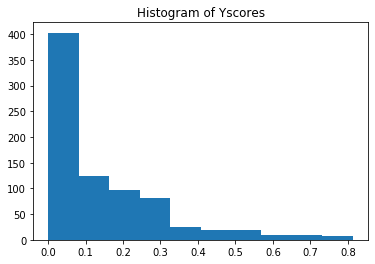

FEATURE IMPORTANCES

1. Feature label_prev_year (0.069009)
2. Feature eviction_filings_rate_group_low (0.027046)
3. Feature eviction_filings_rate_group_medium (0.020560)
4. Feature population_race_black_group_high (0.012573)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.012011)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.011018)
7. Feature population_race_black_group_low (0.010600)
8. Feature population_race_black_mean_by_commarea_group_high (0.010268)
9. Feature population_race_black_mean_by_commarea_group_low (0.009574)
10. Feature eviction_order_yes_group_low (0.006455)
            score  label_value
race                          
Asian           0          0.0
Black          74         76.0
Integrated      0          0.0
Latin           3          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

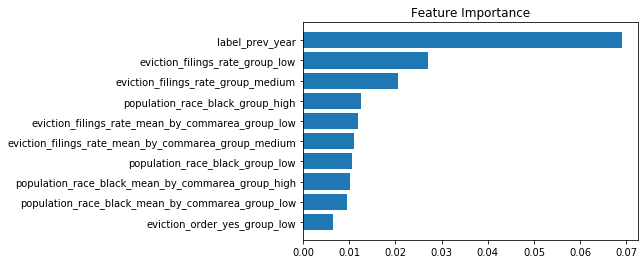

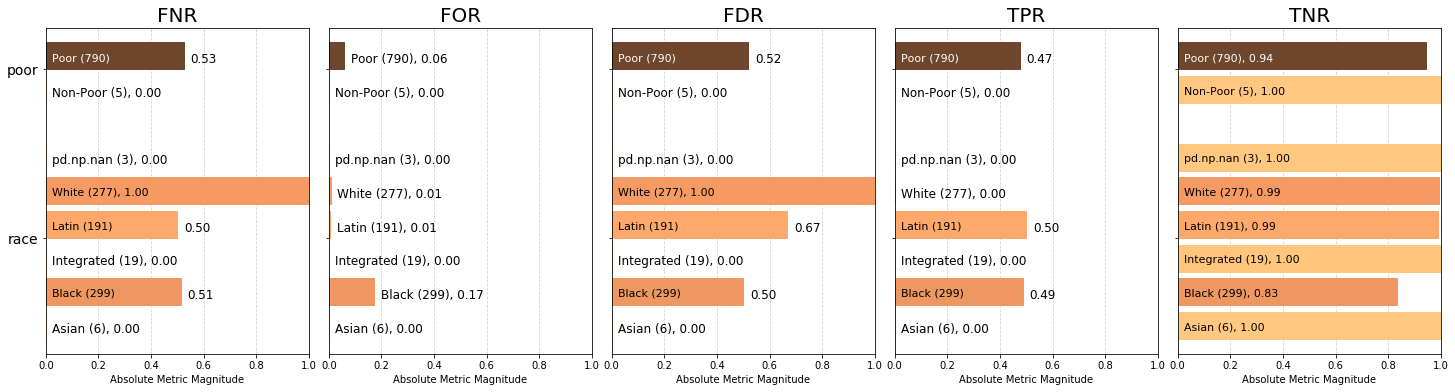

<Figure size 432x288 with 0 Axes>

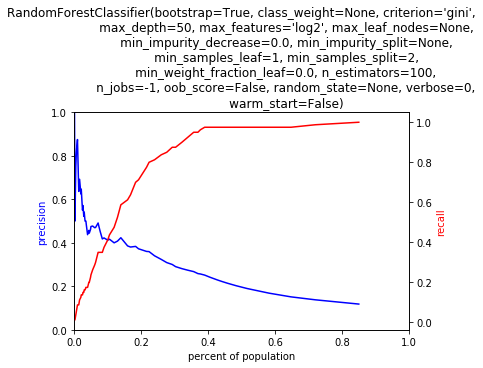

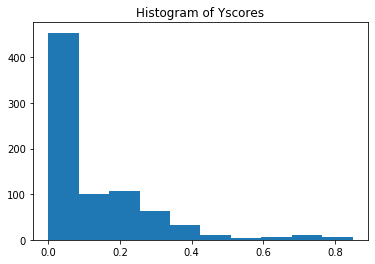

FEATURE IMPORTANCES

1. Feature label_prev_year (0.027037)
2. Feature eviction_filings_rate_group_low (0.012182)
3. Feature eviction_filings_rate_group_medium (0.009560)
4. Feature high_school_grad_group_medium (0.009098)
5. Feature total_violation_status_OPEN_perc_group_medium (0.008978)
6. Feature some_college_group_high (0.008836)
7. Feature some_college_group_medium (0.008680)
8. Feature perc_total_crime_class_Property Crime_group_low (0.008374)
9. Feature total_violation_status_COMPLIED_perc_group_medium (0.008017)
10. Feature perc_total_crime_class_Property Crime_group_medium (0.007821)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           3          2.0
White           3          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

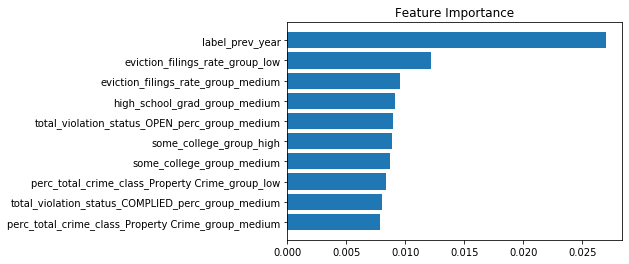

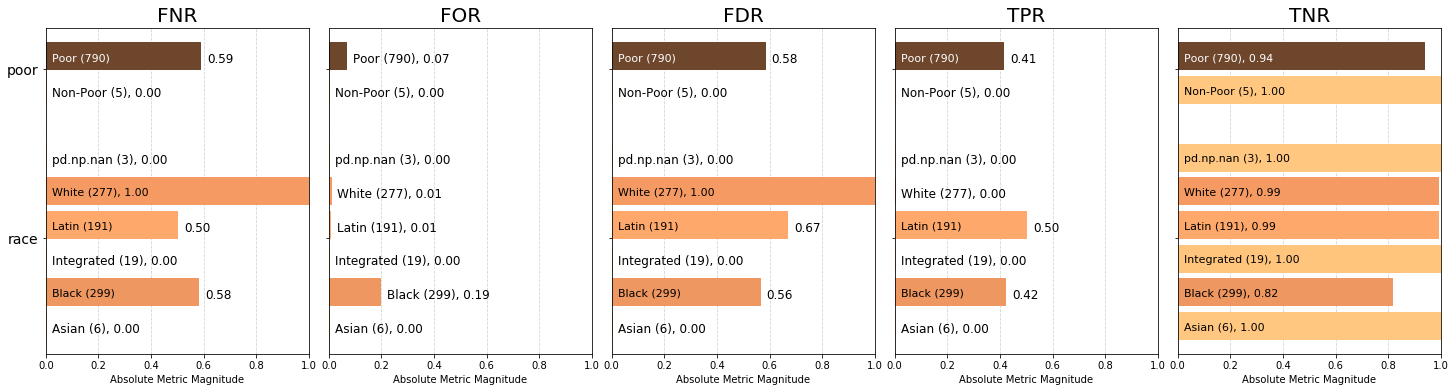

<Figure size 432x288 with 0 Axes>

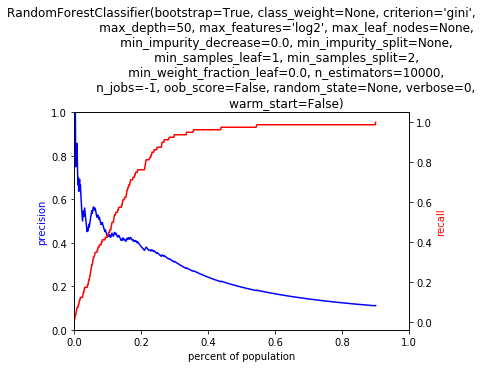

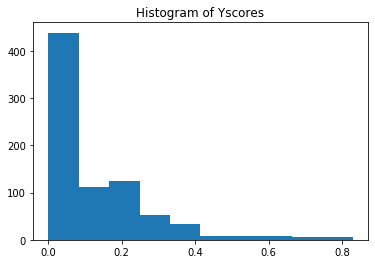

FEATURE IMPORTANCES

1. Feature label_prev_year (0.028345)
2. Feature eviction_filings_rate_group_low (0.011543)
3. Feature some_college_group_medium (0.010046)
4. Feature eviction_filings_rate_group_medium (0.009183)
5. Feature total_violation_status_OPEN_perc_group_medium (0.008113)
6. Feature total_violation_status_COMPLIED_perc_group_medium (0.008081)
7. Feature high_school_grad_group_medium (0.007946)
8. Feature some_college_group_high (0.007758)
9. Feature population_poverty_above_group_medium (0.007745)
10. Feature population_poverty_below_group_medium (0.007657)
            score  label_value
race                          
Asian           0          0.0
Black          73         76.0
Integrated      0          0.0
Latin           4          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

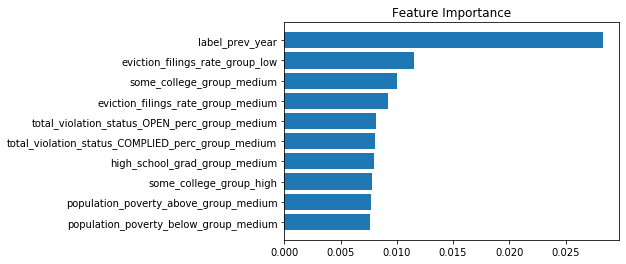

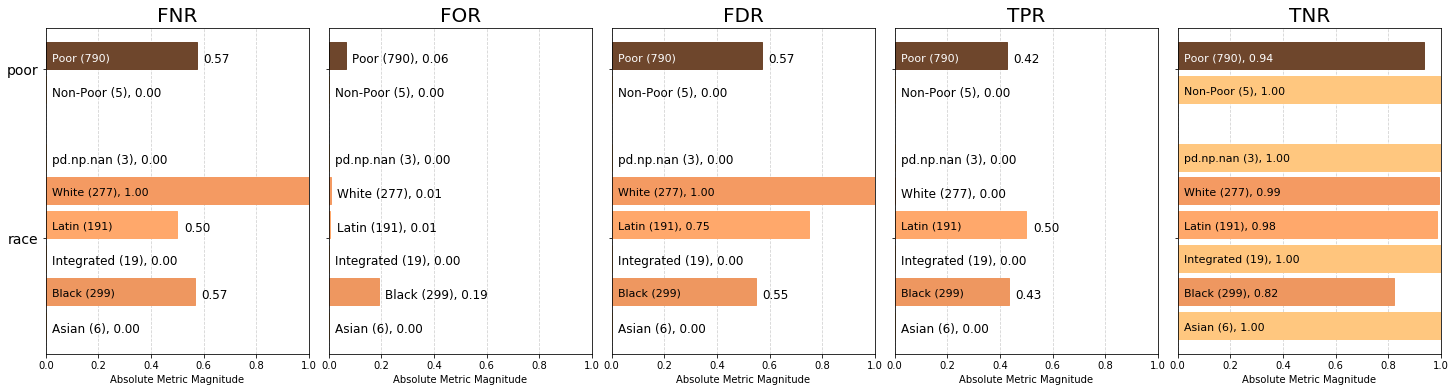

<Figure size 432x288 with 0 Axes>

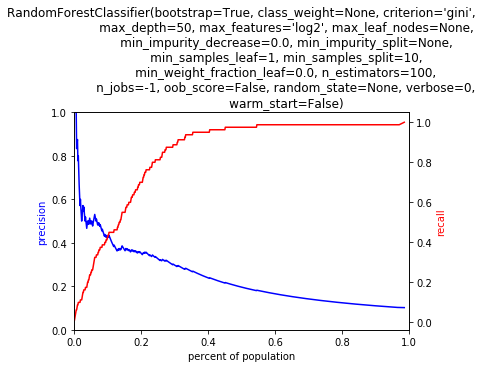

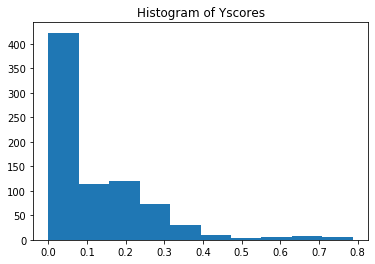

FEATURE IMPORTANCES

1. Feature label_prev_year (0.041263)
2. Feature eviction_filings_rate_group_low (0.014115)
3. Feature population_race_black_mean_by_commarea_group_low (0.011714)
4. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_low (0.011475)
5. Feature eviction_filings_rate_group_medium (0.009757)
6. Feature population_race_black_mean_by_commarea_group_high (0.009686)
7. Feature population_race_black_group_high (0.009155)
8. Feature total_crime_mean_by_commarea_group_medium (0.007959)
9. Feature total_primary_type_CRIM SEXUAL ASSAULT_mean_by_commarea_group_low (0.007938)
10. Feature eviction_order_yes_tenant_prose_group_low (0.007427)
            score  label_value
race                          
Asian           0          0.0
Black          75         76.0
Integrated      0          0.0
Latin           2          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

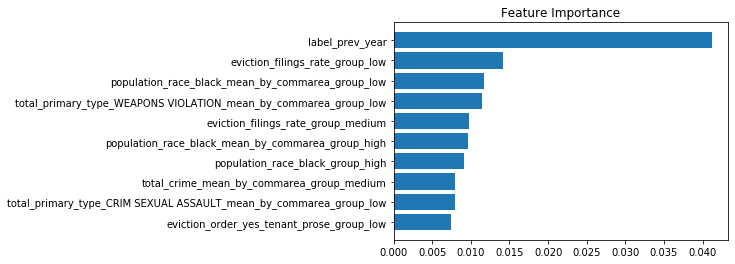

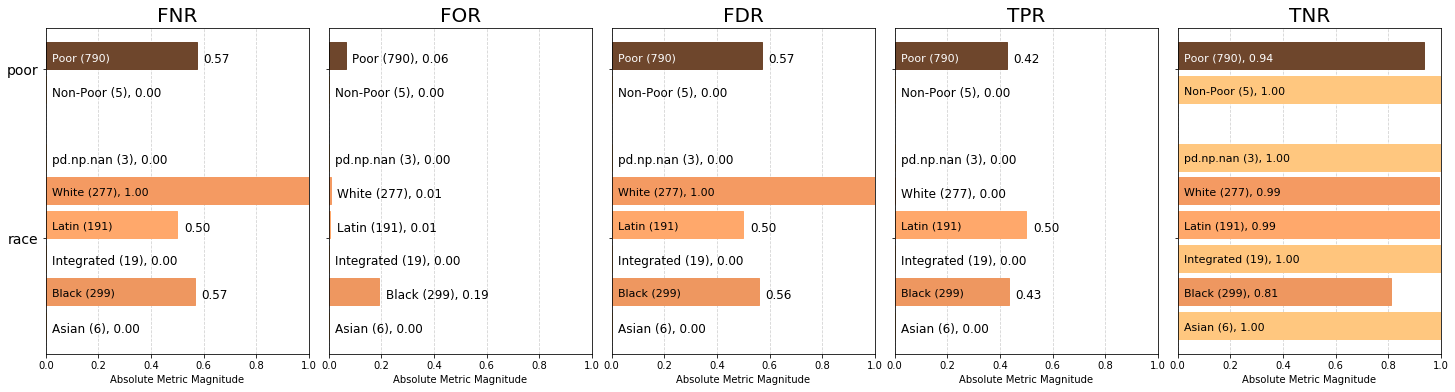

<Figure size 432x288 with 0 Axes>

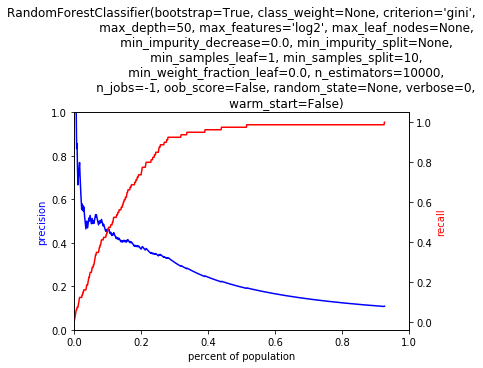

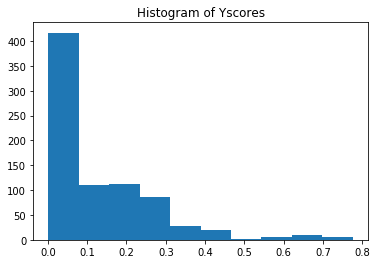

FEATURE IMPORTANCES

1. Feature label_prev_year (0.038781)
2. Feature eviction_filings_rate_group_low (0.017231)
3. Feature eviction_filings_rate_group_medium (0.013710)
4. Feature population_race_black_group_high (0.008988)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.008221)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008142)
7. Feature population_race_black_group_low (0.007528)
8. Feature population_race_black_mean_by_commarea_group_high (0.006855)
9. Feature population_race_black_mean_by_commarea_group_low (0.006533)
10. Feature eviction_order_yes_group_low (0.005183)
            score  label_value
race                          
Asian           0          0.0
Black          75         76.0
Integrated      0          0.0
Latin           1          2.0
White           3          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

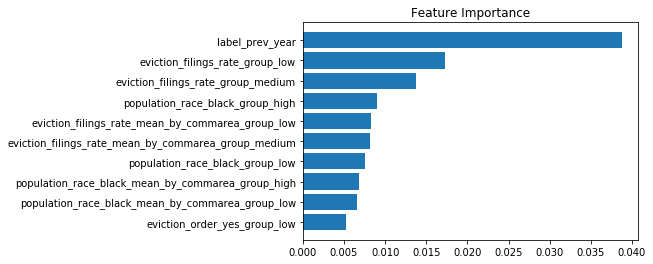

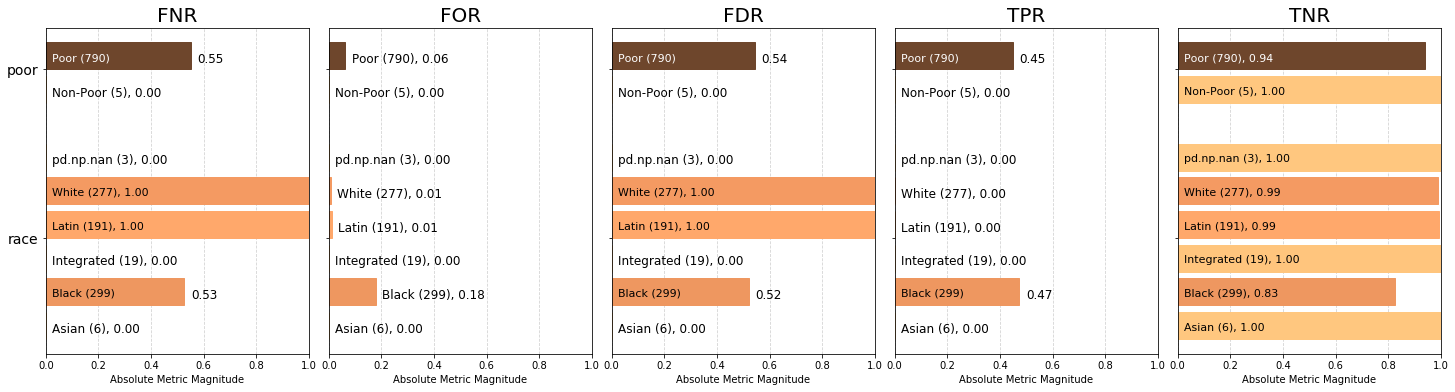

RF


<Figure size 432x288 with 0 Axes>

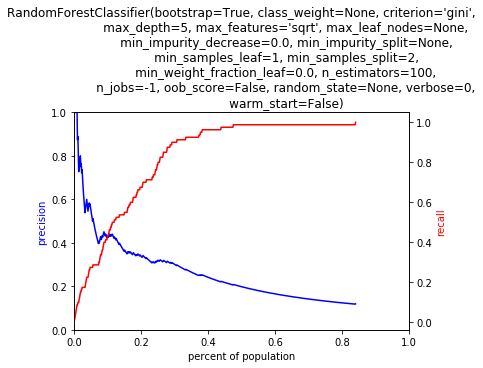

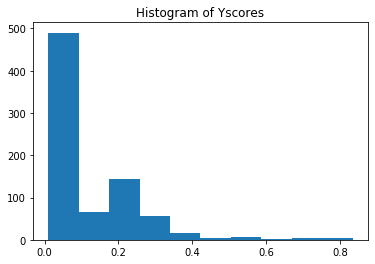

FEATURE IMPORTANCES

1. Feature label_prev_year (0.087121)
2. Feature population_race_black_group_high (0.034213)
3. Feature eviction_filings_rate_group_low (0.030762)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.030417)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.029341)
6. Feature population_race_black_group_low (0.026752)
7. Feature population_race_black_mean_by_commarea_group_high (0.023568)
8. Feature eviction_order_yes_tenant_prose_group_low (0.019163)
9. Feature total_primary_type_ROBBERY_mean_by_commarea_group_low (0.019160)
10. Feature population_race_black_mean_by_commarea_group_low (0.017198)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          2.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

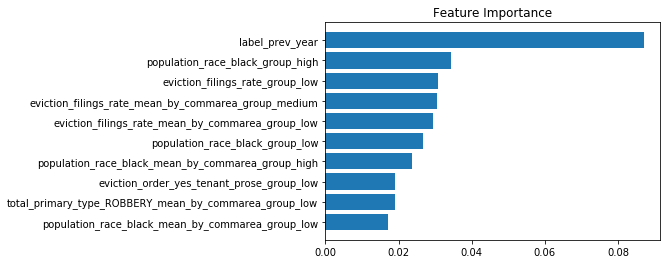

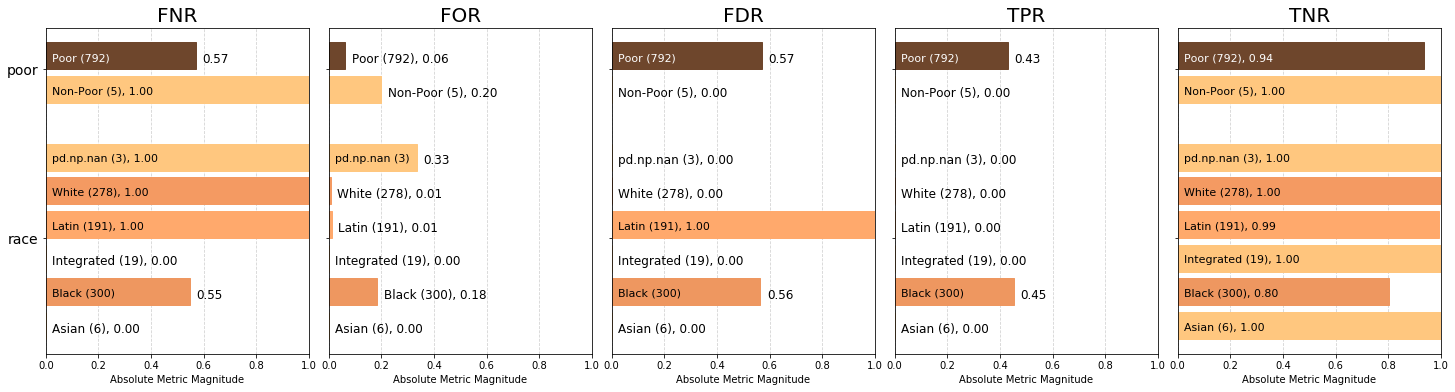

<Figure size 432x288 with 0 Axes>

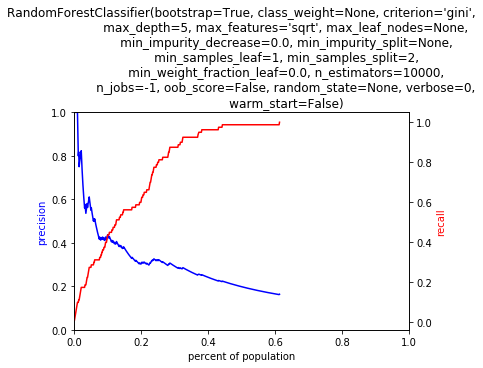

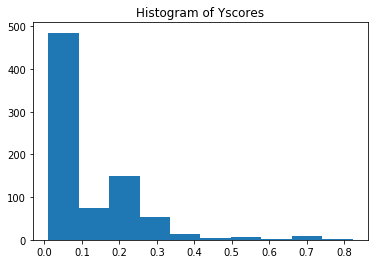

FEATURE IMPORTANCES

1. Feature label_prev_year (0.080801)
2. Feature eviction_filings_rate_group_low (0.029011)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.028654)
4. Feature population_race_black_group_high (0.028581)
5. Feature eviction_filings_rate_group_medium (0.023543)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.023306)
7. Feature population_race_black_mean_by_commarea_group_high (0.022809)
8. Feature population_race_black_group_low (0.022570)
9. Feature population_race_black_mean_by_commarea_group_low (0.020002)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.014956)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           1          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

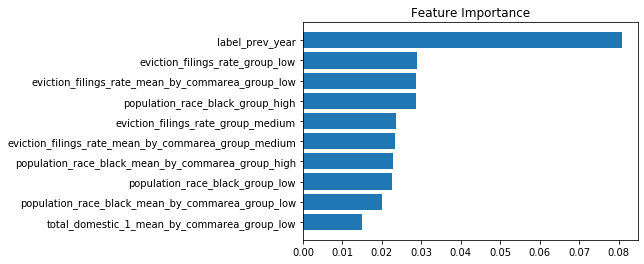

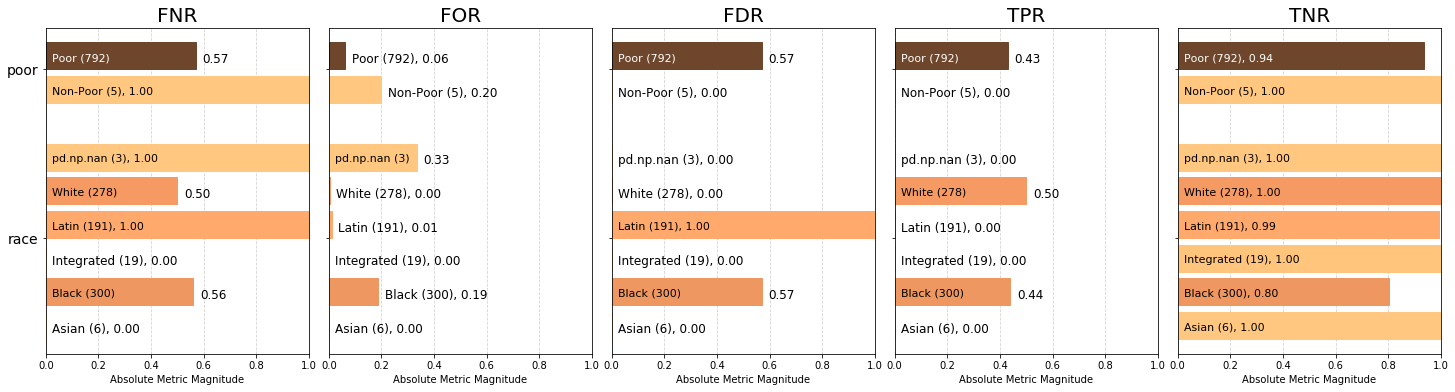

<Figure size 432x288 with 0 Axes>

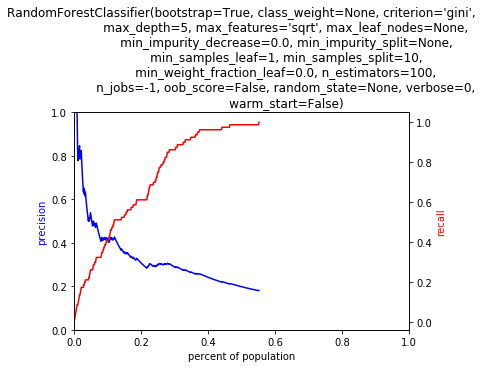

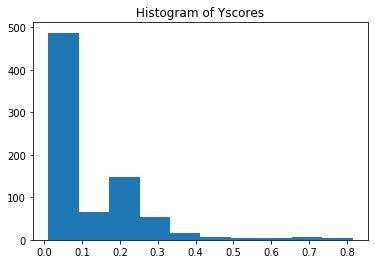

FEATURE IMPORTANCES

1. Feature label_prev_year (0.096807)
2. Feature eviction_filings_rate_group_medium (0.038373)
3. Feature population_race_black_group_high (0.035244)
4. Feature eviction_filings_rate_group_low (0.033641)
5. Feature population_race_black_group_low (0.029408)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.028220)
7. Feature population_race_black_mean_by_commarea_group_low (0.026135)
8. Feature population_race_black_mean_by_commarea_group_high (0.025834)
9. Feature perc_total_crime_class_Violent Crime_mean_by_commarea_group_high (0.023767)
10. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_low (0.019019)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           1          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

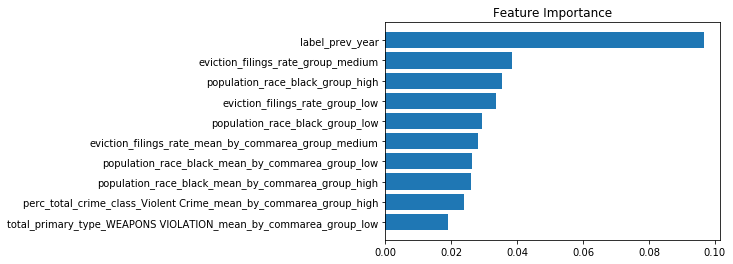

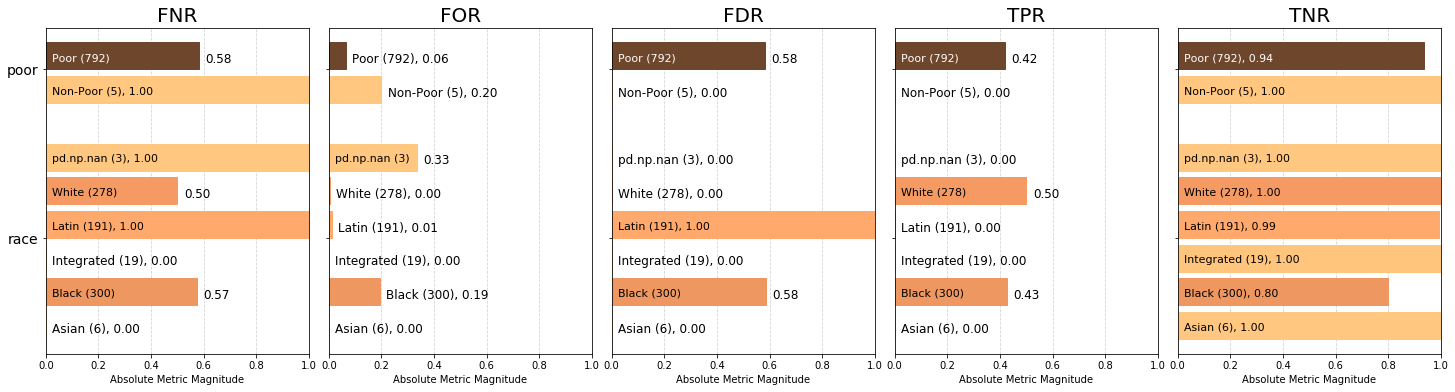

<Figure size 432x288 with 0 Axes>

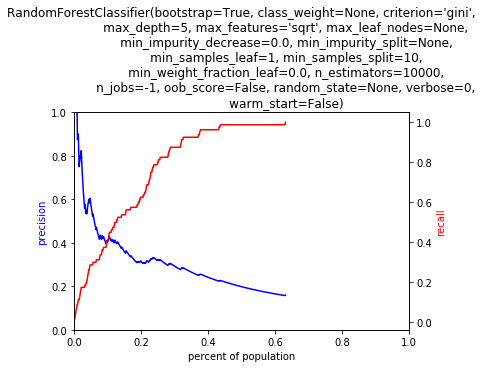

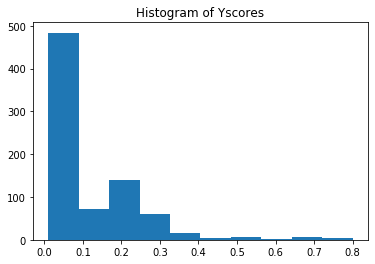

FEATURE IMPORTANCES

1. Feature label_prev_year (0.081773)
2. Feature eviction_filings_rate_group_low (0.030301)
3. Feature population_race_black_group_high (0.027287)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.026198)
5. Feature eviction_filings_rate_group_medium (0.024440)
6. Feature population_race_black_group_low (0.024278)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.023555)
8. Feature population_race_black_mean_by_commarea_group_high (0.023225)
9. Feature population_race_black_mean_by_commarea_group_low (0.021119)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.015231)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          2.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

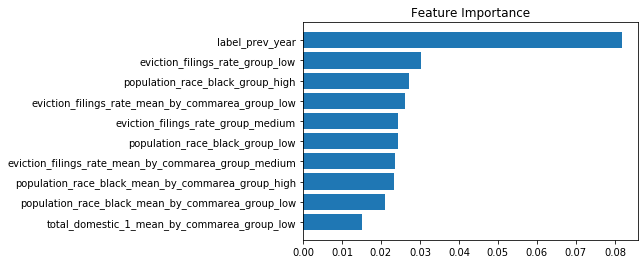

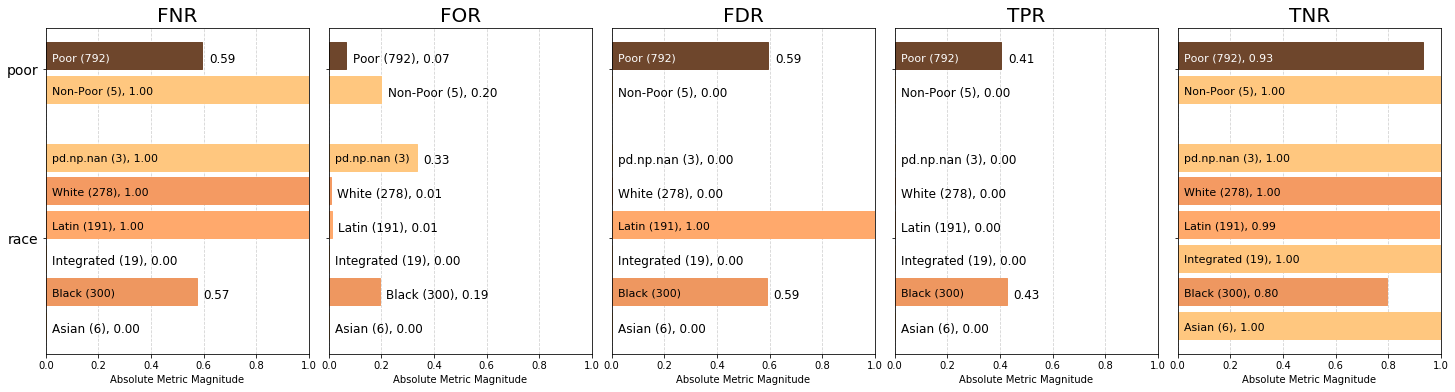

<Figure size 432x288 with 0 Axes>

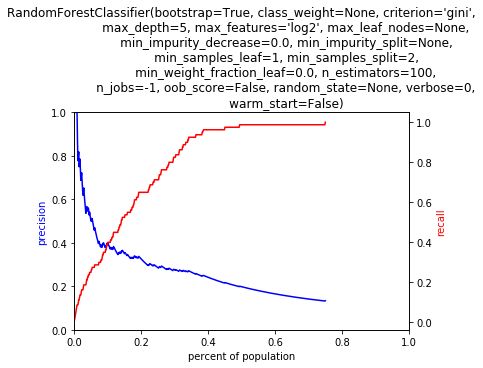

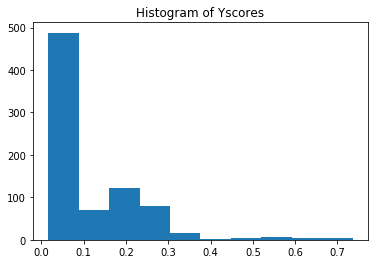

FEATURE IMPORTANCES

1. Feature label_prev_year (0.045295)
2. Feature population_race_black_group_low (0.025889)
3. Feature population_race_black_mean_by_commarea_group_high (0.021601)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.021463)
5. Feature total_crime_class_Violent Crime_group_low (0.018428)
6. Feature population_race_black_mean_by_commarea_group_low (0.017779)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.017070)
8. Feature population_race_black_group_high (0.016487)
9. Feature eviction_filings_rate_group_low (0.015770)
10. Feature ftu_eviction_order_group_low (0.014891)
            score  label_value
race                          
Asian           0          0.0
Black          79         75.0
Integrated      0          0.0
Latin           0          2.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

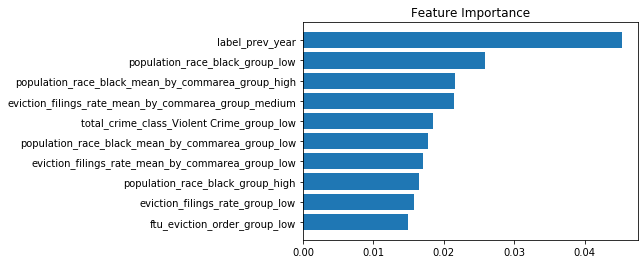

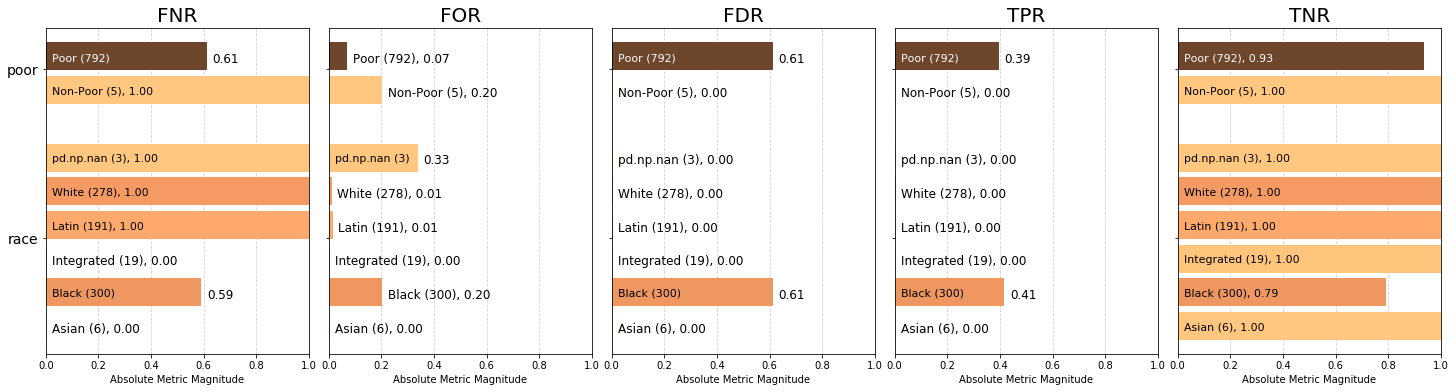

<Figure size 432x288 with 0 Axes>

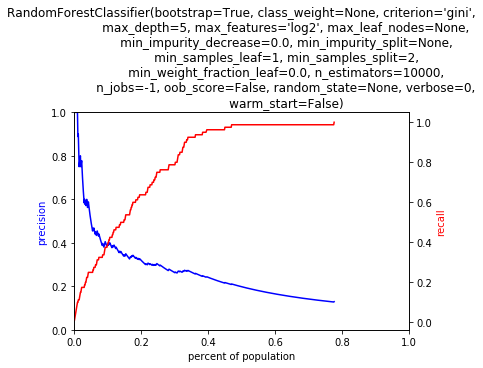

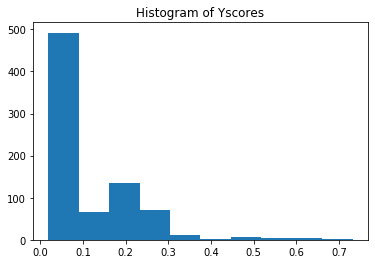

FEATURE IMPORTANCES

1. Feature label_prev_year (0.035119)
2. Feature population_race_black_group_high (0.016377)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.015348)
4. Feature eviction_filings_rate_group_low (0.014609)
5. Feature population_race_black_mean_by_commarea_group_high (0.014080)
6. Feature population_race_black_group_low (0.013601)
7. Feature population_race_black_mean_by_commarea_group_low (0.013215)
8. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.013195)
9. Feature eviction_filings_rate_group_medium (0.012792)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.012248)
            score  label_value
race                          
Asian           0          0.0
Black          79         75.0
Integrated      0          0.0
Latin           0          2.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

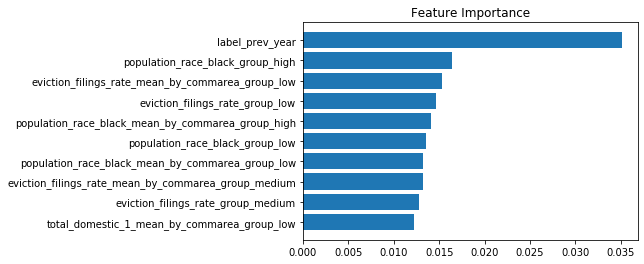

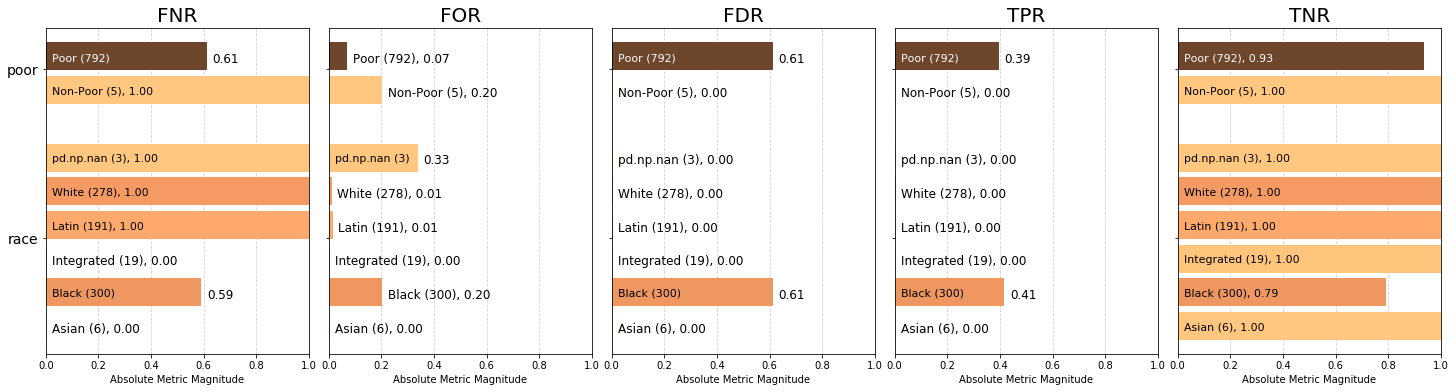

<Figure size 432x288 with 0 Axes>

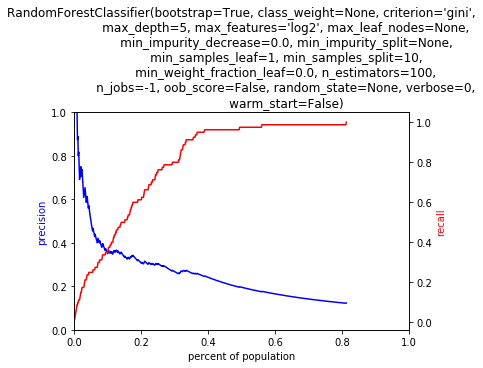

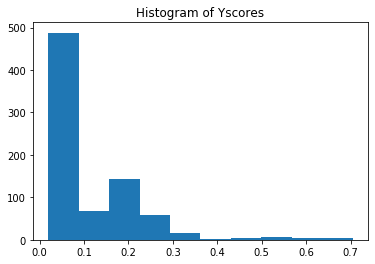

FEATURE IMPORTANCES

1. Feature label_prev_year (0.031764)
2. Feature population_race_black_mean_by_commarea_group_low (0.029493)
3. Feature population_race_black_mean_by_commarea_group_high (0.021246)
4. Feature total_primary_type_ASSAULT_mean_by_commarea_group_medium (0.019345)
5. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_low (0.015988)
6. Feature total_primary_type_ASSAULT_mean_by_commarea_group_low (0.015303)
7. Feature ftu_no_outcome_tenant_prose_group_low (0.014787)
8. Feature ftu_eviction_order_tenant_prose_group_low (0.014487)
9. Feature eviction_order_yes_group_low (0.014440)
10. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.013988)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           1          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

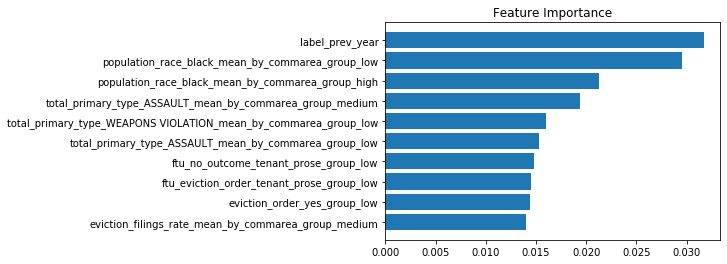

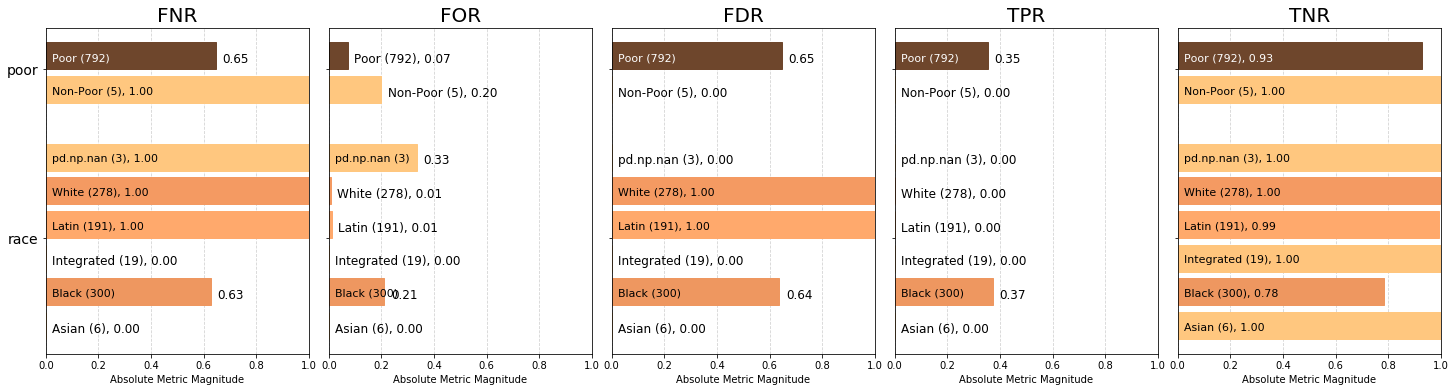

<Figure size 432x288 with 0 Axes>

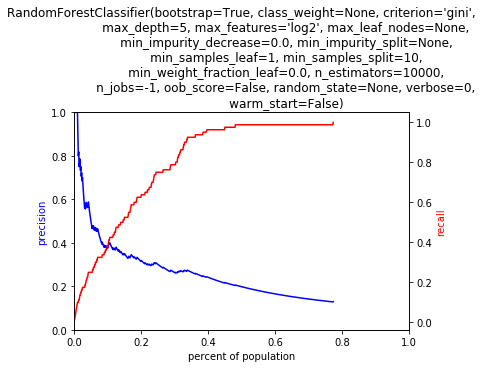

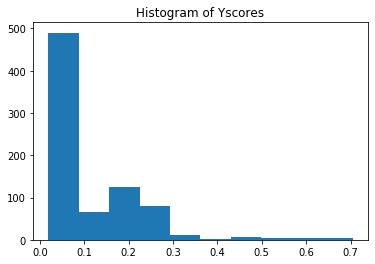

FEATURE IMPORTANCES

1. Feature label_prev_year (0.034621)
2. Feature eviction_filings_rate_mean_by_commarea_group_low (0.015776)
3. Feature eviction_filings_rate_group_low (0.015297)
4. Feature population_race_black_group_high (0.015292)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.014824)
6. Feature population_race_black_group_low (0.014409)
7. Feature population_race_black_mean_by_commarea_group_high (0.014229)
8. Feature eviction_filings_rate_group_medium (0.014019)
9. Feature population_race_black_mean_by_commarea_group_low (0.013727)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.011470)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           0          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

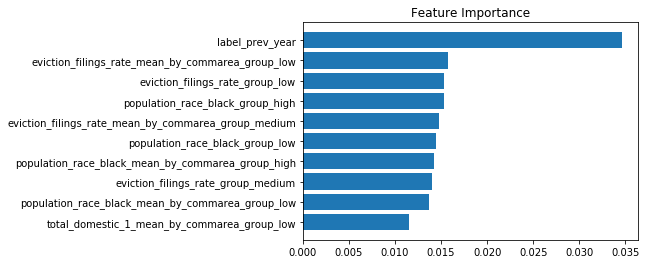

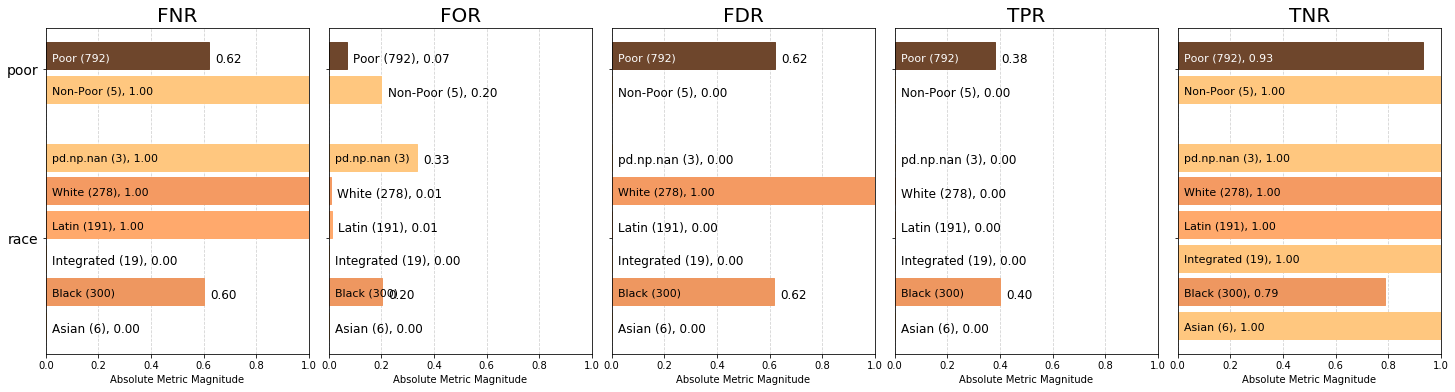

<Figure size 432x288 with 0 Axes>

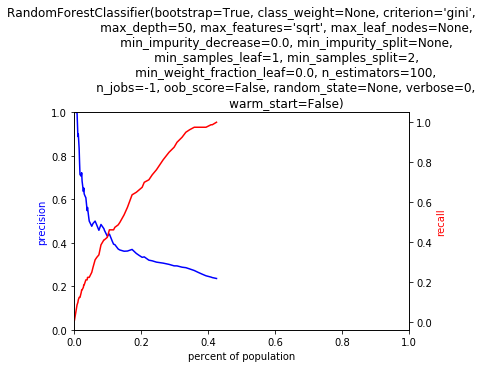

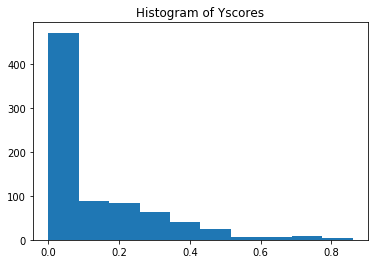

FEATURE IMPORTANCES

1. Feature label_prev_year (0.050984)
2. Feature eviction_filings_rate_group_low (0.015204)
3. Feature eviction_filings_rate_group_medium (0.011391)
4. Feature some_college_group_medium (0.009844)
5. Feature population_race_black_mean_by_commarea_group_high (0.009388)
6. Feature population_race_black_mean_by_commarea_group_low (0.009345)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008418)
8. Feature perc_total_crime_class_Property Crime_group_low (0.008254)
9. Feature total_violation_status_OPEN_perc_group_medium (0.007549)
10. Feature high_school_grad_group_medium (0.007523)
            score  label_value
race                          
Asian           0          0.0
Black          76         75.0
Integrated      0          0.0
Latin           2          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

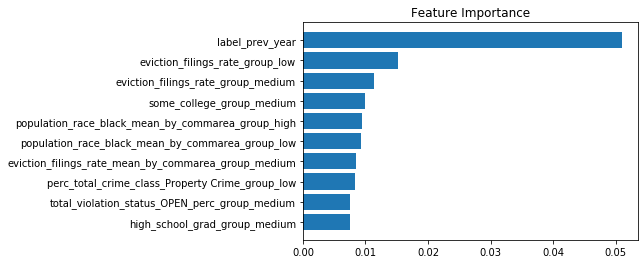

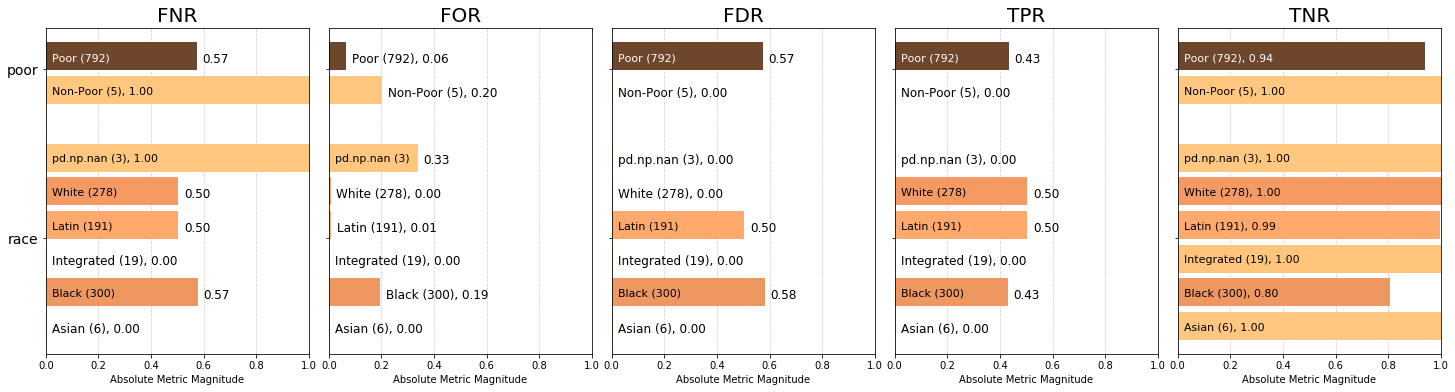

<Figure size 432x288 with 0 Axes>

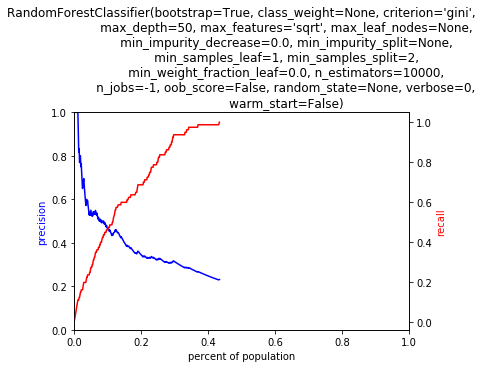

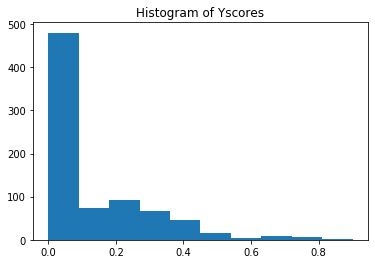

FEATURE IMPORTANCES

1. Feature label_prev_year (0.050808)
2. Feature eviction_filings_rate_group_low (0.015114)
3. Feature eviction_filings_rate_group_medium (0.012359)
4. Feature population_race_black_group_high (0.010820)
5. Feature some_college_group_medium (0.009562)
6. Feature eviction_filings_rate_mean_by_commarea_group_low (0.008356)
7. Feature population_race_black_group_low (0.008108)
8. Feature some_college_group_high (0.007699)
9. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.007516)
10. Feature population_race_black_mean_by_commarea_group_high (0.007440)
            score  label_value
race                          
Asian           0          0.0
Black          75         75.0
Integrated      0          0.0
Latin           2          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

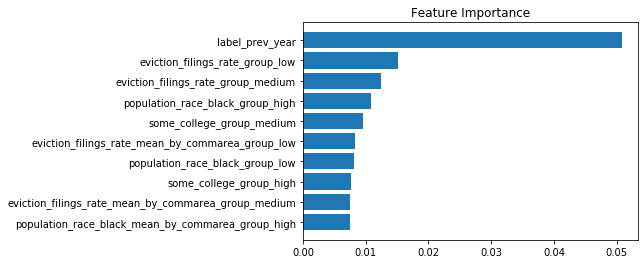

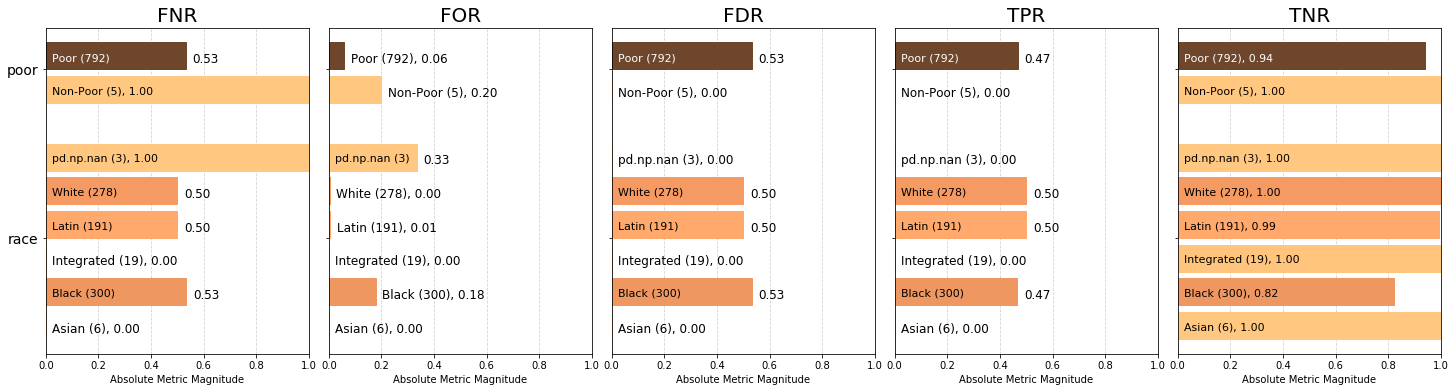

<Figure size 432x288 with 0 Axes>

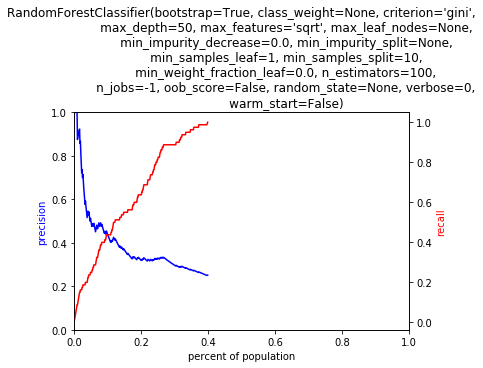

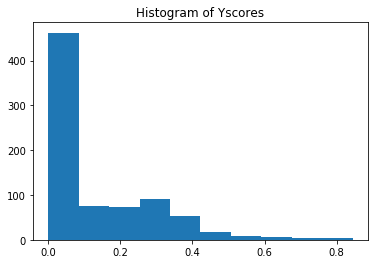

FEATURE IMPORTANCES

1. Feature label_prev_year (0.061525)
2. Feature population_race_black_group_high (0.026741)
3. Feature eviction_filings_rate_group_low (0.023555)
4. Feature eviction_filings_rate_group_medium (0.018565)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.018135)
6. Feature population_race_black_mean_by_commarea_group_high (0.013640)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.009186)
8. Feature population_race_black_group_low (0.008240)
9. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.007538)
10. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_low (0.007531)
            score  label_value
race                          
Asian           0          0.0
Black          76         75.0
Integrated      0          0.0
Latin           2          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

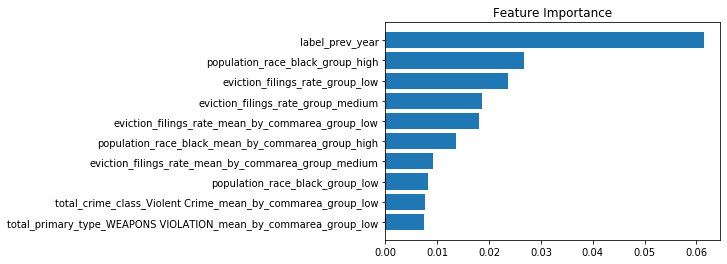

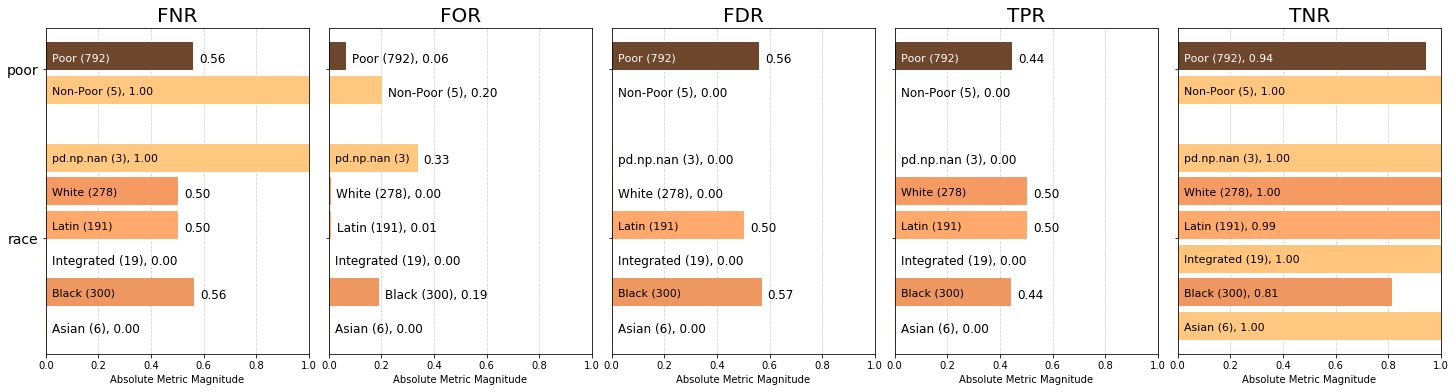

<Figure size 432x288 with 0 Axes>

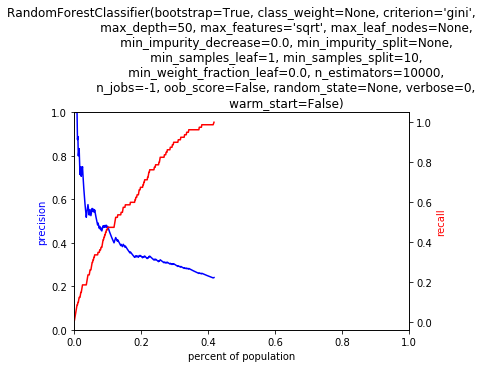

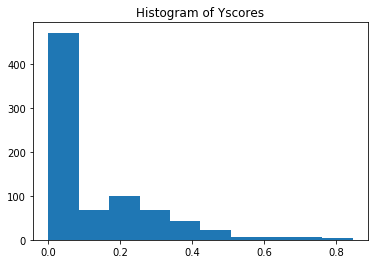

FEATURE IMPORTANCES

1. Feature label_prev_year (0.071693)
2. Feature eviction_filings_rate_group_low (0.022777)
3. Feature eviction_filings_rate_group_medium (0.017757)
4. Feature population_race_black_group_high (0.015149)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.012884)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.011624)
7. Feature population_race_black_mean_by_commarea_group_high (0.011467)
8. Feature population_race_black_group_low (0.011444)
9. Feature population_race_black_mean_by_commarea_group_low (0.009171)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.007654)
            score  label_value
race                          
Asian           0          0.0
Black          75         75.0
Integrated      0          0.0
Latin           2          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

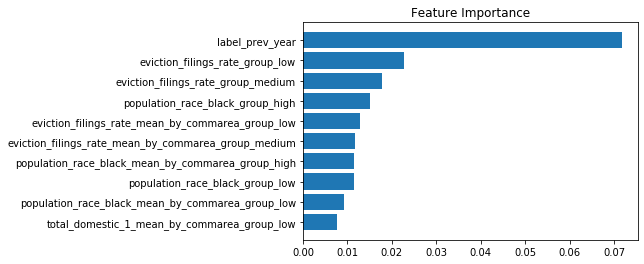

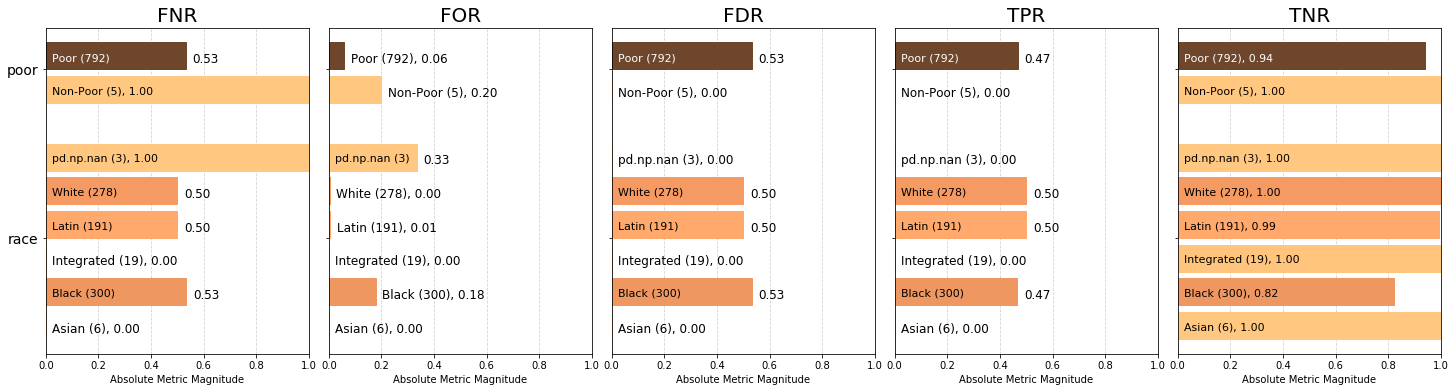

<Figure size 432x288 with 0 Axes>

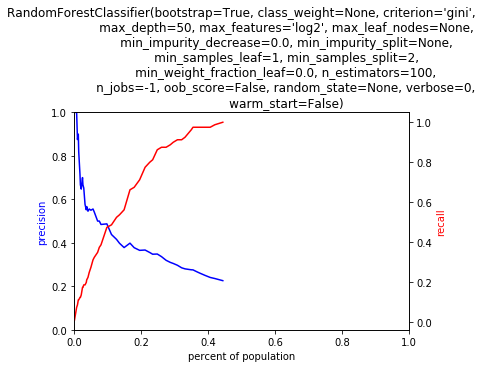

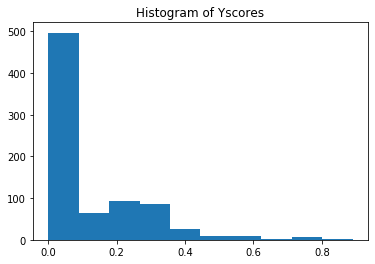

FEATURE IMPORTANCES

1. Feature label_prev_year (0.026882)
2. Feature some_college_group_medium (0.011104)
3. Feature eviction_filings_rate_group_low (0.010924)
4. Feature population_race_black_group_high (0.009493)
5. Feature high_school_grad_group_medium (0.008848)
6. Feature total_violation_status_COMPLIED_perc_group_medium (0.008599)
7. Feature some_college_group_high (0.008534)
8. Feature perc_increase_total_crime_class_Less serious offences_group_medium (0.008068)
9. Feature perc_total_crime_class_Property Crime_group_medium (0.007969)
10. Feature population_poverty_below_group_medium (0.007869)
            score  label_value
race                          
Asian           0          0.0
Black          74         75.0
Integrated      0          0.0
Latin           3          2.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

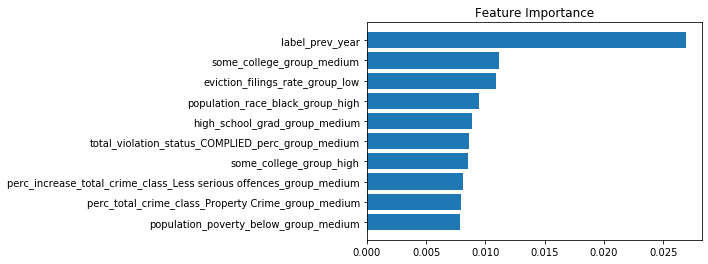

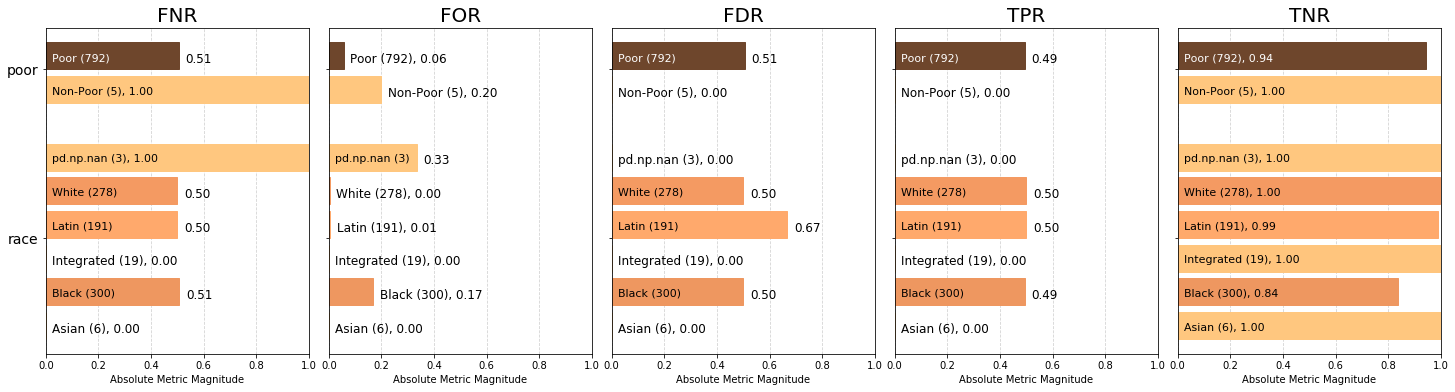

<Figure size 432x288 with 0 Axes>

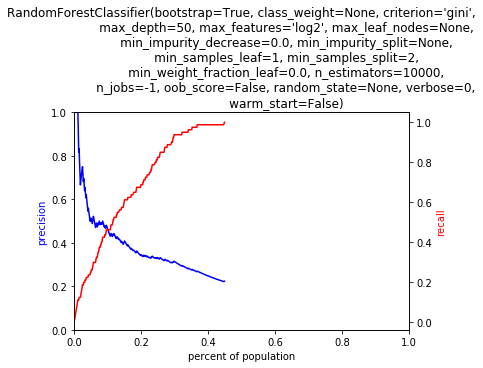

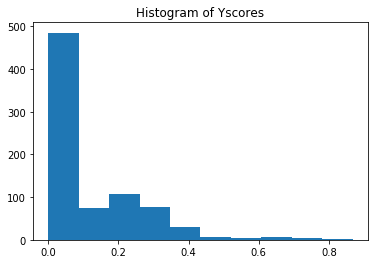

FEATURE IMPORTANCES

1. Feature label_prev_year (0.028973)
2. Feature some_college_group_medium (0.010528)
3. Feature eviction_filings_rate_group_low (0.010012)
4. Feature some_college_group_high (0.008382)
5. Feature eviction_filings_rate_group_medium (0.008212)
6. Feature high_school_grad_group_medium (0.008089)
7. Feature perc_total_crime_class_Property Crime_group_low (0.007962)
8. Feature total_violation_status_COMPLIED_perc_group_medium (0.007867)
9. Feature total_violation_status_OPEN_perc_group_medium (0.007852)
10. Feature not_highschool_grad_group_medium (0.007840)
            score  label_value
race                          
Asian           0          0.0
Black          76         75.0
Integrated      0          0.0
Latin           2          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

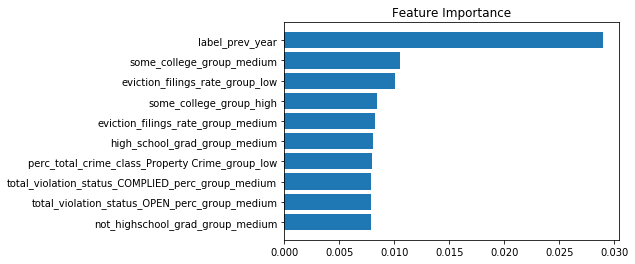

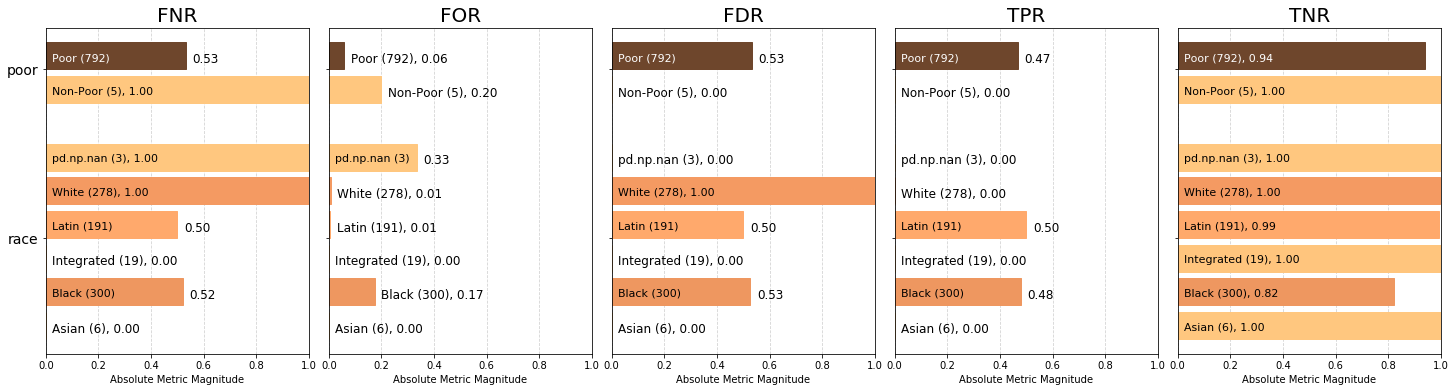

<Figure size 432x288 with 0 Axes>

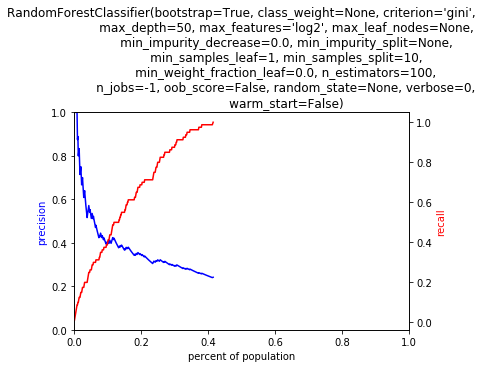

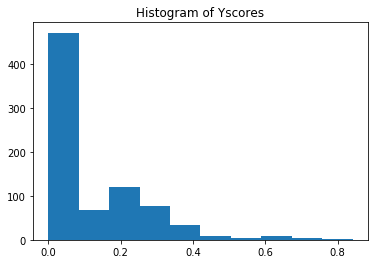

FEATURE IMPORTANCES

1. Feature label_prev_year (0.037389)
2. Feature eviction_filings_rate_group_medium (0.019735)
3. Feature eviction_filings_rate_group_low (0.015246)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.011322)
5. Feature population_race_black_group_high (0.011029)
6. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.008179)
7. Feature population_race_black_mean_by_commarea_group_high (0.007126)
8. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.006990)
9. Feature total_arrest_1_mean_by_commarea_group_medium (0.006495)
10. Feature population_poverty_below_group_low (0.006281)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           2          2.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

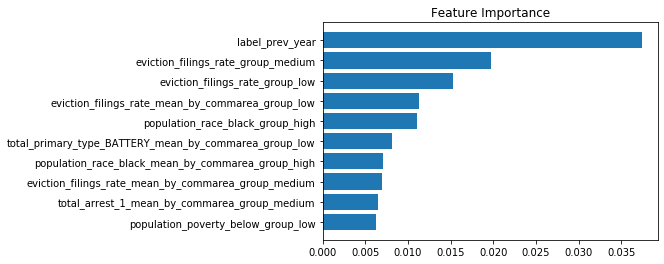

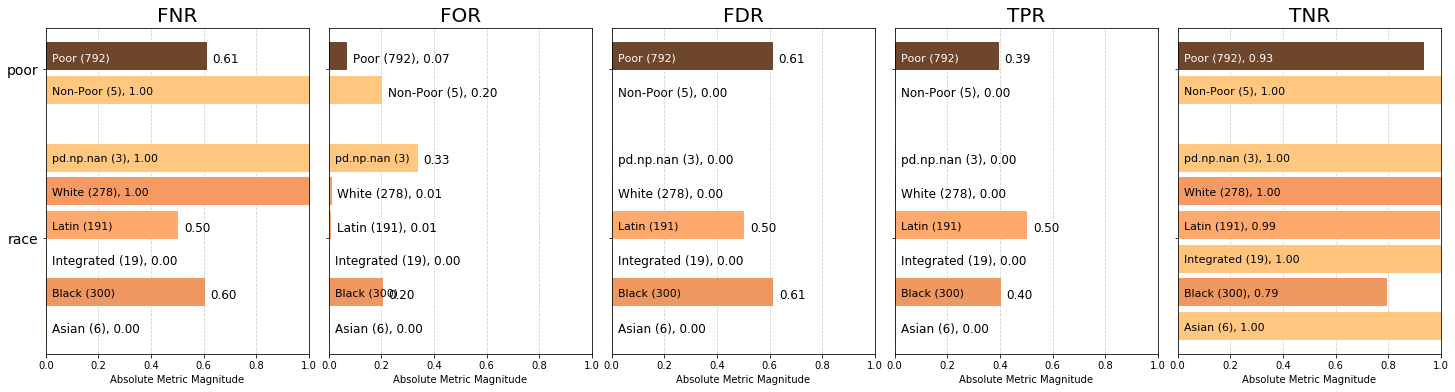

<Figure size 432x288 with 0 Axes>

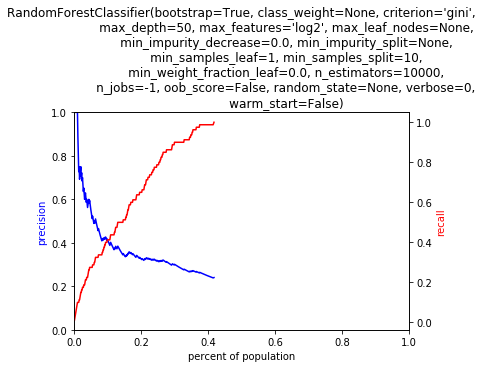

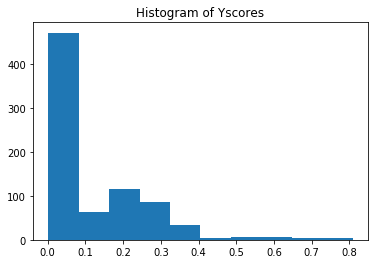

FEATURE IMPORTANCES

1. Feature label_prev_year (0.040068)
2. Feature eviction_filings_rate_group_low (0.015115)
3. Feature eviction_filings_rate_group_medium (0.012641)
4. Feature population_race_black_group_high (0.010712)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.009508)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008828)
7. Feature population_race_black_group_low (0.008161)
8. Feature population_race_black_mean_by_commarea_group_high (0.007961)
9. Feature population_race_black_mean_by_commarea_group_low (0.006609)
10. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.005653)
            score  label_value
race                          
Asian           0          0.0
Black          76         75.0
Integrated      0          0.0
Latin           2          2.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

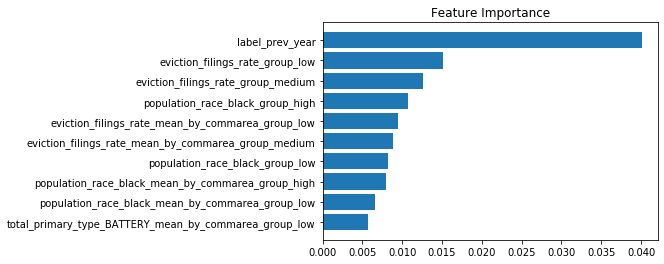

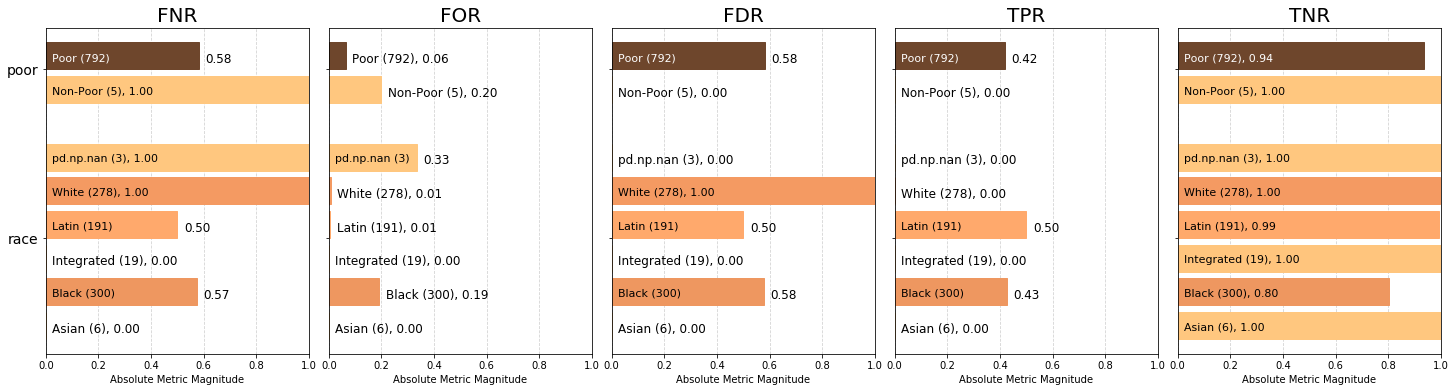

RF


<Figure size 432x288 with 0 Axes>

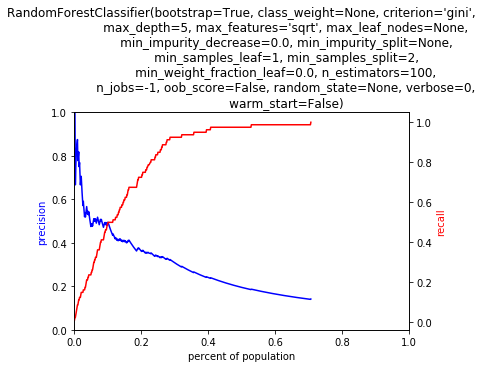

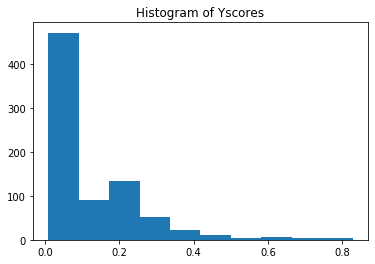

FEATURE IMPORTANCES

1. Feature label_prev_year (0.076904)
2. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.048513)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.028746)
4. Feature population_race_black_mean_by_commarea_group_high (0.027285)
5. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.027058)
6. Feature population_race_black_group_high (0.025603)
7. Feature eviction_filings_rate_group_medium (0.024561)
8. Feature population_race_black_group_low (0.021617)
9. Feature eviction_filings_rate_group_low (0.018682)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.017840)
            score  label_value
race                          
Asian           0          0.0
Black          79         74.0
Integrated      0          0.0
Latin           0          4.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

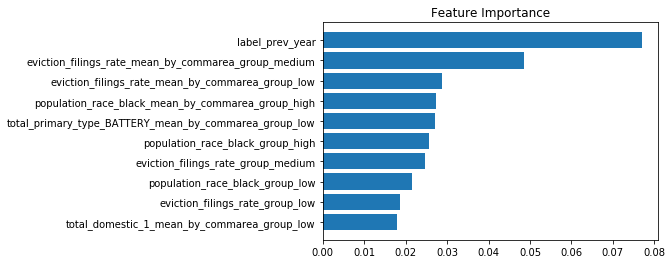

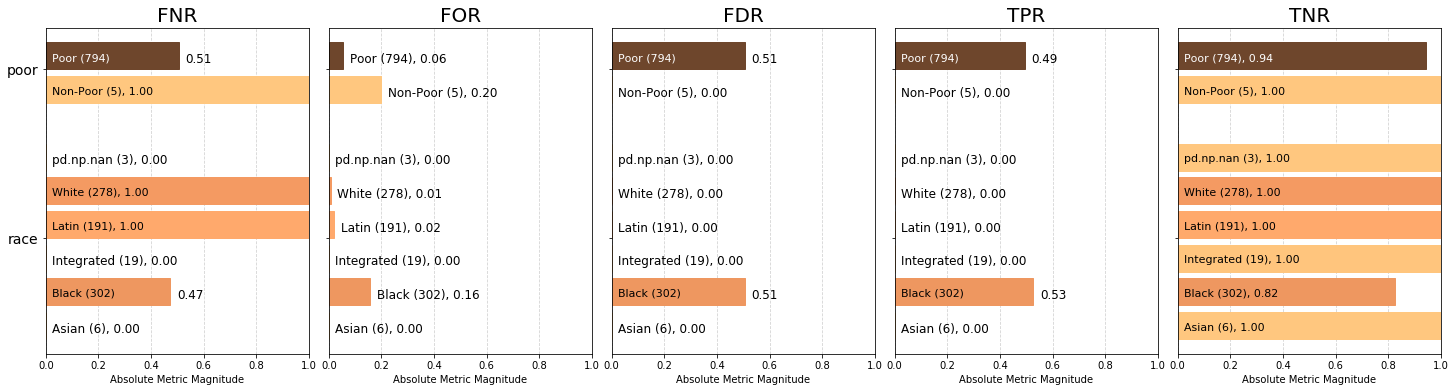

<Figure size 432x288 with 0 Axes>

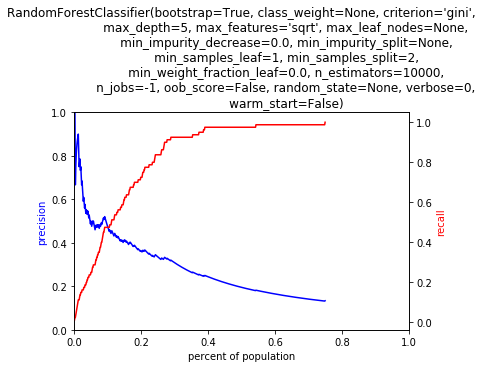

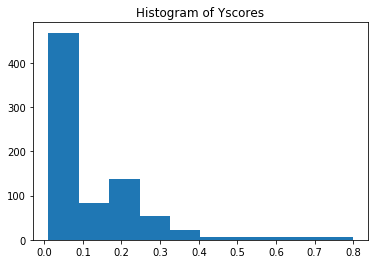

FEATURE IMPORTANCES

1. Feature label_prev_year (0.079957)
2. Feature population_race_black_group_high (0.031721)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.026558)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.024991)
5. Feature population_race_black_group_low (0.024664)
6. Feature eviction_filings_rate_group_low (0.023535)
7. Feature population_race_black_mean_by_commarea_group_high (0.022528)
8. Feature population_race_black_mean_by_commarea_group_low (0.020407)
9. Feature total_domestic_1_mean_by_commarea_group_low (0.017600)
10. Feature eviction_filings_rate_group_medium (0.016477)
            score  label_value
race                          
Asian           0          0.0
Black          79         74.0
Integrated      0          0.0
Latin           0          4.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

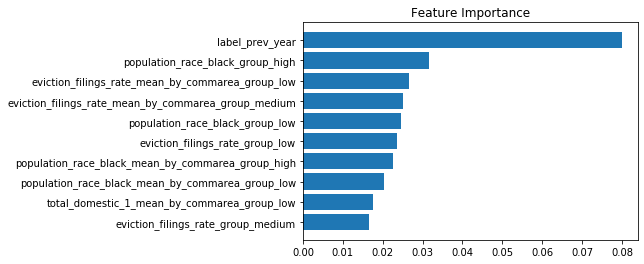

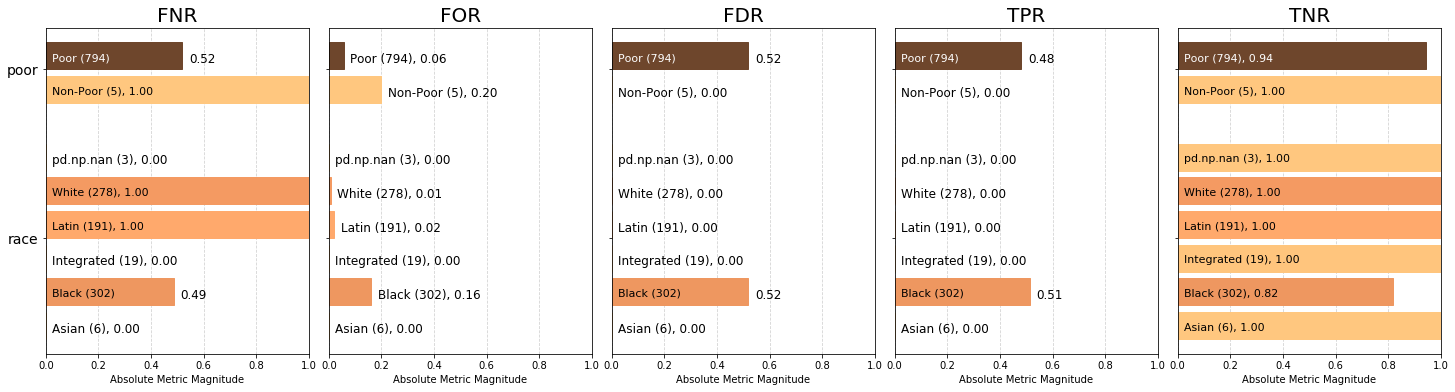

<Figure size 432x288 with 0 Axes>

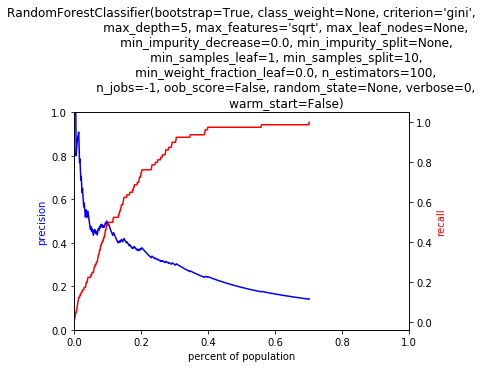

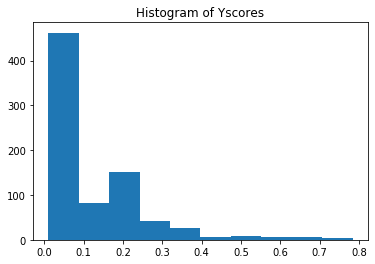

FEATURE IMPORTANCES

1. Feature label_prev_year (0.075895)
2. Feature population_race_black_mean_by_commarea_group_low (0.040334)
3. Feature total_primary_type_ROBBERY_mean_by_commarea_group_low (0.036839)
4. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.035865)
5. Feature population_race_black_group_high (0.030562)
6. Feature population_race_black_group_low (0.027685)
7. Feature eviction_filings_rate_group_low (0.025828)
8. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.022659)
9. Feature population_race_black_mean_by_commarea_group_high (0.022025)
10. Feature total_crime_class_Less serious offences_mean_by_commarea_group_low (0.018273)
            score  label_value
race                          
Asian           0          0.0
Black          78         74.0
Integrated      0          0.0
Latin           0          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

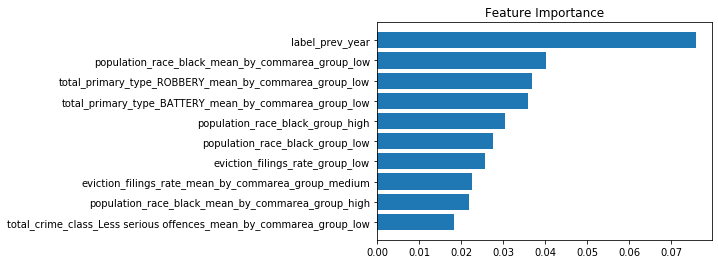

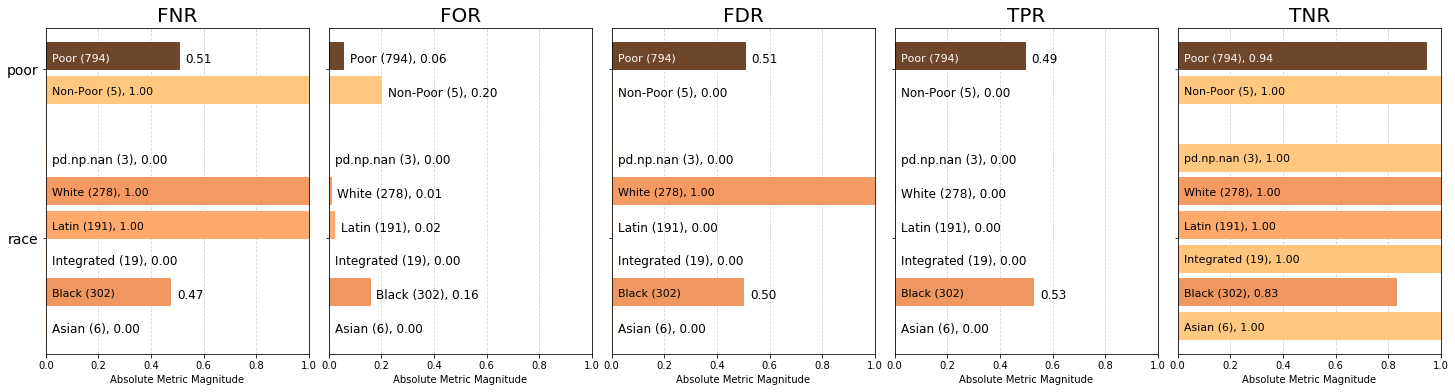

<Figure size 432x288 with 0 Axes>

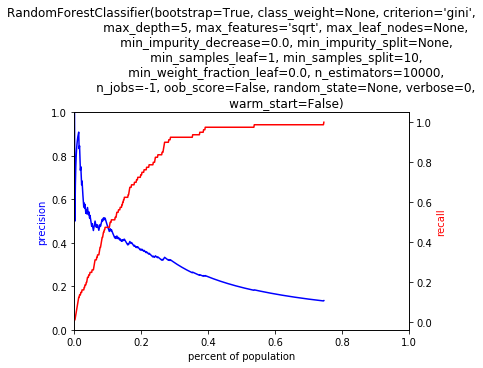

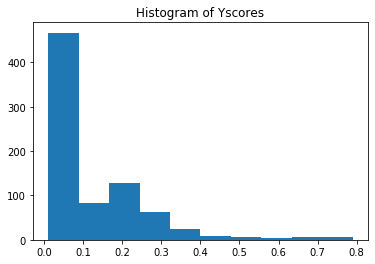

FEATURE IMPORTANCES

1. Feature label_prev_year (0.080981)
2. Feature population_race_black_group_high (0.031234)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.030362)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.027667)
5. Feature population_race_black_group_low (0.026057)
6. Feature population_race_black_mean_by_commarea_group_high (0.024594)
7. Feature eviction_filings_rate_group_low (0.023721)
8. Feature population_race_black_mean_by_commarea_group_low (0.021885)
9. Feature eviction_filings_rate_group_medium (0.018235)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.017358)
            score  label_value
race                          
Asian           0          0.0
Black          79         74.0
Integrated      0          0.0
Latin           0          4.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

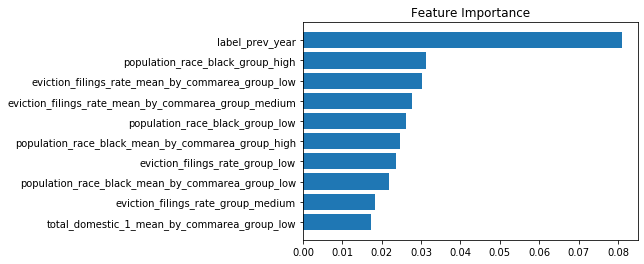

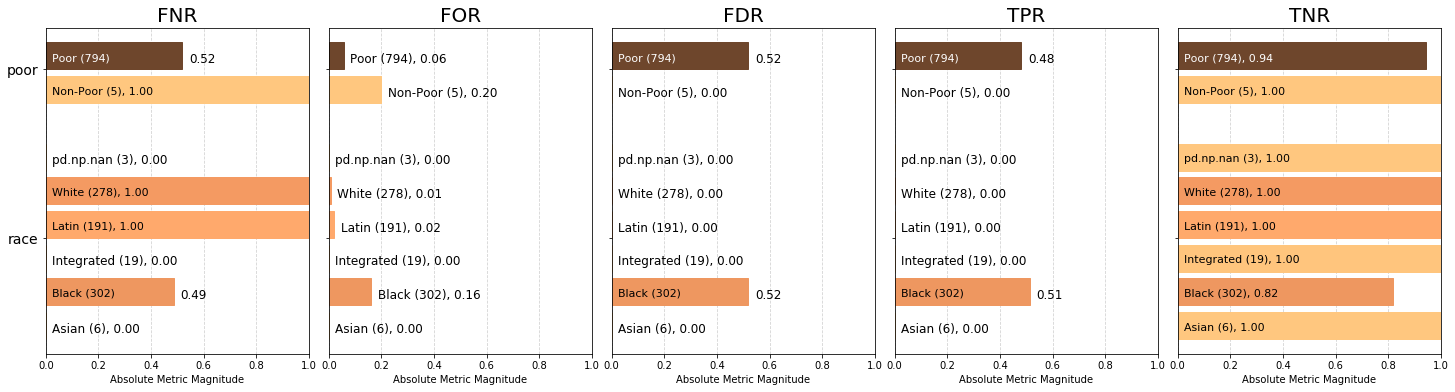

<Figure size 432x288 with 0 Axes>

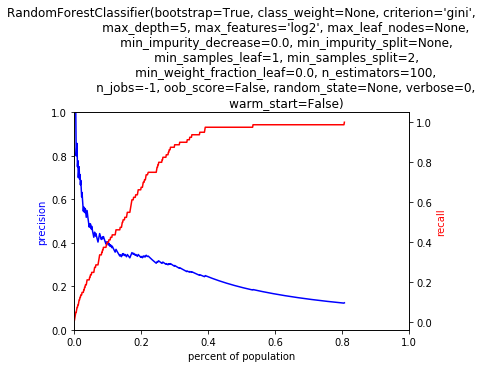

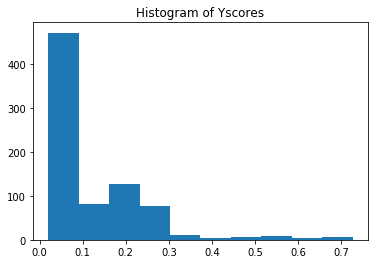

FEATURE IMPORTANCES

1. Feature population_race_black_mean_by_commarea_group_high (0.022994)
2. Feature label_prev_year (0.021190)
3. Feature perc_total_crime_class_Violent Crime_mean_by_commarea_group_high (0.020125)
4. Feature total_primary_type_ROBBERY_mean_by_commarea_group_medium (0.019667)
5. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.018304)
6. Feature population_race_black_group_low (0.015844)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.015450)
8. Feature eviction_filings_rate_group_low (0.015063)
9. Feature default_eviction_order_no_group_medium (0.014519)
10. Feature ftu_eviction_order_group_low (0.014182)
            score  label_value
race                          
Asian           0          0.0
Black          79         74.0
Integrated      0          0.0
Latin           0          4.0
White           0          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

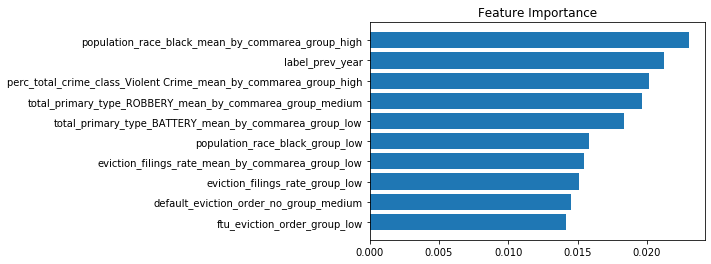

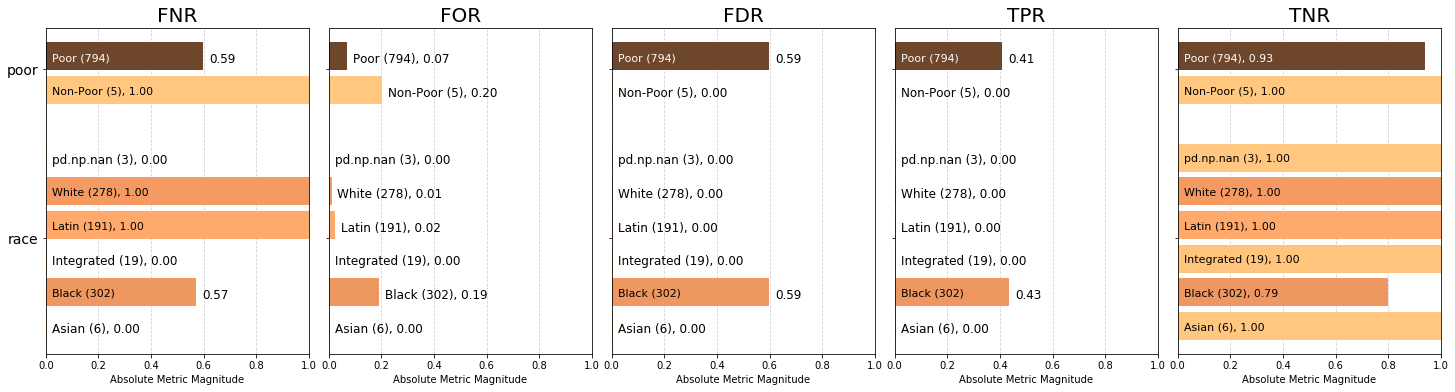

<Figure size 432x288 with 0 Axes>

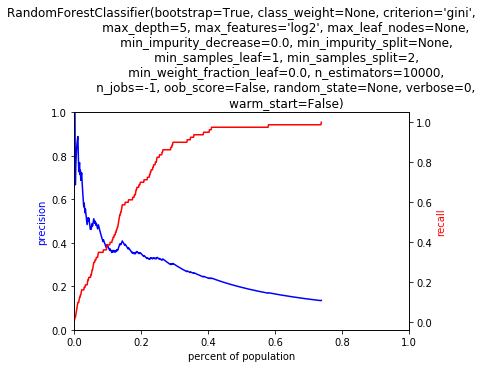

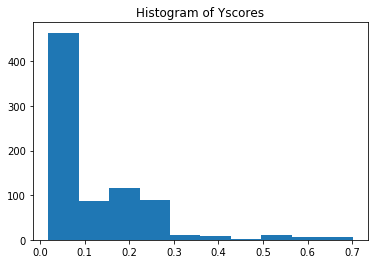

FEATURE IMPORTANCES

1. Feature label_prev_year (0.034210)
2. Feature population_race_black_group_high (0.017858)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.016471)
4. Feature population_race_black_mean_by_commarea_group_high (0.015627)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.014690)
6. Feature population_race_black_group_low (0.014412)
7. Feature population_race_black_mean_by_commarea_group_low (0.013467)
8. Feature eviction_filings_rate_group_low (0.012521)
9. Feature total_domestic_1_mean_by_commarea_group_low (0.010819)
10. Feature total_primary_type_ROBBERY_mean_by_commarea_group_medium (0.010416)
            score  label_value
race                          
Asian           0          0.0
Black          78         74.0
Integrated      0          0.0
Latin           0          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

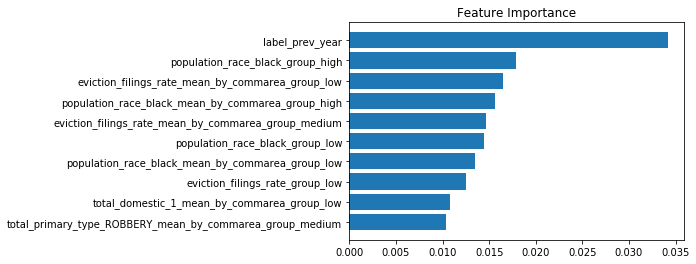

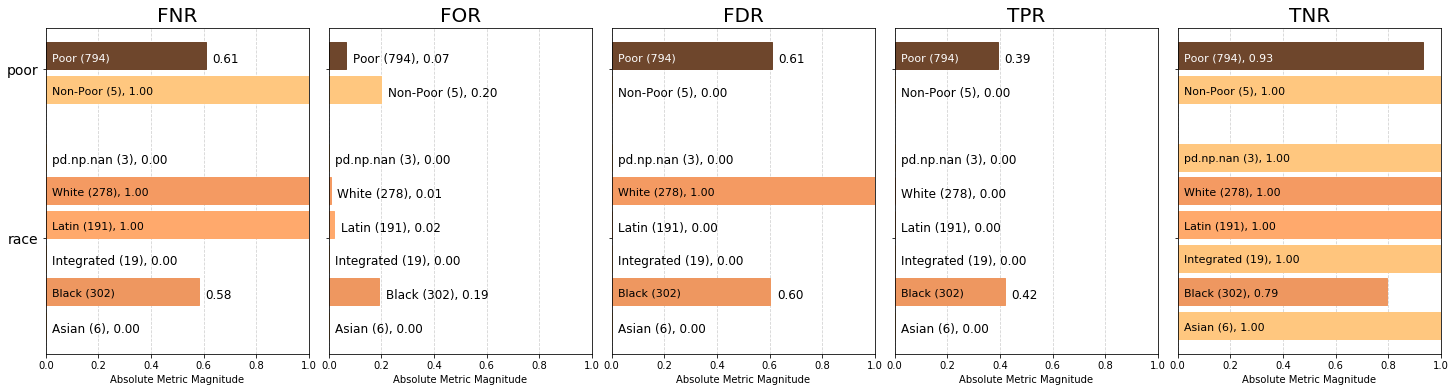

<Figure size 432x288 with 0 Axes>

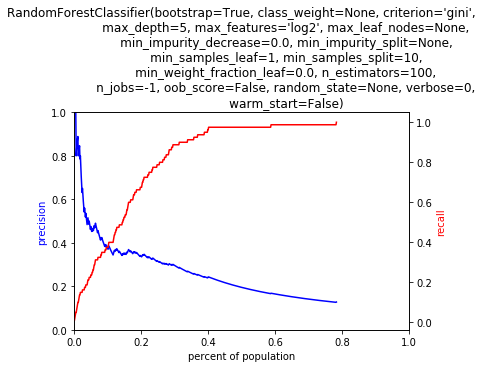

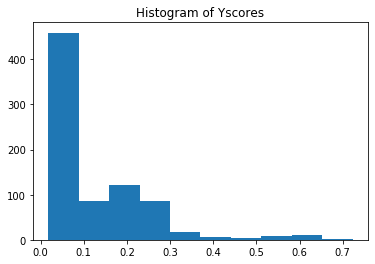

FEATURE IMPORTANCES

1. Feature total_primary_type_ASSAULT_mean_by_commarea_group_low (0.028322)
2. Feature label_prev_year (0.028126)
3. Feature total_crime_class_Less serious offences_mean_by_commarea_group_low (0.026578)
4. Feature population_race_black_mean_by_commarea_group_high (0.022421)
5. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.021328)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.019598)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.019015)
8. Feature total_primary_type_ASSAULT_mean_by_commarea_group_medium (0.017199)
9. Feature total_primary_type_ROBBERY_mean_by_commarea_group_low (0.017117)
10. Feature eviction_filings_rate_group_low (0.017065)
            score  label_value
race                          
Asian           0          0.0
Black          78         74.0
Integrated      0          0.0
Latin           0          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

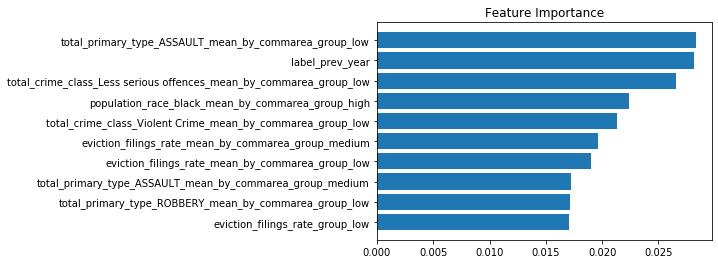

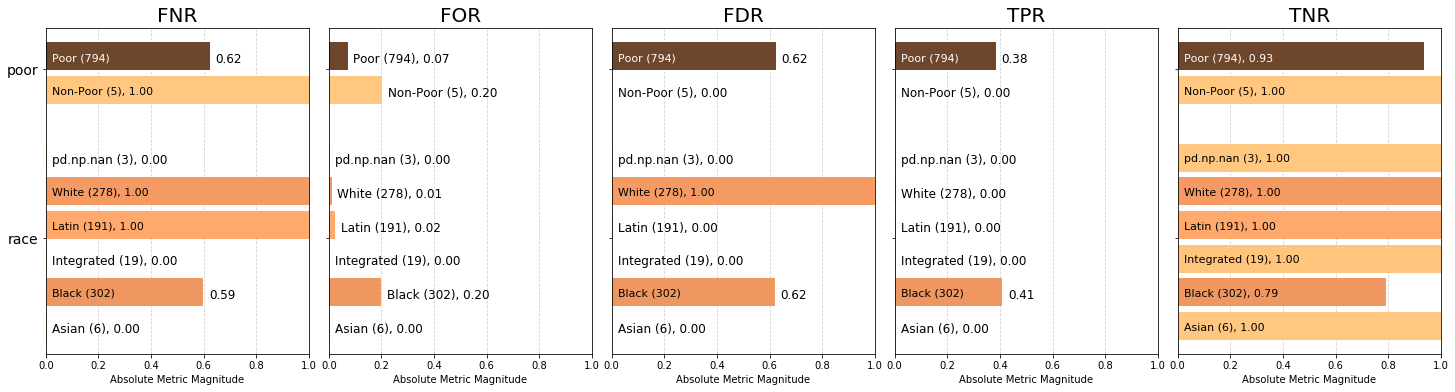

<Figure size 432x288 with 0 Axes>

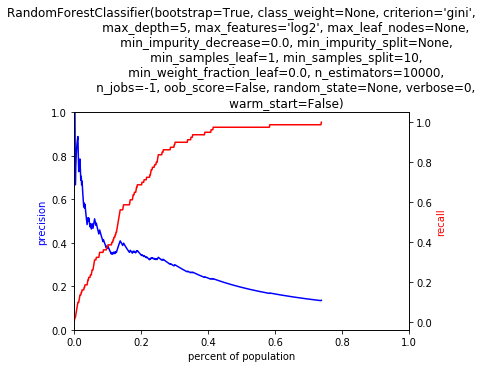

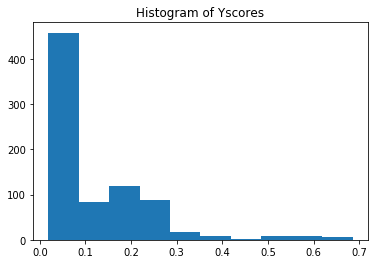

FEATURE IMPORTANCES

1. Feature label_prev_year (0.034657)
2. Feature population_race_black_group_high (0.017371)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.016112)
4. Feature population_race_black_group_low (0.015343)
5. Feature population_race_black_mean_by_commarea_group_high (0.014914)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.014160)
7. Feature population_race_black_mean_by_commarea_group_low (0.013642)
8. Feature eviction_filings_rate_group_low (0.012339)
9. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.011094)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.011012)
            score  label_value
race                          
Asian           0          0.0
Black          78         74.0
Integrated      0          0.0
Latin           0          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

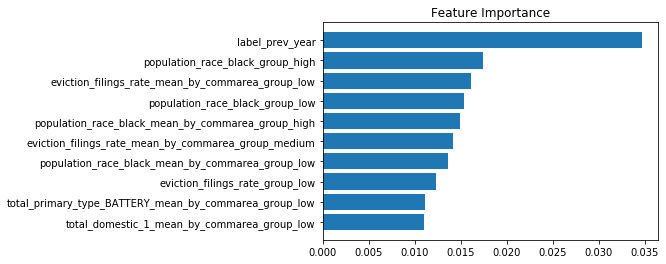

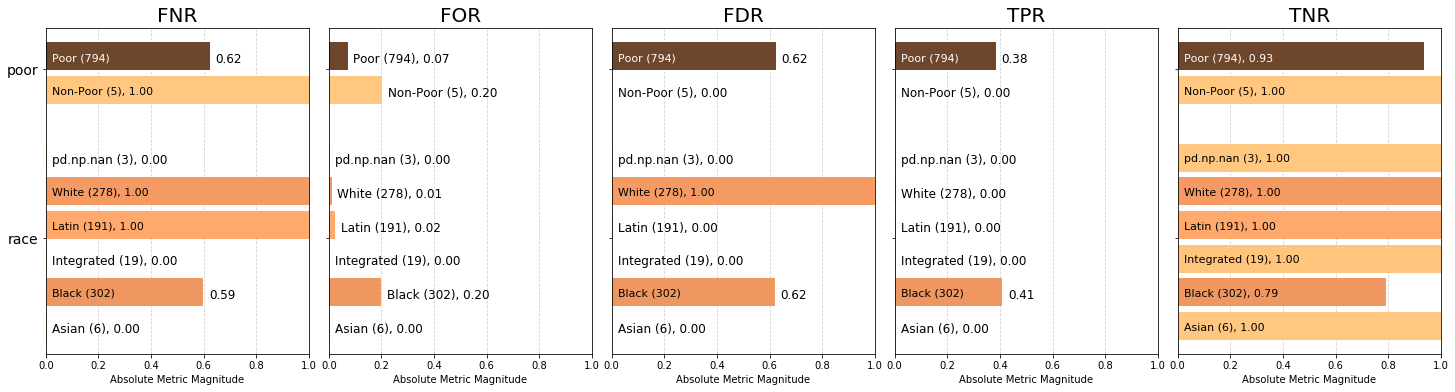

<Figure size 432x288 with 0 Axes>

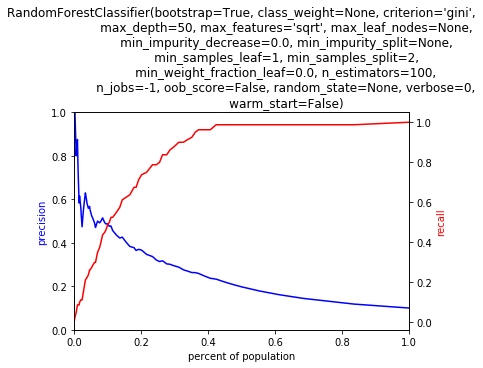

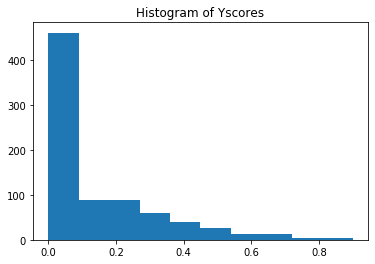

FEATURE IMPORTANCES

1. Feature label_prev_year (0.052868)
2. Feature eviction_filings_rate_mean_by_commarea_group_low (0.011985)
3. Feature eviction_filings_rate_group_low (0.011348)
4. Feature population_race_black_group_high (0.010871)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.010706)
6. Feature some_college_group_medium (0.010179)
7. Feature population_race_black_mean_by_commarea_group_high (0.008777)
8. Feature eviction_filings_rate_group_medium (0.008452)
9. Feature perc_total_crime_class_Property Crime_group_medium (0.007790)
10. Feature not_highschool_grad_group_low (0.007574)
            score  label_value
race                          
Asian           0          0.0
Black          75         74.0
Integrated      0          0.0
Latin           2          4.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

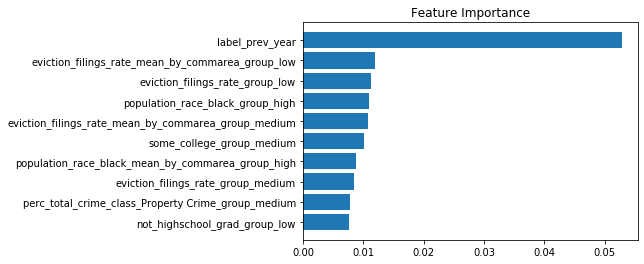

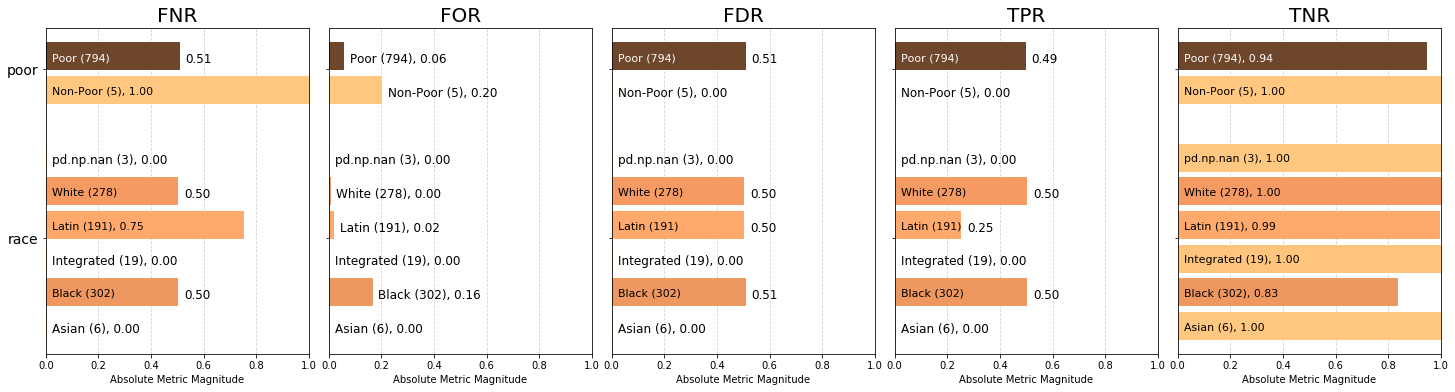

<Figure size 432x288 with 0 Axes>

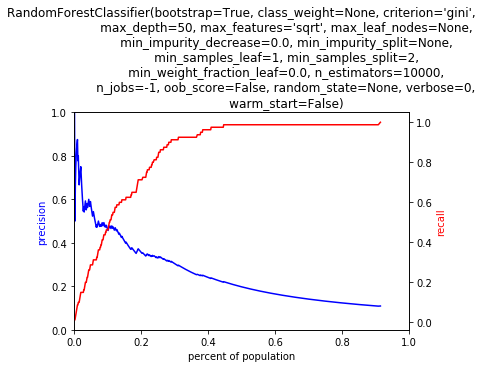

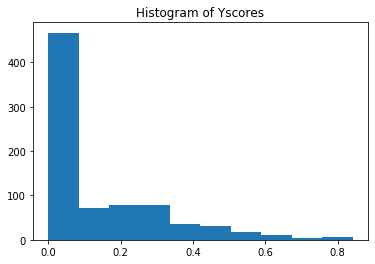

FEATURE IMPORTANCES

1. Feature label_prev_year (0.047500)
2. Feature eviction_filings_rate_group_low (0.011970)
3. Feature population_race_black_group_high (0.011229)
4. Feature some_college_group_medium (0.009874)
5. Feature eviction_filings_rate_group_medium (0.009328)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008436)
7. Feature population_race_black_group_low (0.008389)
8. Feature eviction_filings_rate_mean_by_commarea_group_low (0.008277)
9. Feature some_college_group_high (0.007943)
10. Feature high_school_grad_group_medium (0.007776)
            score  label_value
race                          
Asian           0          0.0
Black          75         74.0
Integrated      0          0.0
Latin           2          4.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

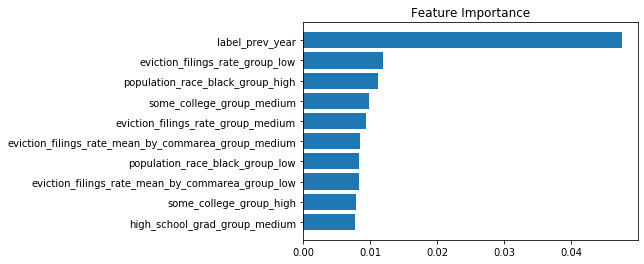

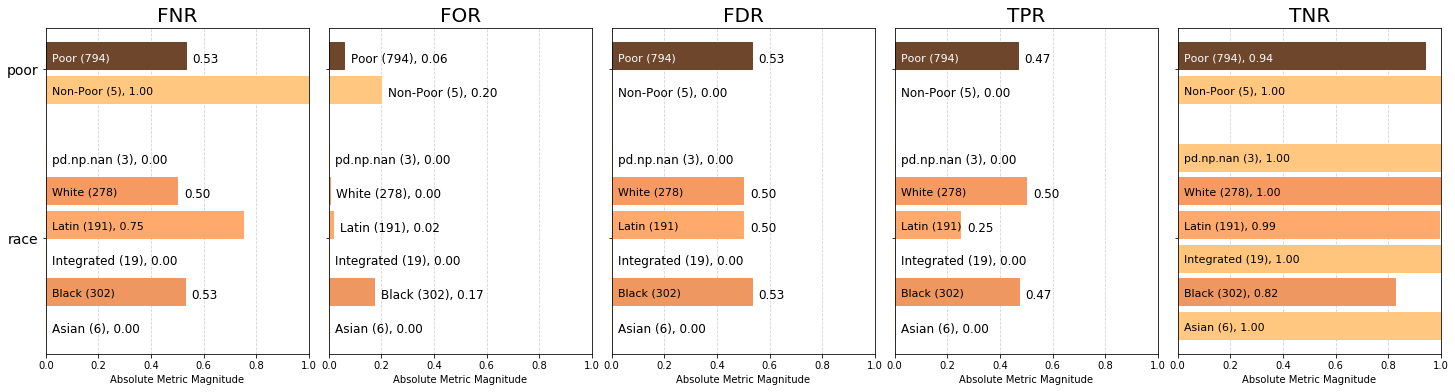

<Figure size 432x288 with 0 Axes>

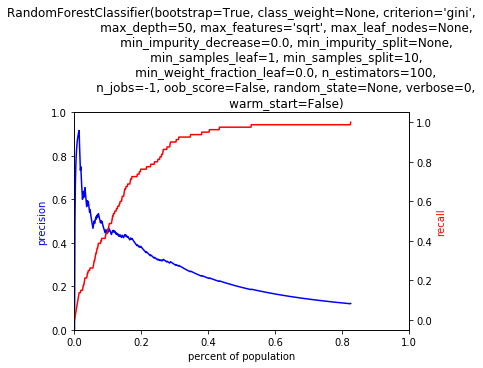

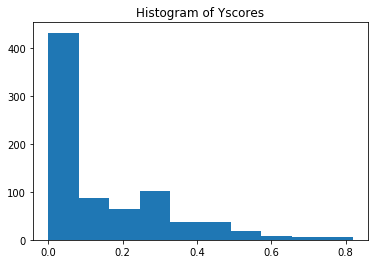

FEATURE IMPORTANCES

1. Feature label_prev_year (0.069601)
2. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.017703)
3. Feature eviction_filings_rate_group_low (0.017057)
4. Feature eviction_filings_rate_group_medium (0.013806)
5. Feature population_race_black_group_high (0.013507)
6. Feature total_primary_type_ASSAULT_mean_by_commarea_group_medium (0.011865)
7. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.011414)
8. Feature perc_total_crime_class_Violent Crime_mean_by_commarea_group_high (0.010276)
9. Feature total_domestic_1_mean_by_commarea_group_low (0.010227)
10. Feature perc_total_crime_class_Property Crime_mean_by_commarea_group_low (0.008766)
            score  label_value
race                          
Asian           0          0.0
Black          75         74.0
Integrated      0          0.0
Latin           2          4.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

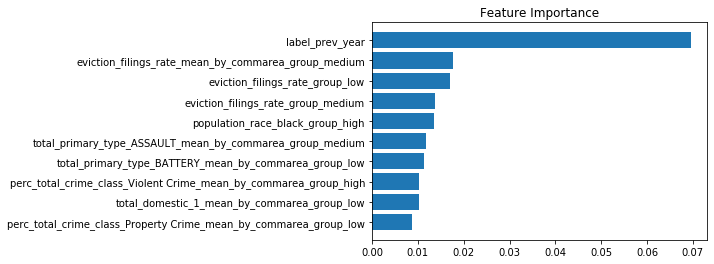

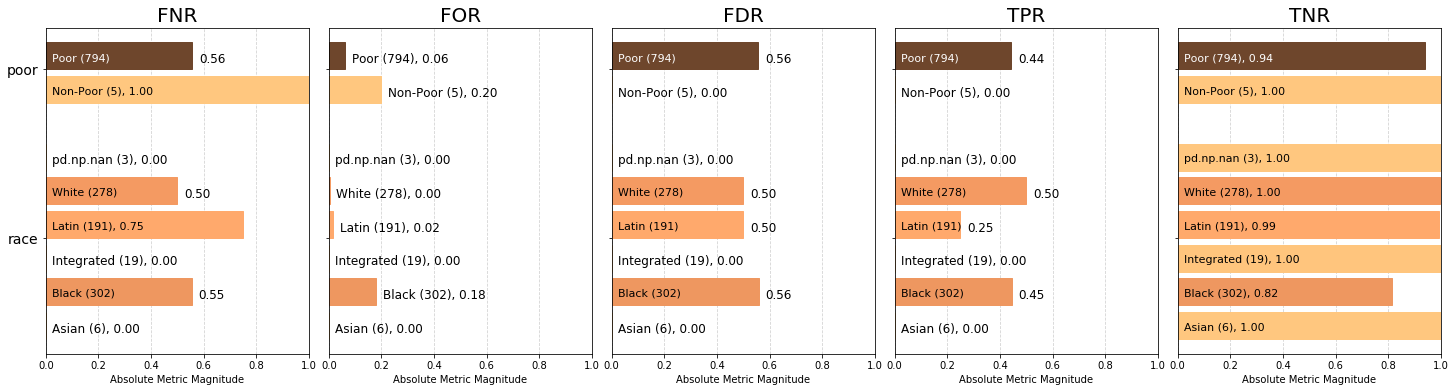

<Figure size 432x288 with 0 Axes>

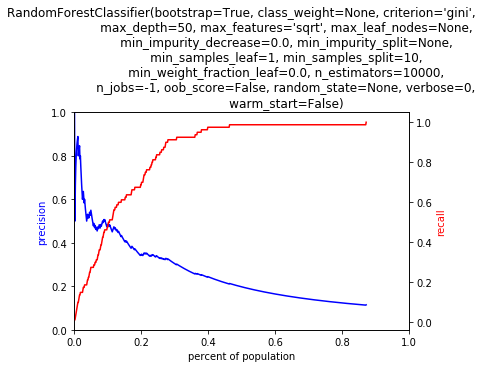

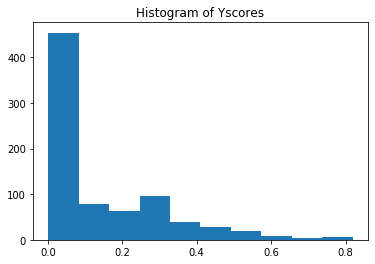

FEATURE IMPORTANCES

1. Feature label_prev_year (0.067467)
2. Feature eviction_filings_rate_group_low (0.018371)
3. Feature population_race_black_group_high (0.017182)
4. Feature eviction_filings_rate_group_medium (0.013346)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.013246)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.012440)
7. Feature population_race_black_group_low (0.011976)
8. Feature population_race_black_mean_by_commarea_group_high (0.011559)
9. Feature population_race_black_mean_by_commarea_group_low (0.009361)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.008042)
            score  label_value
race                          
Asian           0          0.0
Black          75         74.0
Integrated      0          0.0
Latin           2          4.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

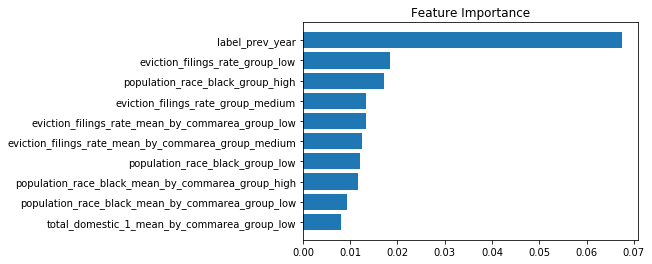

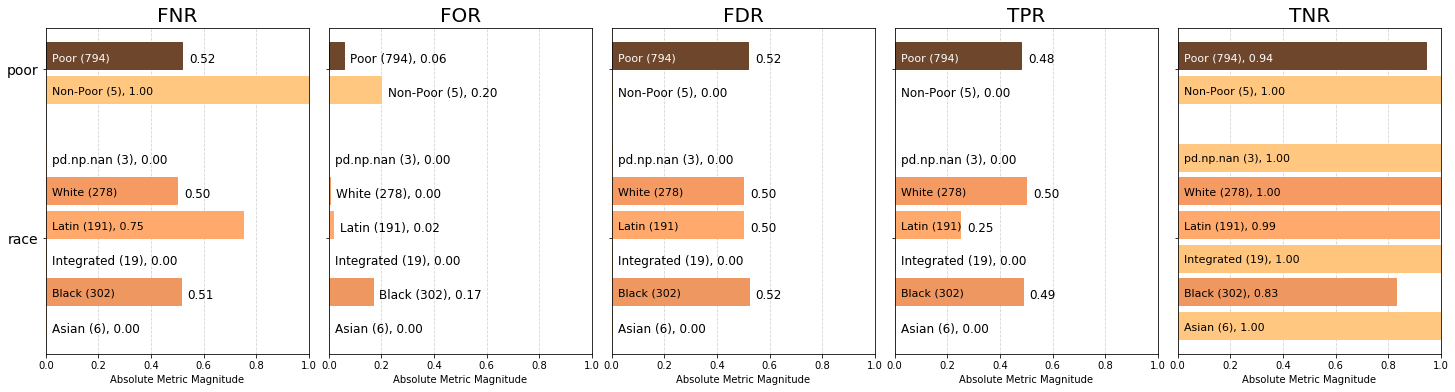

<Figure size 432x288 with 0 Axes>

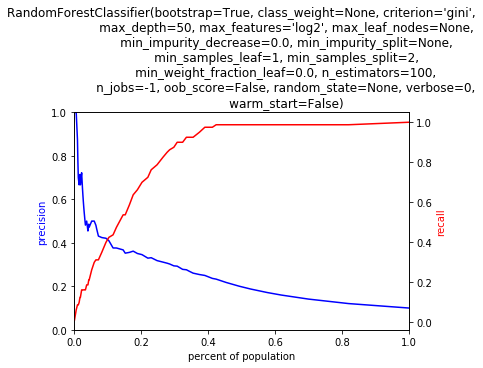

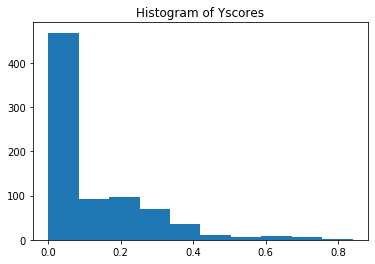

FEATURE IMPORTANCES

1. Feature label_prev_year (0.029949)
2. Feature some_college_group_medium (0.010912)
3. Feature population_race_black_group_high (0.010242)
4. Feature eviction_filings_rate_group_medium (0.008951)
5. Feature some_college_group_high (0.008842)
6. Feature perc_total_crime_class_Property Crime_group_low (0.008728)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008538)
8. Feature population_poverty_above_group_medium (0.008513)
9. Feature total_violation_status_COMPLIED_perc_group_medium (0.008362)
10. Feature perc_total_crime_class_Violent Crime_group_medium (0.008316)
            score  label_value
race                          
Asian           0          0.0
Black          74         74.0
Integrated      0          0.0
Latin           2          4.0
White           3          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

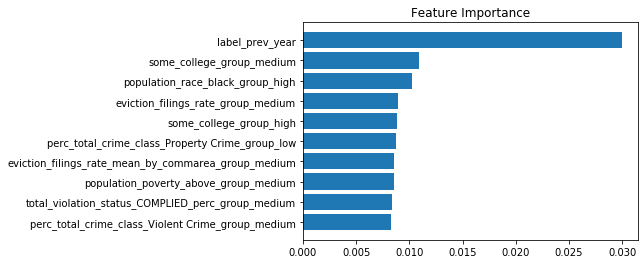

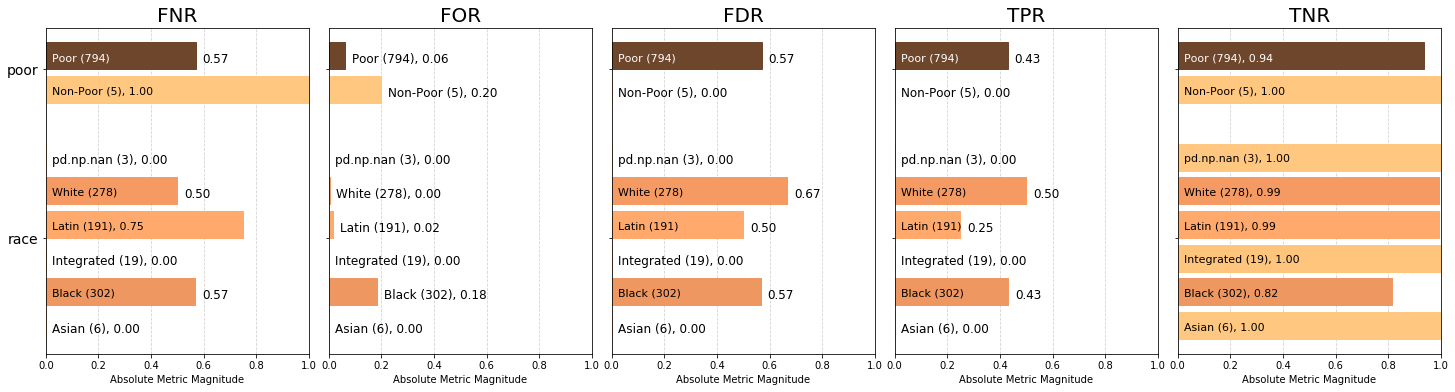

<Figure size 432x288 with 0 Axes>

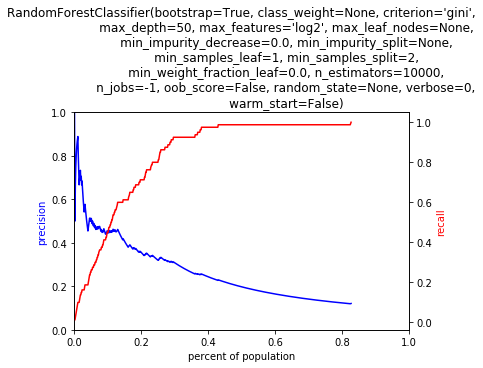

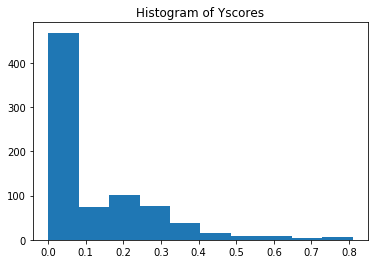

FEATURE IMPORTANCES

1. Feature label_prev_year (0.029112)
2. Feature some_college_group_medium (0.010849)
3. Feature some_college_group_high (0.008727)
4. Feature high_school_grad_group_medium (0.008644)
5. Feature eviction_filings_rate_group_low (0.008550)
6. Feature perc_total_crime_class_Property Crime_group_low (0.008394)
7. Feature population_poverty_below_group_medium (0.008256)
8. Feature population_poverty_above_group_medium (0.008214)
9. Feature not_highschool_grad_group_medium (0.008091)
10. Feature perc_total_crime_class_Property Crime_group_medium (0.008016)
            score  label_value
race                          
Asian           0          0.0
Black          75         74.0
Integrated      0          0.0
Latin           2          4.0
White           2          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

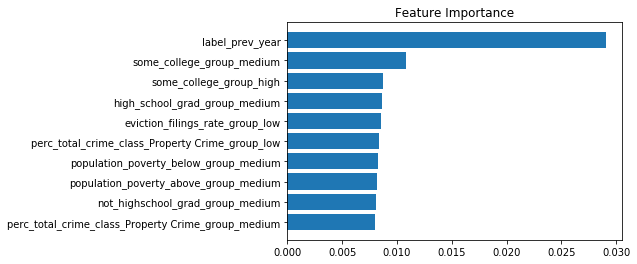

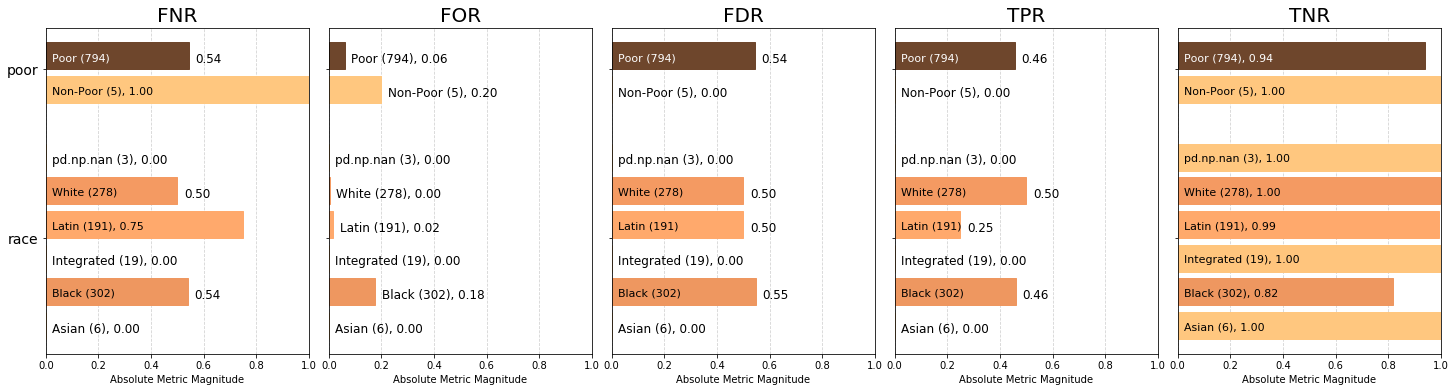

<Figure size 432x288 with 0 Axes>

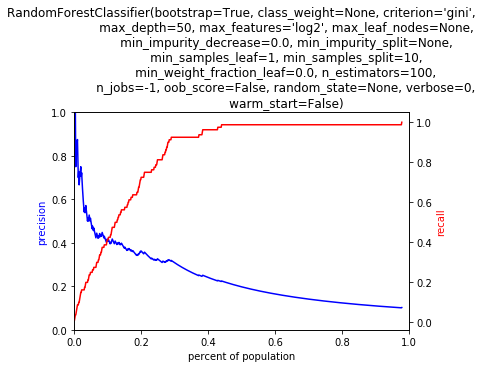

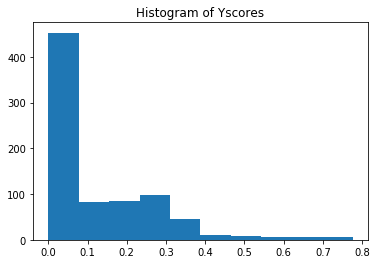

FEATURE IMPORTANCES

1. Feature label_prev_year (0.033465)
2. Feature population_race_black_group_high (0.011890)
3. Feature eviction_filings_rate_group_medium (0.011396)
4. Feature eviction_filings_rate_group_low (0.010300)
5. Feature population_race_black_mean_by_commarea_group_low (0.009978)
6. Feature population_race_black_mean_by_commarea_group_high (0.008999)
7. Feature population_poverty_above_group_high (0.008197)
8. Feature eviction_filings_rate_mean_by_commarea_group_low (0.007726)
9. Feature ftu_eviction_order_tenant_prose_group_low (0.007651)
10. Feature total_domestic_1_group_low (0.007104)
            score  label_value
race                          
Asian           0          0.0
Black          77         74.0
Integrated      0          0.0
Latin           1          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

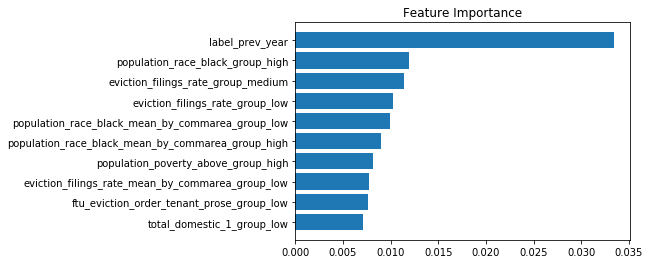

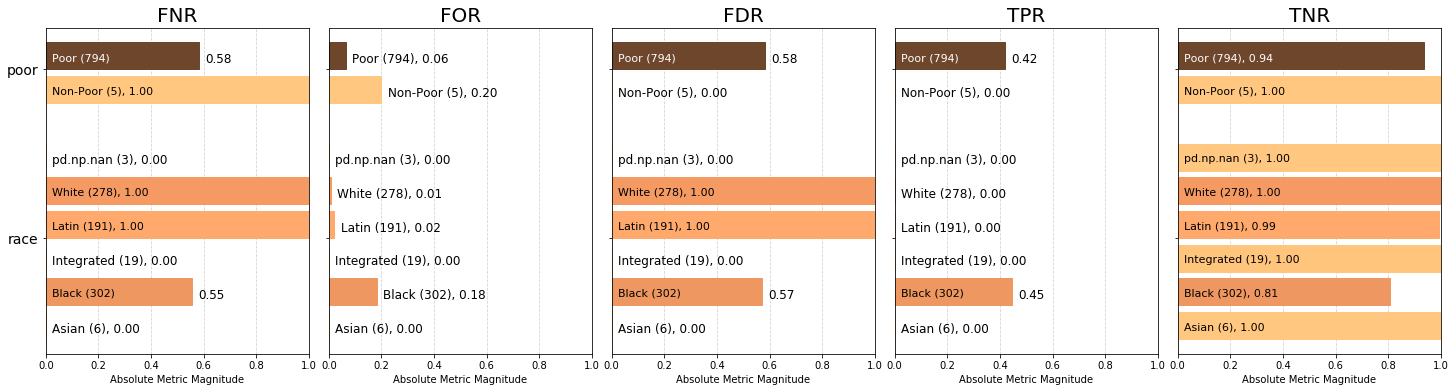

<Figure size 432x288 with 0 Axes>

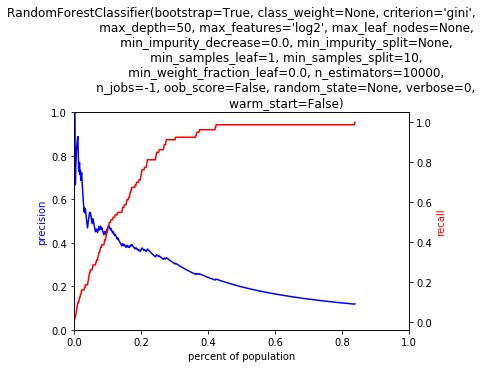

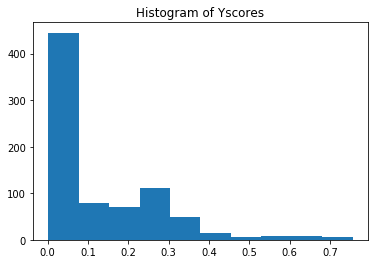

FEATURE IMPORTANCES

1. Feature label_prev_year (0.037139)
2. Feature eviction_filings_rate_group_low (0.012895)
3. Feature population_race_black_group_high (0.011113)
4. Feature eviction_filings_rate_group_medium (0.010474)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.009776)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.009108)
7. Feature population_race_black_group_low (0.008908)
8. Feature population_race_black_mean_by_commarea_group_high (0.008794)
9. Feature population_race_black_mean_by_commarea_group_low (0.006555)
10. Feature perc_total_crime_class_Violent Crime_mean_by_commarea_group_high (0.005841)
            score  label_value
race                          
Asian           0          0.0
Black          78         74.0
Integrated      0          0.0
Latin           0          4.0
White           1          2.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

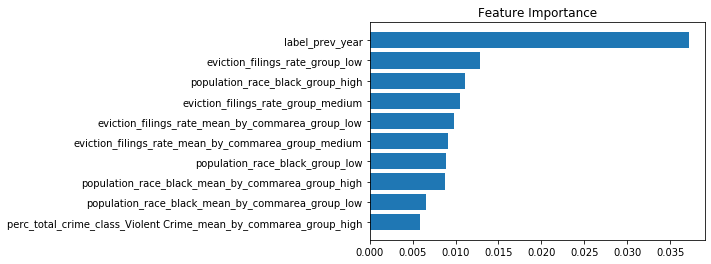

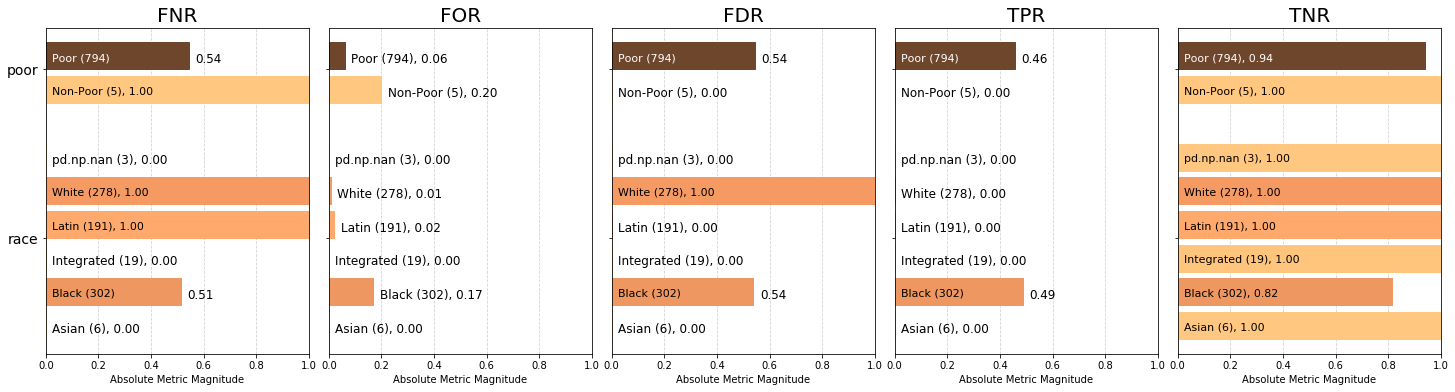

RF


<Figure size 432x288 with 0 Axes>

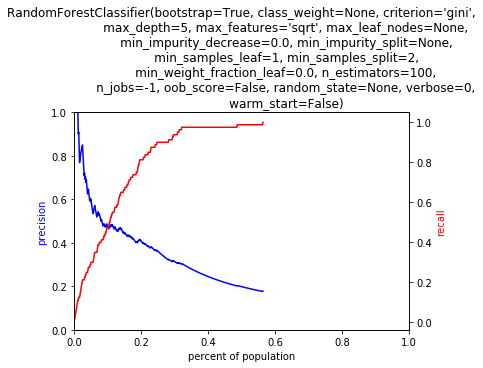

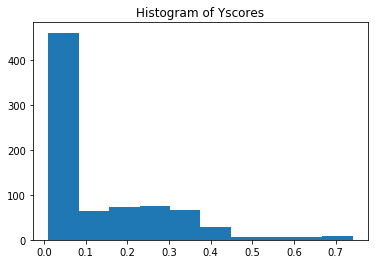

FEATURE IMPORTANCES

1. Feature label_prev_year (0.075522)
2. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.041938)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.031109)
4. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_low (0.029142)
5. Feature eviction_filings_rate_group_low (0.026943)
6. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.026705)
7. Feature population_race_black_mean_by_commarea_group_high (0.024851)
8. Feature population_race_black_group_low (0.021915)
9. Feature population_race_black_group_high (0.018584)
10. Feature population_race_black_mean_by_commarea_group_low (0.018218)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           2          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

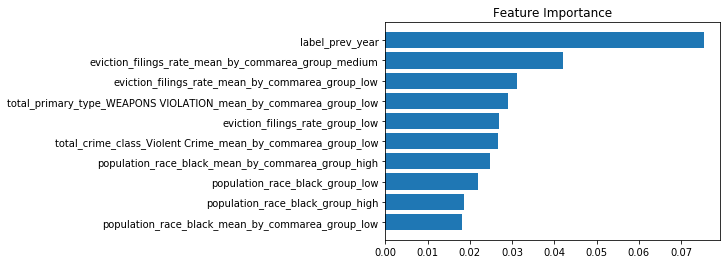

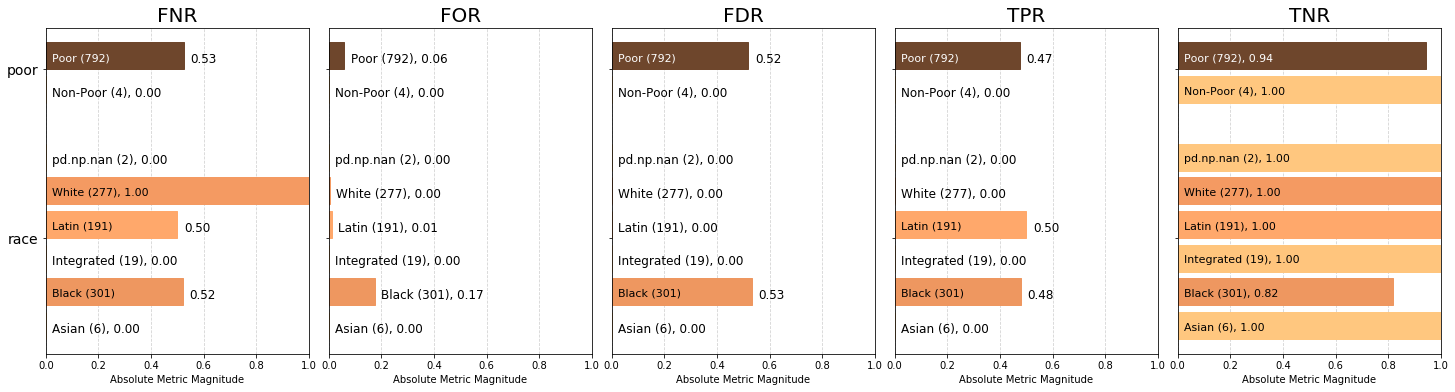

<Figure size 432x288 with 0 Axes>

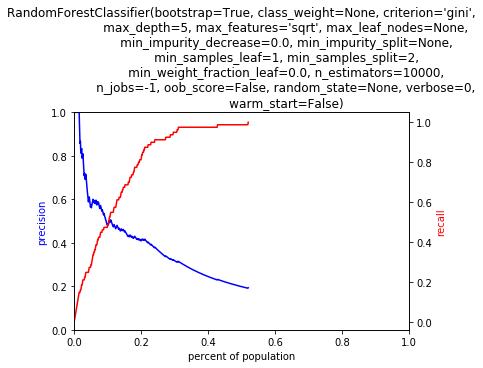

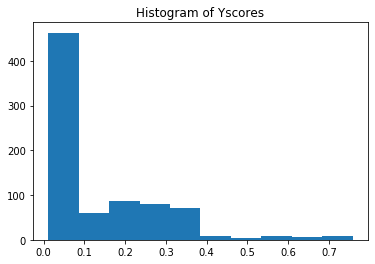

FEATURE IMPORTANCES

1. Feature label_prev_year (0.080505)
2. Feature population_race_black_group_high (0.033327)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.031958)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.028202)
5. Feature population_race_black_mean_by_commarea_group_high (0.027284)
6. Feature population_race_black_group_low (0.026089)
7. Feature eviction_filings_rate_group_low (0.021135)
8. Feature population_race_black_mean_by_commarea_group_low (0.021038)
9. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.019581)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.019430)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

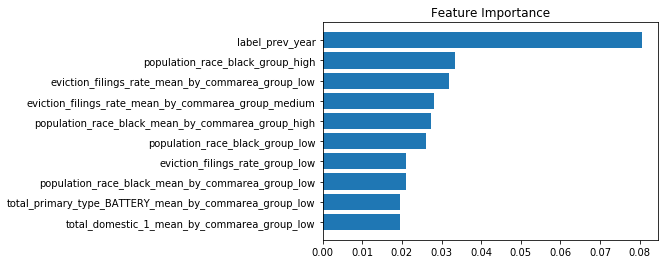

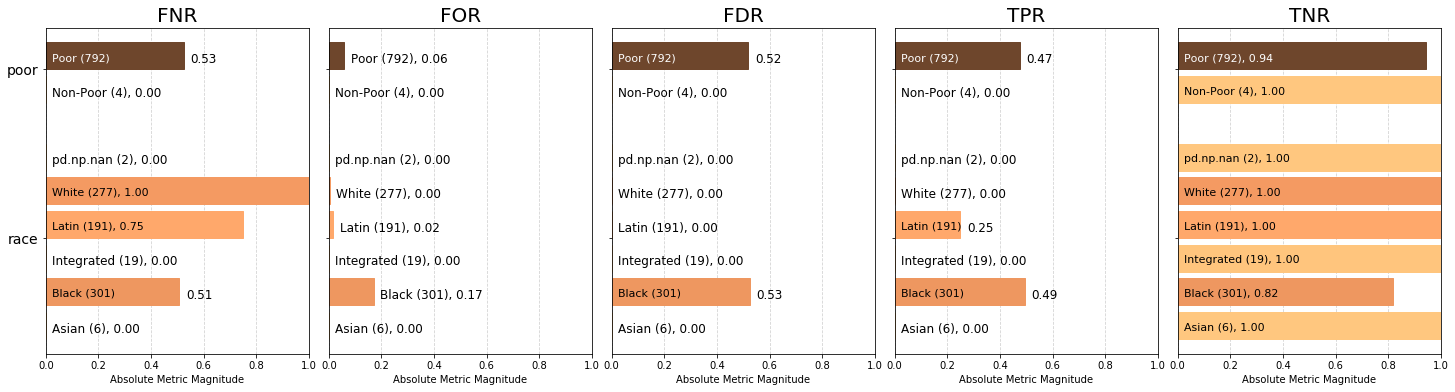

<Figure size 432x288 with 0 Axes>

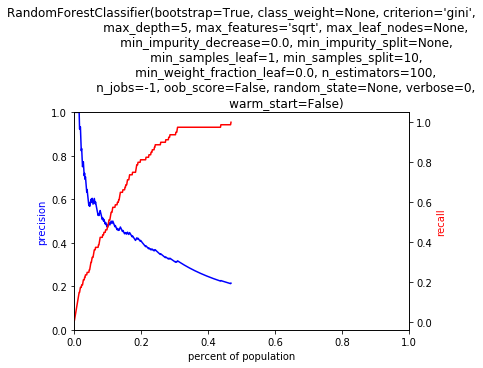

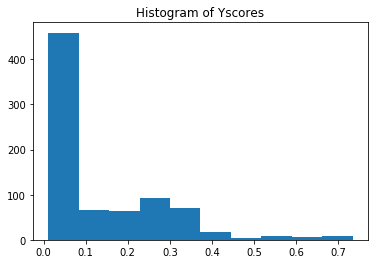

FEATURE IMPORTANCES

1. Feature label_prev_year (0.086912)
2. Feature population_race_black_group_high (0.033391)
3. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.027398)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.026422)
5. Feature population_race_black_mean_by_commarea_group_low (0.025077)
6. Feature population_race_black_mean_by_commarea_group_high (0.024280)
7. Feature total_domestic_1_mean_by_commarea_group_low (0.023634)
8. Feature population_race_black_group_low (0.022604)
9. Feature eviction_filings_rate_group_low (0.019770)
10. Feature eviction_filings_rate_group_medium (0.019483)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

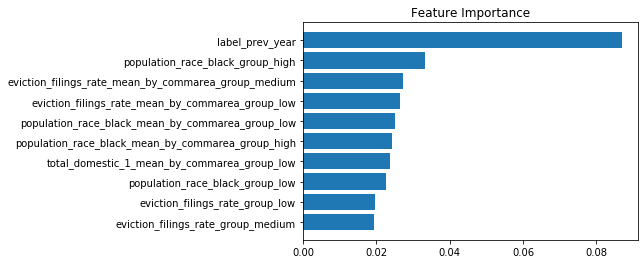

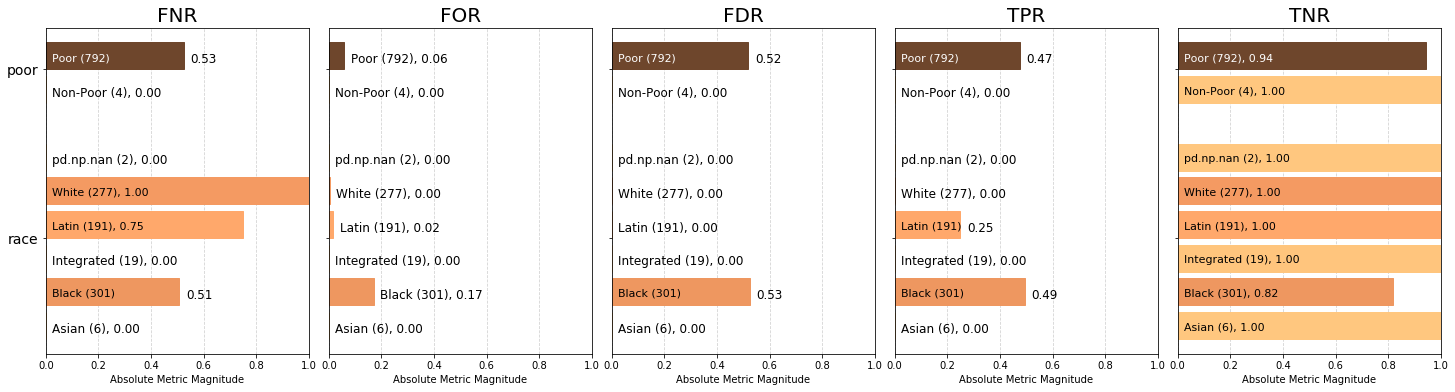

<Figure size 432x288 with 0 Axes>

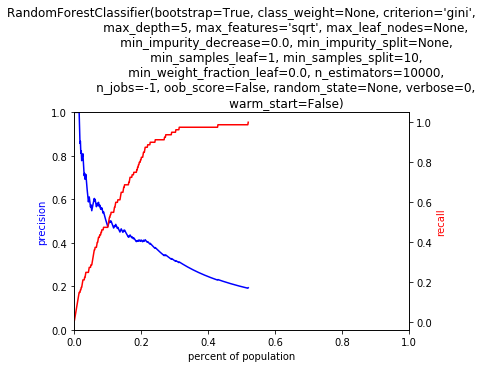

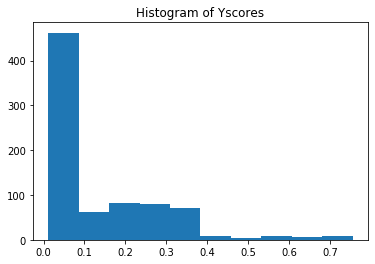

FEATURE IMPORTANCES

1. Feature label_prev_year (0.084212)
2. Feature population_race_black_group_high (0.033942)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.030246)
4. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.029561)
5. Feature population_race_black_group_low (0.028403)
6. Feature population_race_black_mean_by_commarea_group_high (0.027851)
7. Feature eviction_filings_rate_group_low (0.022136)
8. Feature population_race_black_mean_by_commarea_group_low (0.021355)
9. Feature total_domestic_1_mean_by_commarea_group_low (0.020164)
10. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.018896)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

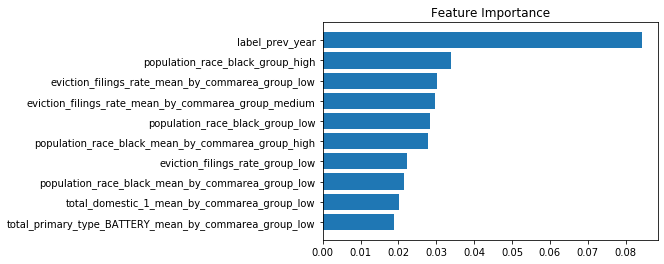

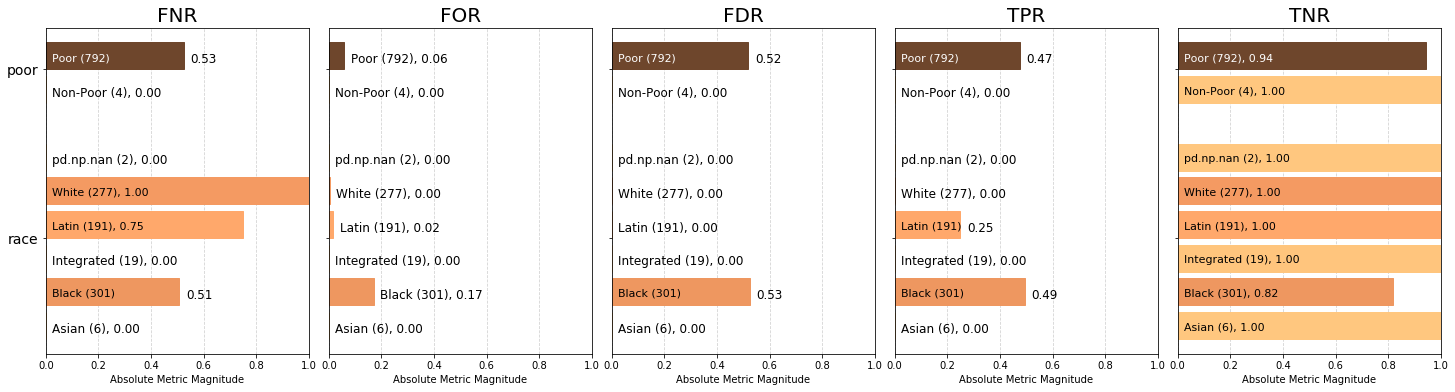

<Figure size 432x288 with 0 Axes>

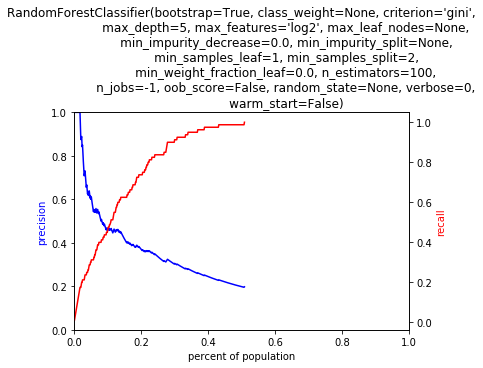

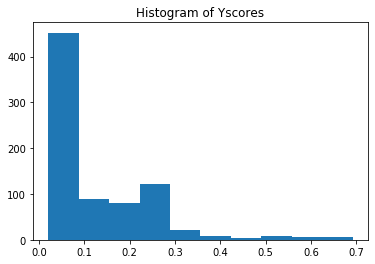

FEATURE IMPORTANCES

1. Feature label_prev_year (0.042115)
2. Feature total_crime_class_Less serious offences_mean_by_commarea_group_low (0.021482)
3. Feature eviction_filings_rate_mean_by_commarea_group_low (0.020717)
4. Feature total_primary_type_ASSAULT_mean_by_commarea_group_low (0.018845)
5. Feature total_domestic_1_mean_by_commarea_group_low (0.016408)
6. Feature back_rent_1000_to_2499_group_low (0.014542)
7. Feature population_race_black_mean_by_commarea_group_high (0.013517)
8. Feature population_race_black_mean_by_commarea_group_low (0.011856)
9. Feature eviction_filings_total_group_medium (0.011172)
10. Feature ftu_no_outcome_tenant_prose_mean_by_commarea_group_low (0.010825)
            score  label_value
race                          
Asian           0          0.0
Black          79         75.0
Integrated      0          0.0
Latin           0          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

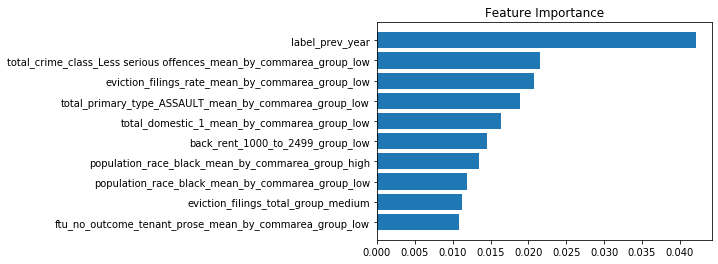

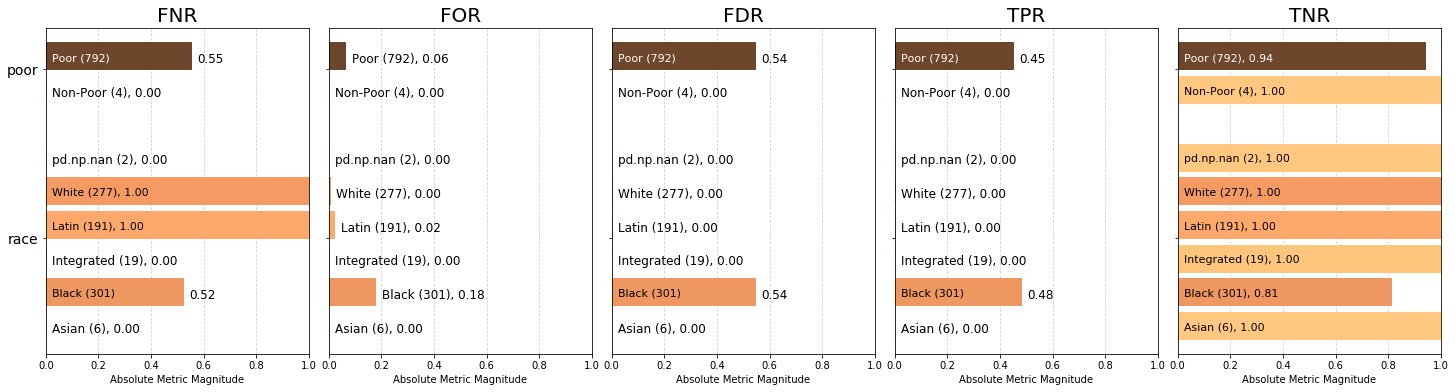

<Figure size 432x288 with 0 Axes>

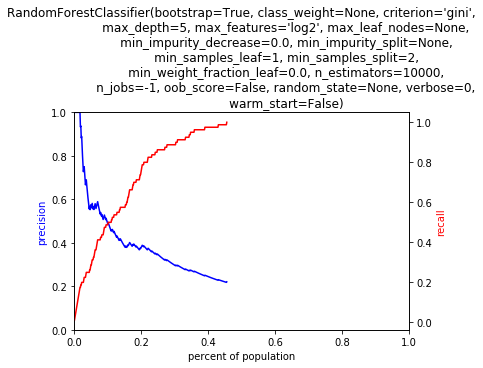

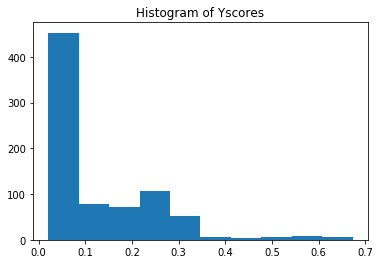

FEATURE IMPORTANCES

1. Feature label_prev_year (0.032560)
2. Feature population_race_black_group_high (0.018117)
3. Feature population_race_black_group_low (0.017687)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.016963)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.016014)
6. Feature population_race_black_mean_by_commarea_group_high (0.015597)
7. Feature total_domestic_1_mean_by_commarea_group_low (0.013671)
8. Feature population_race_black_mean_by_commarea_group_low (0.013630)
9. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.012234)
10. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.011376)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

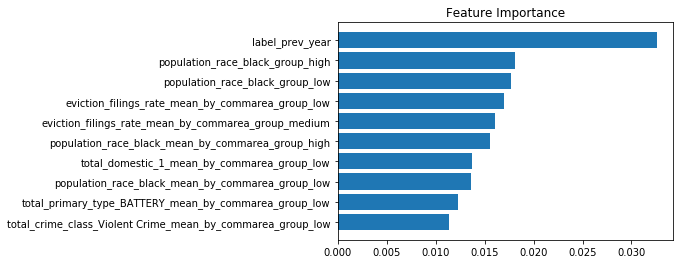

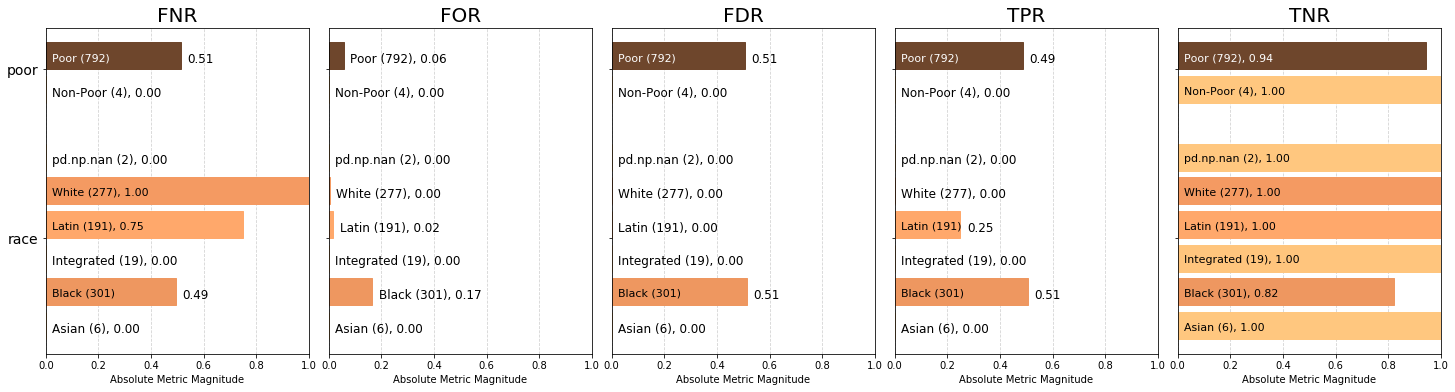

<Figure size 432x288 with 0 Axes>

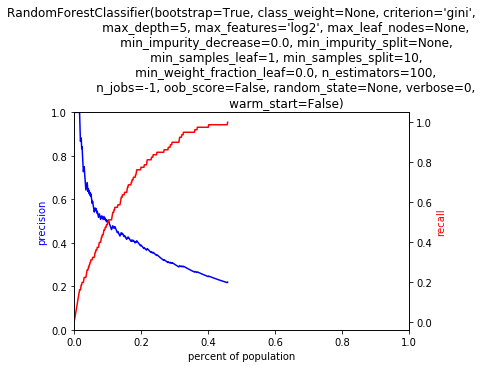

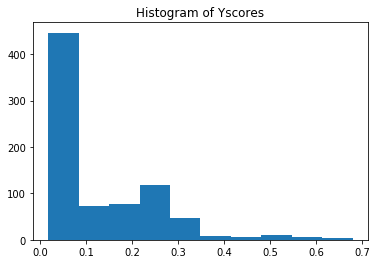

FEATURE IMPORTANCES

1. Feature label_prev_year (0.034805)
2. Feature eviction_filings_rate_mean_by_commarea_group_low (0.034375)
3. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.029272)
4. Feature total_crime_class_Violent Crime_mean_by_commarea_group_low (0.022923)
5. Feature population_race_black_group_high (0.021651)
6. Feature eviction_filings_total_group_low (0.020262)
7. Feature population_poverty_above_mean_by_commarea_group_high (0.018674)
8. Feature total_primary_type_ASSAULT_mean_by_commarea_group_medium (0.016790)
9. Feature total_primary_type_WEAPONS VIOLATION_mean_by_commarea_group_medium (0.016599)
10. Feature population_race_black_mean_by_commarea_group_high (0.015583)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           2          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

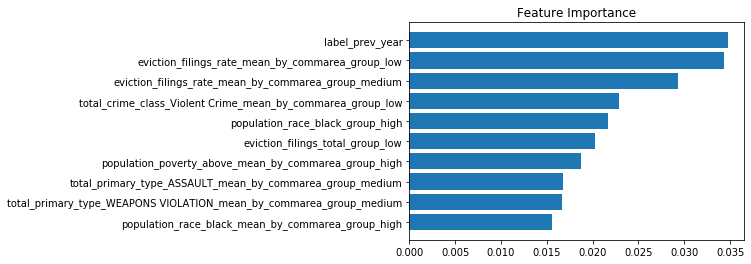

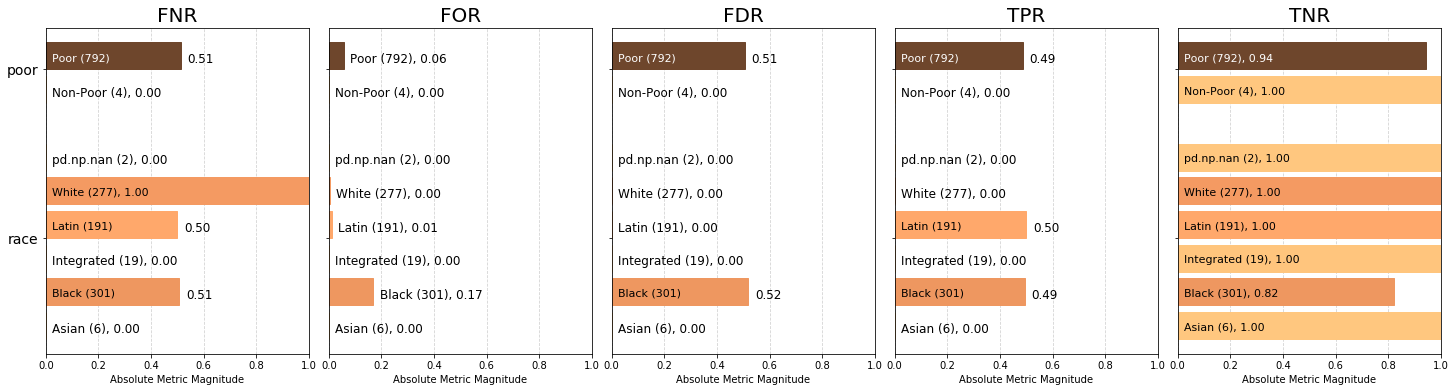

<Figure size 432x288 with 0 Axes>

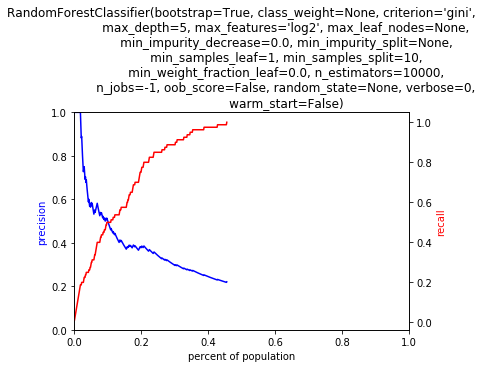

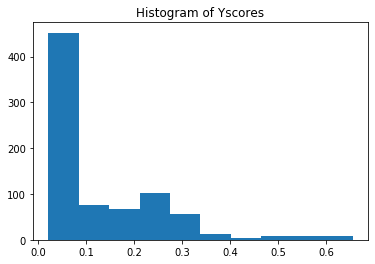

FEATURE IMPORTANCES

1. Feature label_prev_year (0.031769)
2. Feature population_race_black_group_high (0.018626)
3. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.017592)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.017284)
5. Feature population_race_black_group_low (0.017146)
6. Feature population_race_black_mean_by_commarea_group_high (0.015146)
7. Feature total_domestic_1_mean_by_commarea_group_low (0.014876)
8. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.013387)
9. Feature population_race_black_mean_by_commarea_group_low (0.013173)
10. Feature total_crime_class_Less serious offences_mean_by_commarea_group_low (0.012347)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           1          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

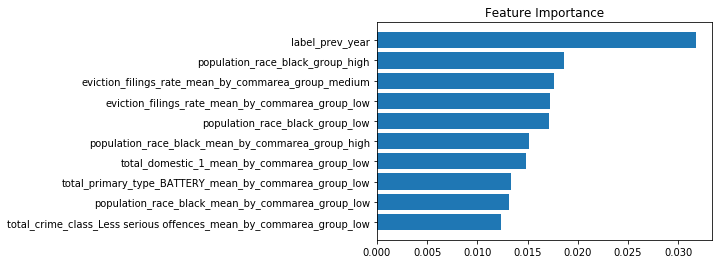

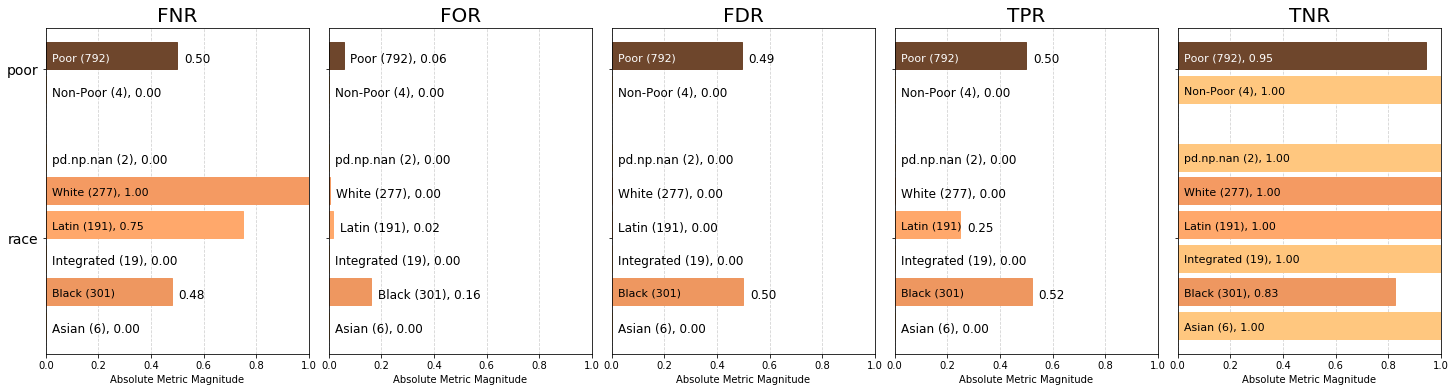

<Figure size 432x288 with 0 Axes>

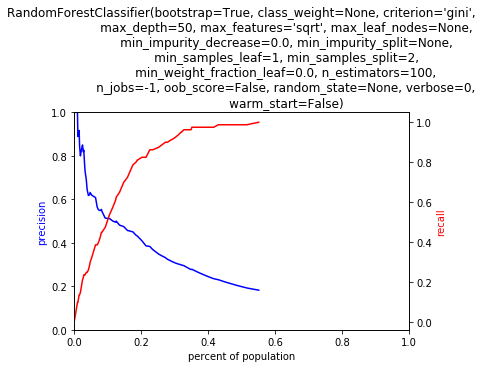

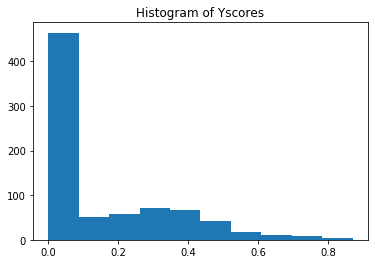

FEATURE IMPORTANCES

1. Feature label_prev_year (0.050913)
2. Feature population_race_black_group_low (0.011324)
3. Feature some_college_group_medium (0.010898)
4. Feature eviction_filings_rate_group_low (0.010830)
5. Feature eviction_filings_rate_group_medium (0.010560)
6. Feature population_race_black_mean_by_commarea_group_high (0.009543)
7. Feature population_poverty_above_group_high (0.009154)
8. Feature total_primary_type_ROBBERY_mean_by_commarea_group_medium (0.009127)
9. Feature perc_total_crime_class_Property Crime_group_medium (0.009125)
10. Feature some_college_group_high (0.009003)
            score  label_value
race                          
Asian           0          0.0
Black          75         75.0
Integrated      0          0.0
Latin           2          4.0
White           2          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

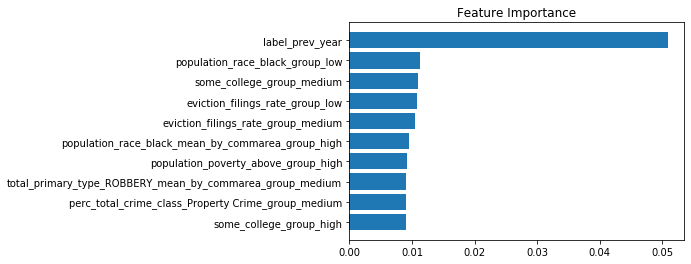

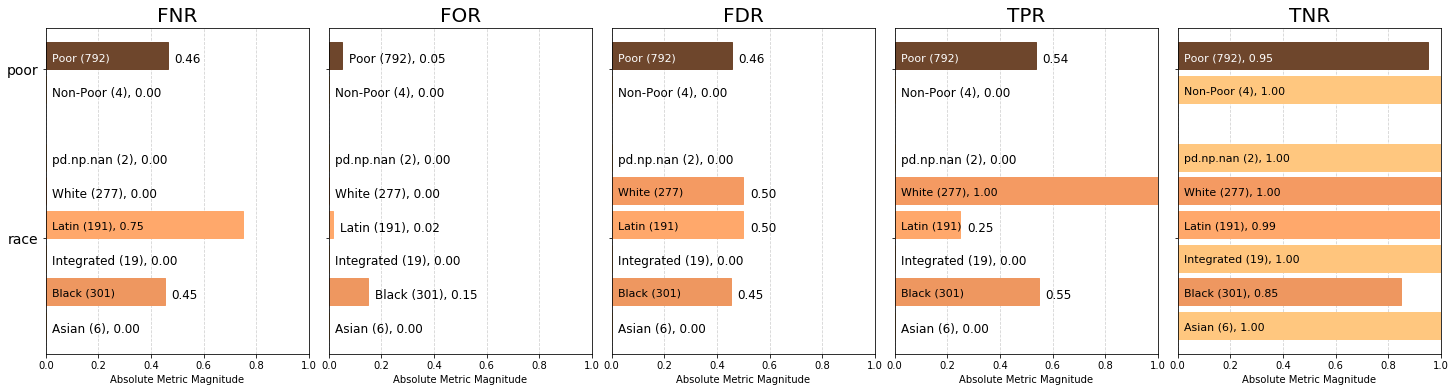

<Figure size 432x288 with 0 Axes>

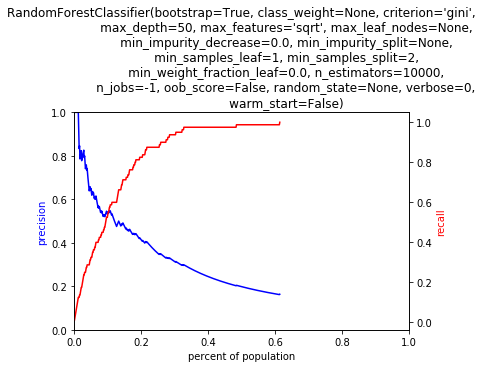

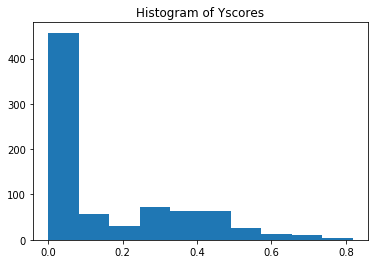

FEATURE IMPORTANCES

1. Feature label_prev_year (0.049313)
2. Feature population_race_black_group_high (0.012041)
3. Feature eviction_filings_rate_group_low (0.011475)
4. Feature some_college_group_medium (0.010318)
5. Feature eviction_filings_rate_mean_by_commarea_group_low (0.009490)
6. Feature perc_total_crime_class_Property Crime_group_low (0.008986)
7. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.008711)
8. Feature eviction_filings_rate_group_medium (0.008574)
9. Feature high_school_grad_group_medium (0.008531)
10. Feature some_college_group_high (0.008480)
            score  label_value
race                          
Asian           0          0.0
Black          76         75.0
Integrated      0          0.0
Latin           1          4.0
White           2          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

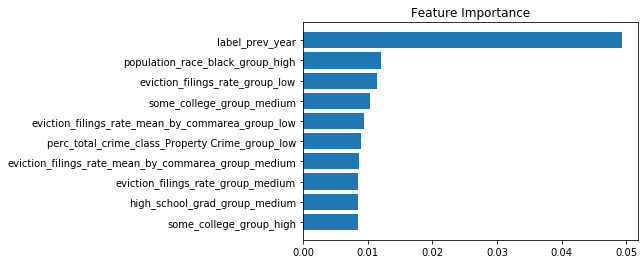

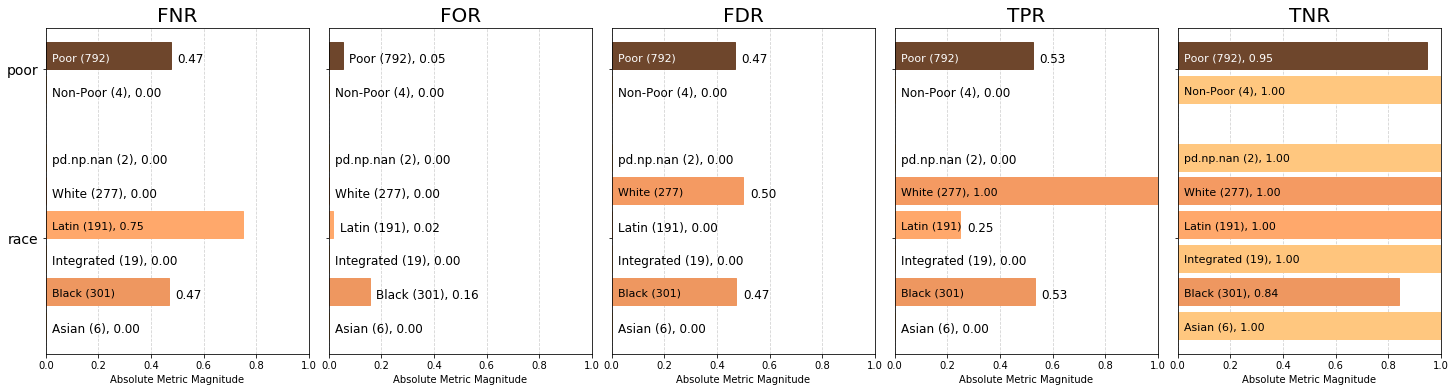

<Figure size 432x288 with 0 Axes>

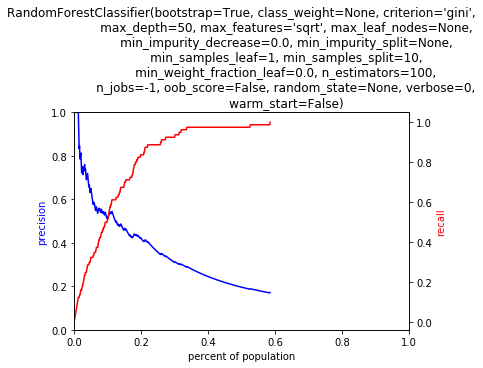

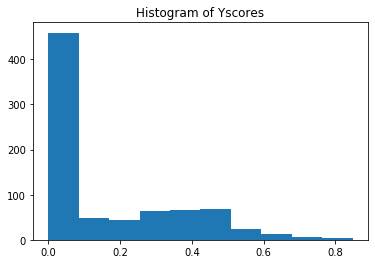

FEATURE IMPORTANCES

1. Feature label_prev_year (0.069133)
2. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.022303)
3. Feature population_race_black_group_high (0.018654)
4. Feature eviction_filings_rate_group_low (0.016655)
5. Feature eviction_filings_rate_group_medium (0.012683)
6. Feature population_race_black_mean_by_commarea_group_high (0.012624)
7. Feature eviction_filings_rate_mean_by_commarea_group_low (0.011669)
8. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.010653)
9. Feature total_primary_type_ASSAULT_mean_by_commarea_group_low (0.009891)
10. Feature population_race_black_group_low (0.009791)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           2          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

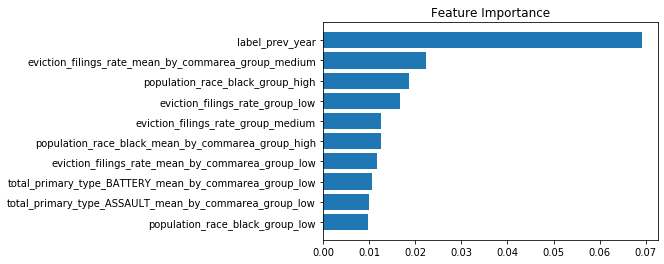

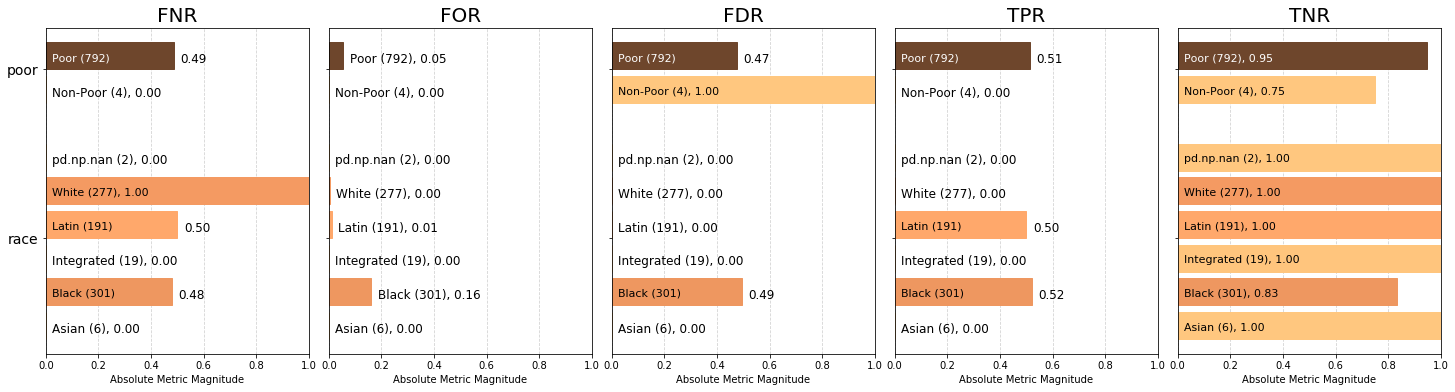

<Figure size 432x288 with 0 Axes>

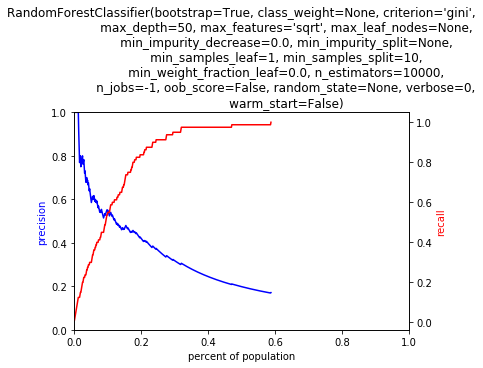

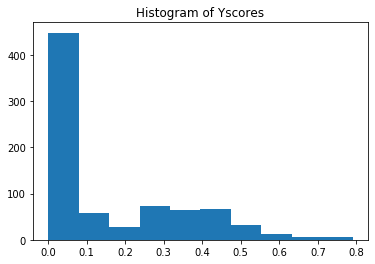

FEATURE IMPORTANCES

1. Feature label_prev_year (0.070245)
2. Feature population_race_black_group_high (0.017669)
3. Feature eviction_filings_rate_group_low (0.016760)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.014303)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.013916)
6. Feature population_race_black_mean_by_commarea_group_high (0.013138)
7. Feature population_race_black_group_low (0.012978)
8. Feature eviction_filings_rate_group_medium (0.012523)
9. Feature population_race_black_mean_by_commarea_group_low (0.009547)
10. Feature total_domestic_1_mean_by_commarea_group_low (0.008840)
            score  label_value
race                          
Asian           0          0.0
Black          77         75.0
Integrated      0          0.0
Latin           2          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

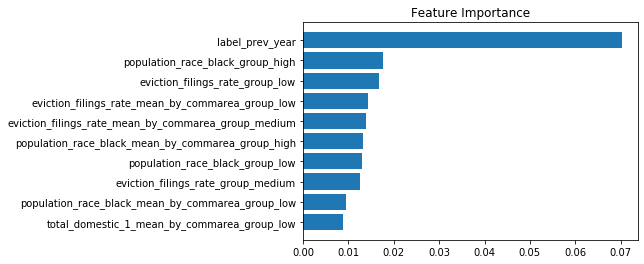

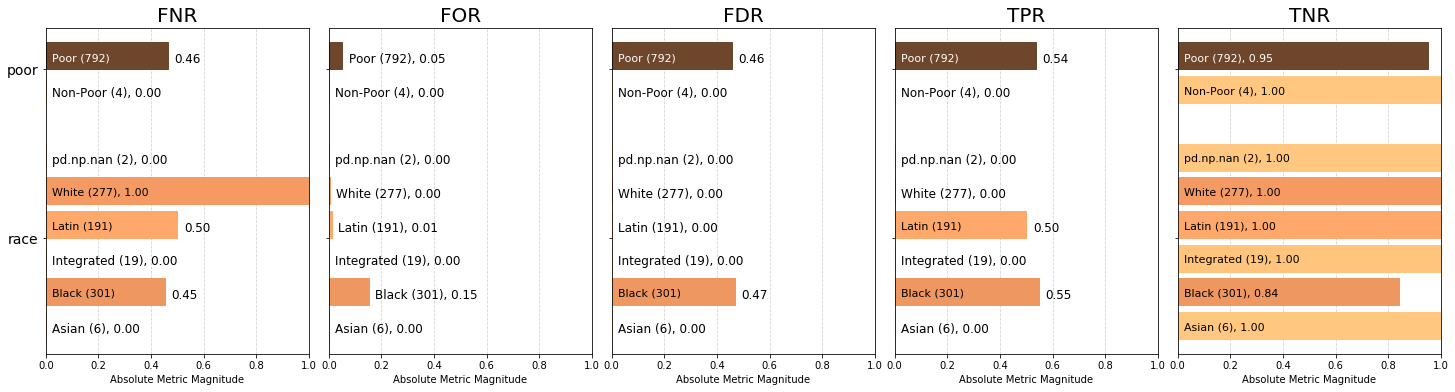

<Figure size 432x288 with 0 Axes>

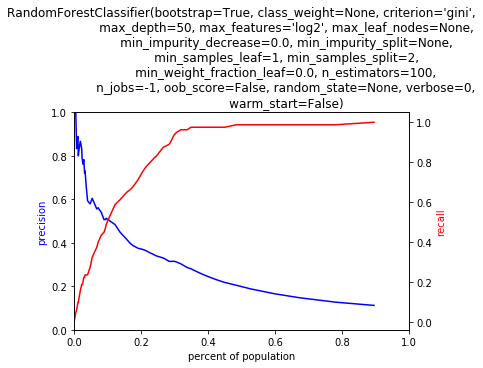

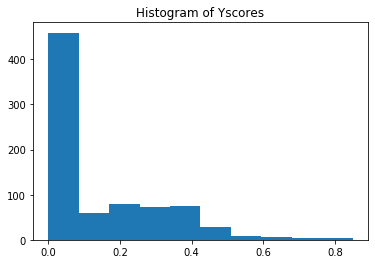

FEATURE IMPORTANCES

1. Feature label_prev_year (0.032212)
2. Feature some_college_group_medium (0.010878)
3. Feature population_poverty_below_group_medium (0.009766)
4. Feature not_highschool_grad_group_low (0.009577)
5. Feature some_college_group_high (0.009136)
6. Feature perc_total_crime_class_Property Crime_group_medium (0.009037)
7. Feature high_school_grad_group_medium (0.008935)
8. Feature total_violation_status_OPEN_perc_group_medium (0.008869)
9. Feature perc_increase_total_crime_class_Less serious offences_group_low (0.008833)
10. Feature high_school_grad_group_high (0.008754)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           0          4.0
White           1          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

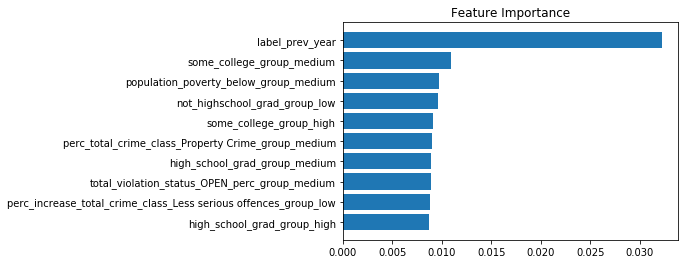

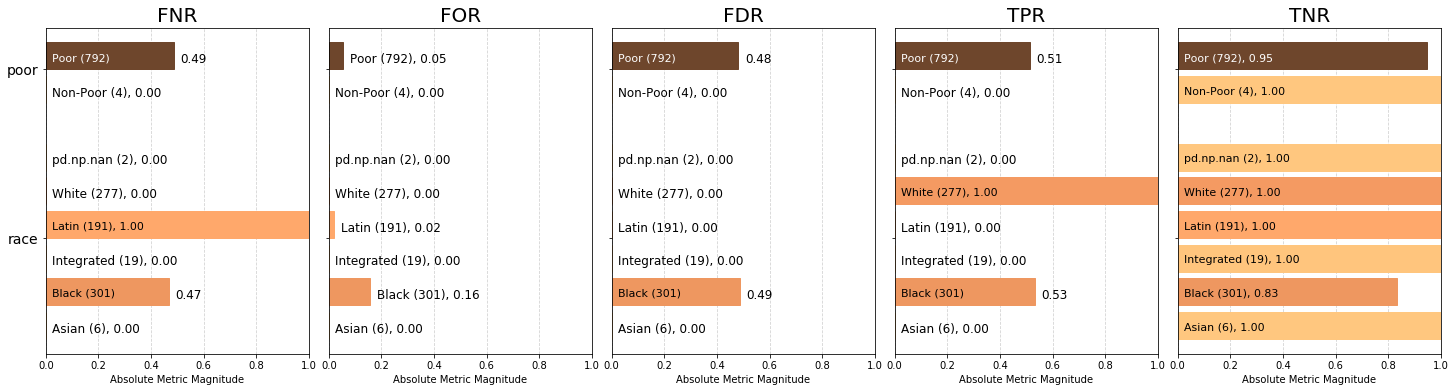

<Figure size 432x288 with 0 Axes>

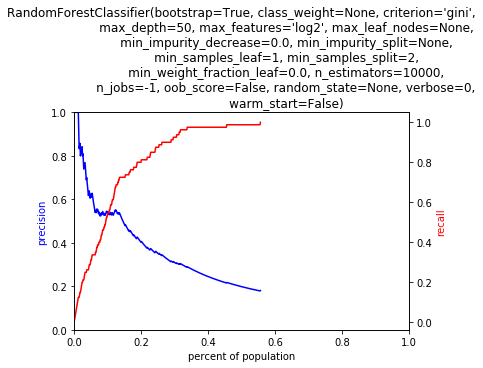

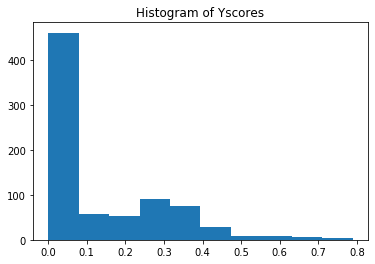

FEATURE IMPORTANCES

1. Feature label_prev_year (0.030693)
2. Feature some_college_group_medium (0.011515)
3. Feature perc_total_crime_class_Property Crime_group_low (0.009895)
4. Feature high_school_grad_group_medium (0.009474)
5. Feature some_college_group_high (0.009375)
6. Feature perc_total_crime_class_Property Crime_group_medium (0.009243)
7. Feature not_highschool_grad_group_medium (0.008756)
8. Feature not_highschool_grad_group_low (0.008657)
9. Feature high_school_grad_group_high (0.008596)
10. Feature perc_increase_total_crime_class_Less serious offences_group_medium (0.008515)
            score  label_value
race                          
Asian           0          0.0
Black          78         75.0
Integrated      0          0.0
Latin           0          4.0
White           1          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

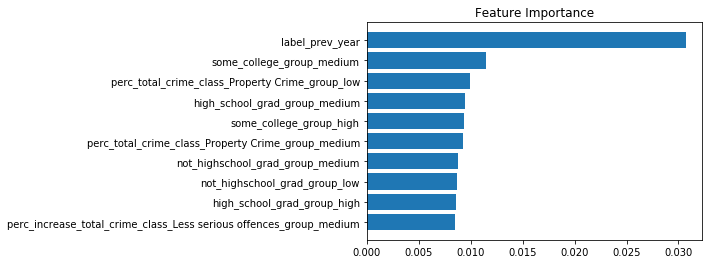

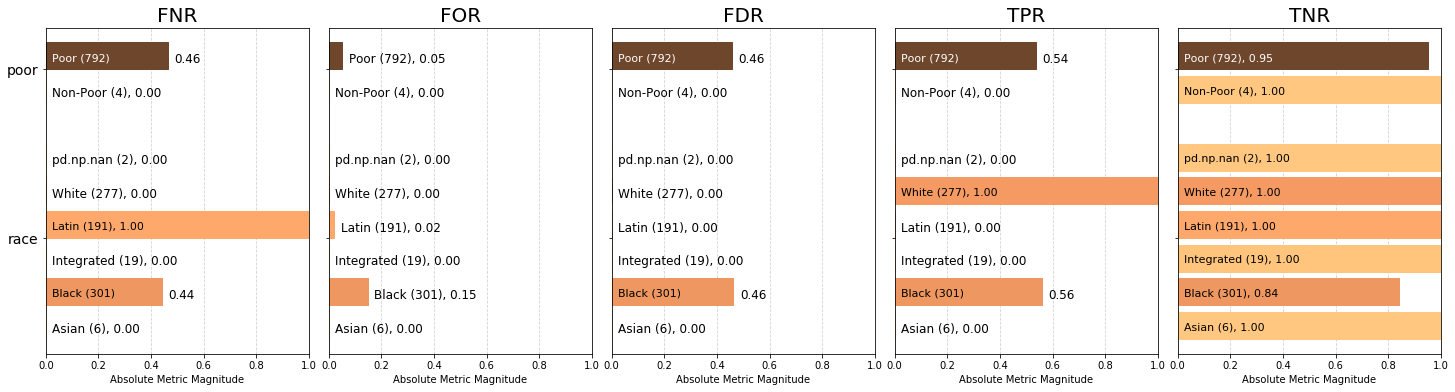

<Figure size 432x288 with 0 Axes>

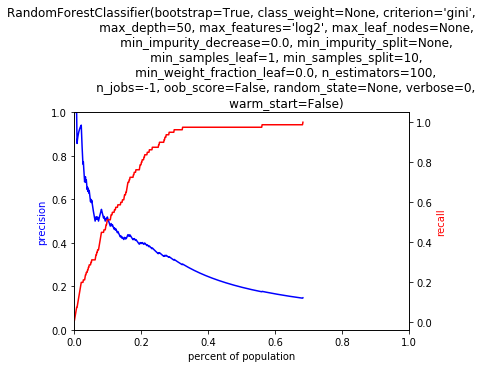

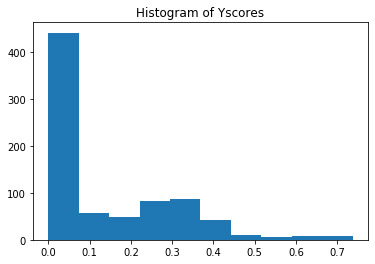

FEATURE IMPORTANCES

1. Feature label_prev_year (0.023994)
2. Feature eviction_filings_rate_group_low (0.015059)
3. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.013246)
4. Feature population_race_black_group_high (0.012480)
5. Feature population_race_black_mean_by_commarea_group_high (0.010739)
6. Feature population_race_black_group_low (0.010464)
7. Feature total_primary_type_INTERFERENCE WITH PUBLIC OFFICER_mean_by_commarea_group_low (0.009197)
8. Feature eviction_filings_rate_group_medium (0.009025)
9. Feature total_primary_type_BATTERY_mean_by_commarea_group_medium (0.008705)
10. Feature eviction_filings_rate_mean_by_commarea_group_low (0.008412)
            score  label_value
race                          
Asian           0          0.0
Black          79         75.0
Integrated      0          0.0
Latin           0          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

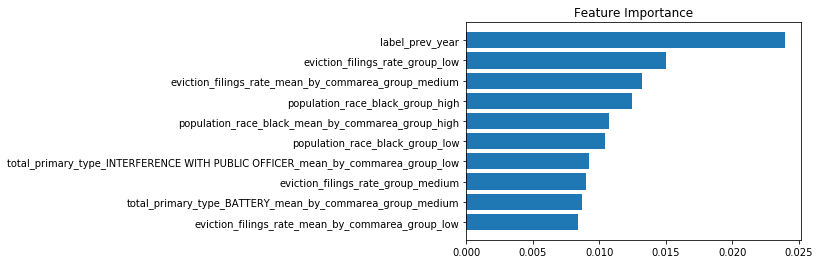

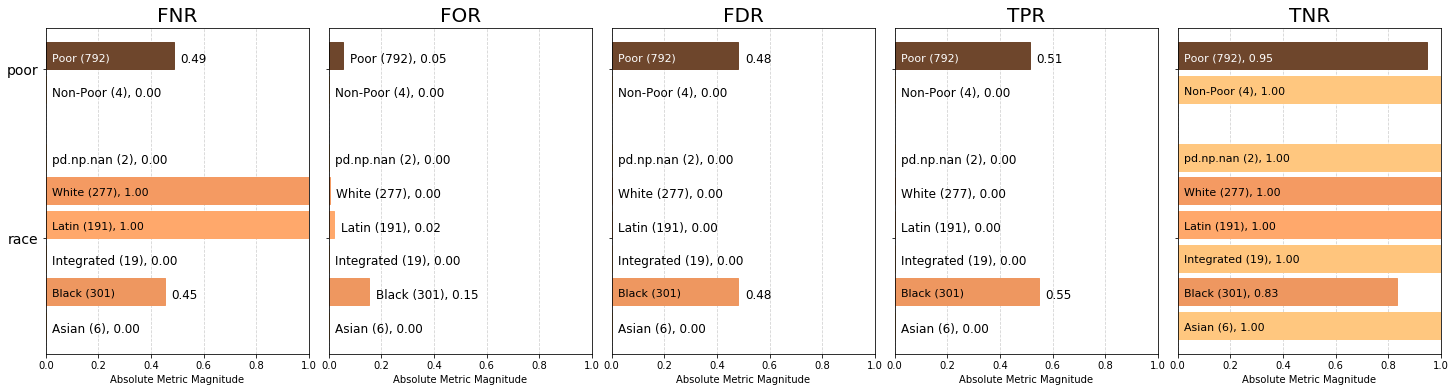

<Figure size 432x288 with 0 Axes>

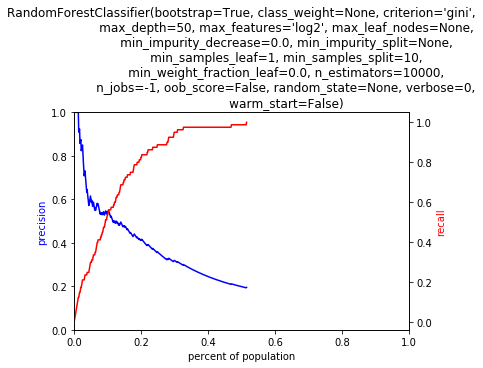

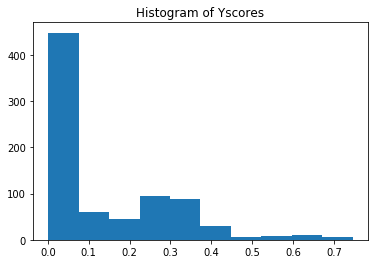

FEATURE IMPORTANCES

1. Feature label_prev_year (0.038567)
2. Feature population_race_black_group_high (0.012619)
3. Feature eviction_filings_rate_group_low (0.012535)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.010463)
5. Feature population_race_black_group_low (0.009691)
6. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.009570)
7. Feature eviction_filings_rate_group_medium (0.009540)
8. Feature population_race_black_mean_by_commarea_group_high (0.009357)
9. Feature population_race_black_mean_by_commarea_group_low (0.007517)
10. Feature perc_total_crime_class_Property Crime_group_low (0.006471)
            score  label_value
race                          
Asian           0          0.0
Black          79         75.0
Integrated      0          0.0
Latin           0          4.0
White           0          1.0
model_id, score_thresholds 1 {'rank_abs': [79]}


<Figure size 432x288 with 0 Axes>

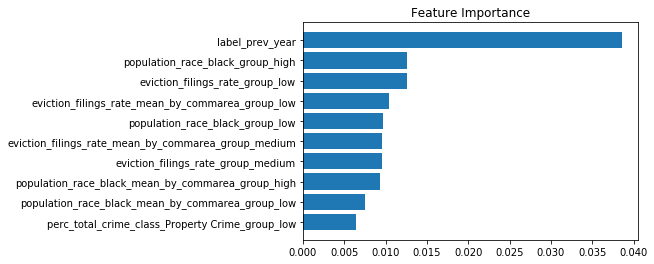

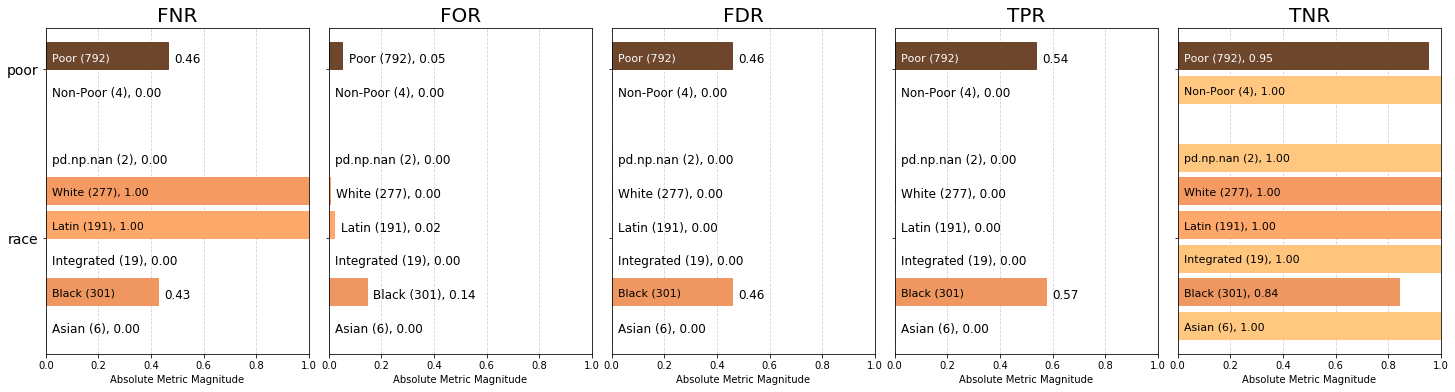

In [16]:
clfs, grid = helper.define_clfs_params(params['grid_size'])
predictors = selected_features
results_df = mlpipeline.clf_loop_cross_validation(params['models_to_run'], clfs, grid, processed_rv, 
                                                  predictors, params['outcome'], params['thresholds'],
                                                  params['date_col'], params['bias_list'])

In [17]:
results_df.to_csv('../results/RF_results.csv')

In [18]:
eviction_df['correct_with_baseline'] = eviction_df['label'] *eviction_df['label_prev_year']

In [19]:
eviction_df.groupby('year')['correct_with_baseline'].sum()/80

year
2010    0.5625
2011    0.5375
2012    0.5750
2013    0.5500
2014    0.4750
2015    0.5500
2016    0.4875
2017    0.0000
Name: correct_with_baseline, dtype: float64

In [20]:
results_df

model_type                                                clf  \
0          RF  (DecisionTreeClassifier(class_weight=None, cri...   
1          RF  (DecisionTreeClassifier(class_weight=None, cri...   
2          RF  (DecisionTreeClassifier(class_weight=None, cri...   
3          RF  (DecisionTreeClassifier(class_weight=None, cri...   
4          RF  (DecisionTreeClassifier(class_weight=None, cri...   
5          RF  (DecisionTreeClassifier(class_weight=None, cri...   
6          RF  (DecisionTreeClassifier(class_weight=None, cri...   
7          RF  (DecisionTreeClassifier(class_weight=None, cri...   
8          RF  (DecisionTreeClassifier(class_weight=None, cri...   
9          RF  (DecisionTreeClassifier(class_weight=None, cri...   
10         RF  (DecisionTreeClassifier(class_weight=None, cri...   
11         RF  (DecisionTreeClassifier(class_weight=None, cri...   
12         RF  (DecisionTreeClassifier(class_weight=None, cri...   
13         RF  (DecisionTreeClassifier(class_weight=None, cri...   
14         RF  (DecisionTreeClassifier(class_weight=None, cri...   
15         RF  (DecisionTreeClassifier(class_weight=None, cri...   
16         RF  (DecisionTreeClassifier(class_weight=None, cri...   
17         RF  (DecisionTreeClassifier(class_weight=None, cri...   
18         RF  (DecisionTreeClassifier(class_weight=None, cri...   
19         RF  (DecisionTreeClassifier(class_weight=None, cri...   
20         RF  (DecisionTreeClassifier(class_weight=None, cri...   
21         RF  (DecisionTreeClassifier(class_weight=None, cri...   
22         RF  (DecisionTreeClassifier(class_weight=None, cri...   
23         RF  (DecisionTreeClassifier(class_weight=None, cri...   
24         RF  (DecisionTreeClassifier(class_weight=None, cri...   
25         RF  (DecisionTreeClassifier(class_weight=None, cri...   
26         RF  (DecisionTreeClassifier(class_weight=None, cri...   
27         RF  (DecisionTreeClassifier(class_weight=None, cri...   
28         RF  (DecisionTreeClassifier(class_weight=None, cri...   
29         RF  (DecisionTreeClassifier(class_weight=None, cri...   
..        ...                                                ...   
34         RF  (DecisionTreeClassifier(class_weight=None, cri...   
35         RF  (DecisionTreeClassifier(class_weight=None, cri...   
36         RF  (DecisionTreeClassifier(class_weight=None, cri...   
37         RF  (DecisionTreeClassifier(class_weight=None, cri...   
38         RF  (DecisionTreeClassifier(class_weight=None, cri...   
39         RF  (DecisionTreeClassifier(class_weight=None, cri...   
40         RF  (DecisionTreeClassifier(class_weight=None, cri...   
41         RF  (DecisionTreeClassifier(class_weight=None, cri...   
42         RF  (DecisionTreeClassifier(class_weight=None, cri...   
43         RF  (DecisionTreeClassifier(class_weight=None, cri...   
44         RF  (DecisionTreeClassifier(class_weight=None, cri...   
45         RF  (DecisionTreeClassifier(class_weight=None, cri...   
46         RF  (DecisionTreeClassifier(class_weight=None, cri...   
47         RF  (DecisionTreeClassifier(class_weight=None, cri...   
48         RF  (DecisionTreeClassifier(class_weight=None, cri...   
49         RF  (DecisionTreeClassifier(class_weight=None, cri...   
50         RF  (DecisionTreeClassifier(class_weight=None, cri...   
51         RF  (DecisionTreeClassifier(class_weight=None, cri...   
52         RF  (DecisionTreeClassifier(class_weight=None, cri...   
53         RF  (DecisionTreeClassifier(class_weight=None, cri...   
54         RF  (DecisionTreeClassifier(class_weight=None, cri...   
55         RF  (DecisionTreeClassifier(class_weight=None, cri...   
56         RF  (DecisionTreeClassifier(class_weight=None, cri...   
57         RF  (DecisionTreeClassifier(class_weight=None, cri...   
58         RF  (DecisionTreeClassifier(class_weight=None, cri...   
59         RF  (DecisionTreeClassifier(class_weight=None, cri...   
60         RF  (DecisionTreeClassifier(class_weight=None, c